<style>
    div.output_wrapper {
      line-height: 1em; padding: 0;
      font-size: 1.2em;
    }
</style>


# Demonstration Informed Specification Search: Experiment

Let's take a look at how the DISS algorithm can search for specifications by leveraging expert demonstrations. 
We'll focus on learning DFAs in this case, but note that this approach is not confined to any specific concept class. To start consider an agent operating in the following stochastic gridworld.

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/enter_lava_augmented_1.svg"
         style="height: 25em;"
     />
</figure>

## Agent Actions

The agent can attempt to move up, down, left, or right as illustrated below.

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/enter_lava_augmented_2.svg"
         style="height: 20em;"
     />
</figure>

## Stochastic Transitions

However, there is some small probability that the agent will slip downward do to wind!

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/enter_lava_augmented_3.svg"
         style="height: 20em;"
     />
</figure>



Let's assume the agent's task can be described in terms of the color's of the tiles. **What was the agent trying to do?**


## Probably avoiding the red tiles

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/enter_lava_augmented_4.svg"
         style="height: 20em;"
     />
</figure>

## Probably trying to reach yellow tile

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/enter_lava_augmented_5.svg"
         style="height: 20em;"
     />
</figure>

In this notebook, we will illustrate learning task representations (in the form of Deterministic Finite Automata, i.e. DFA) that can be learned incrementally and describe temporal tasks.

In particular, we shall consider a variation of the following gridworld from [this](https://mjvc.me/DISS/#/77) slide deck: Here the agent's task is a composition of three subtasks.

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/example_domain_1.svg"
         style="height: 20em;"
     />
</figure>

Where each subtask is a regular language represented as a DFA.

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/example_domain_2_1.svg"
         style="height: 20em;"
     />
</figure>

Further, we shall assume that the first two subtasks are a-priori known (say due to learning in another workspace), 
<figure style="padding: 1em; background: #494949;">
    <img src="imgs/example_domain_1_2.svg"
         style="height: 20em;"
     />
</figure>

and our task is to learn the third task given a partial demonstration.
<figure style="padding: 1em; background: #494949;">
    <img src="imgs/example_domain_3_2.svg"
         style="height: 20em;"
     />
</figure>


# Preamble

In [1]:
from functools import lru_cache

import attr
import funcy as fn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bidict import bidict
from IPython.display import Image, display, SVG
import networkx as nx
import pydot
import pandas as pd

from collections import Counter

import dfa
from dfa.utils import find_subset_counterexample, find_equiv_counterexample
from dfa_identify import find_dfa, find_dfas

from diss.planners.product_mc import ProductMC
from diss.concept_classes.dfa_concept import DFAConcept
from diss.domains.gridworld_naive import GridWorldNaive as World
from diss.domains.gridworld_naive import GridWorldState as State
from diss import search, LabeledExamples, GradientGuidedSampler, ConceptIdException
from pprint import pprint
from itertools import combinations
from tqdm import tqdm_notebook
from tqdm.notebook import trange
from IPython.display import clear_output
from IPython.display import HTML as html_print
from functools import reduce

sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('Set2')

## Let's first visualize our gridworld and a demonstration within the gridworld.

In [2]:
COLOR_ALIAS = {
    'white': 'white',
    'yellow': '#ffff00', 
    #'brown': '#ffb081',
    'red': '#ff8b8b',
    'blue': '#afafff', 
    'green' : '#8ff45d'
}


def tile(color='black'):
    color = COLOR_ALIAS.get(color, color)
    s = '&nbsp;'*4
    return f"<text style='border: solid 1px;background-color:{color}'>{s}</text>"


def ap_at_state(x, y, world):
    """Use sensor to create colored tile."""
    if (x, y) in world.overlay:
        color = world.overlay[(x,y)]

        if color in COLOR_ALIAS.keys():
            return tile(color)
    return tile('white')

In [3]:
from diss.experiment.vis import print_map, print_trc

gw = World.from_string(
    """
    y__
    g_b
    grb
    """,
    start=(3, 1),
    codec={'y': 'yellow', 'g': 'green', 'b': 'blue', 'r': 'red'},
    slip_prob = 1/32
)

demos = [gw.path([
   (3, 1),
    '←', 
    (3, 2),
    '←',
    (2, 2),
    '←',
    (1, 2),
   '↑',
   (1, 1),
])]

print_map(gw)
print_trc(demos[0], gw)

Compare against our target domain:

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/example_domain_3_2.svg"
         style="height: 20em;"
     />
</figure>

# Search procedure

Now, we can define a set of expert demonstrations for this gridworld to guide our specification search procedure.

Let's start with some very simple base examples to warm-start our specification search process. We want to synthesize a spec that's consistent with the observed evidence thus far:

Going from the partial spec to a full spec :

In [4]:
from diss.experiment import PartialDFAIdentifier, ignore_white, PARTIAL_DFA, BASE_EXAMPLES
from diss.experiment import view_dfa

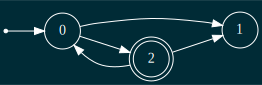

In [5]:
identifer = PartialDFAIdentifier(
    partial = PARTIAL_DFA,
    base_examples = BASE_EXAMPLES,
)
view_dfa(identifer(LabeledExamples()))

Now, we can outline the machinery for the search process itself. We use the solution procedure in the DFA identification algorithm to synthesize a minimal DFA (in both states and non-stuttering edges) that is consistent with the observed examples to this point. 

# Simulated Annealed + SGGS

In [6]:
from diss import diss

In [7]:
def lift_path(path):
    return ignore_white(map(gw.sensor, path))

In [8]:
class ProductMC2(ProductMC):
    def sample(self, pivot, win, attempts=20):
        # Sample until you give a path that respects subset properties.
        for i in range(attempts):
            result = ProductMC.sample(self, pivot, win)
            if win or (result is None):
                return result

            # Don't let conjecture violate subset constraint.
            word = lift_path(result[0])
            if ('yellow' in word) and ('red' not in word):
                return result

In [9]:
@fn.memoize(key_func=lambda c, t, psat: c.dfa)
def to_chain(c, t, psat):
    chain = ProductMC.construct(
        concept=c, tree=t, dyn=gw, max_depth=9,
        psat=0.8, sensor=gw.sensor, xtol=0.05
    )
    return ProductMC2(chain.tree, chain.concept, chain.policy, chain.tree2policy)

In [10]:
test_words = LabeledExamples(
    positive=[
        ('blue', 'green', 'yellow'),
        ('green', 'yellow'),
    ],
    negative=[
        ('green', 'blue', 'yellow'),
        ('blue', 'yellow'),
    ]
)

In [11]:
def brier_score(concept2energy):
    pmf = np.array([np.exp(-u) for u in concept2energy.values()])
    pmf /= pmf.sum()
    
    p_accept, bs = {}, 0
    for word in test_words.unlabeled:
        oracle_lbl = word in test_words.positive
        votes = np.array([(word in c) for c in concept2energy])
        p_accept[word] = pmf @ votes
        print(word, p_accept[word])
        bs += (oracle_lbl - p_accept[word])**2
    return bs / test_words.size

In [12]:
def analyze(search, n_iters):
    concept2energy = {}    # Explored concepts + associated energy
    partial_masses = []
    median_energies = []
    min_energies = []
    brier_scores = []
    # Run Search and collect concepts, energy, and POI.
    for _, (data, concept, metadata) in zip(trange(n_iters, desc='DISS'), search):
        pprint(metadata)
        concept2energy[concept] = metadata['energy']
        view_dfa(concept)
        energies = list(concept2energy.values())
        partial_masses.append(sum(np.exp(-x) for x in energies))  # Record unormalized mass
        
        median_energies.append(np.median(energies))
        min_energies.append(np.min(energies))

        brier_scores.append(brier_score(concept2energy))
        
    for c in sorted(concept2energy, key=concept2energy.get):
        print('energy', concept2energy[c])
        view_dfa(c)
    
    return pd.DataFrame(data={
        'probability mass explored': partial_masses,
        'median energies': median_energies,
        'min energies': min_energies,
        'brier score': brier_scores,
        'iteration': list(range(1, len(brier_scores) + 1)),
    })

DISS:   0%|          | 0/20 [00:00<?, ?it/s]

{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: set()
--------------
-: set(),
 'energy': 45.21328423510165,
 'grad': array([ 0.22656598, -0.2194858 ,  0.50003425, -0.01584733,  0.45171271,
       -0.02946812,  0.06463205, -0.03056699, -0.94757677]),
 'pivot': 8,
 'surprisal': 4.521328423510165}


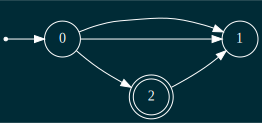

('green', 'yellow') 0.0
('green', 'blue', 'yellow') 0.0
('blue', 'yellow') 1.0
('blue', 'green', 'yellow') 0.0
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'energy': 18.460439695801277,
 'grad': array([ 0.26168225, -0.25350468,  0.40478271, -0.01290501,  0.35267903,
       -0.02352295,  0.03868432, -0.02399674, -0.74389893]),
 'pivot': 0,
 'surprisal': 1.8683583247115487}


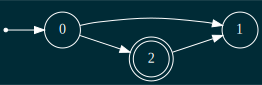

('green', 'yellow') 0.9999999999975936
('green', 'blue', 'yellow') 0.9999999999975936
('blue', 'yellow') 1.0
('blue', 'green', 'yellow') 0.9999999999975936
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 11.020660847036153,
 'grad': array([ 0.16753474, -0.16229928,  0.30666949, -0.00974703,  0.22394392,
       -0.01644068,  0.05375772, -0.01760684, -0.54581204]),
 'pivot': 0,
 'surprisal': 1.0550657217790418}


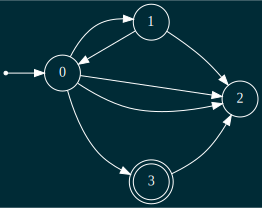

('green', 'yellow') 0.0005870702368386918
('green', 'blue', 'yellow') 0.0005870702368386918
('blue', 'yellow') 0.0005870702368401046
('blue', 'green', 'yellow') 0.9999999999999984
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 35.97422610829098,
 'grad': array([ 0.08786298, -0.08511726,  0.50284363, -0.01579967,  0.38371888,
       -0.02729714,  0.11492505, -0.03003551, -0.93110096]),
 'pivot': 8,
 'surprisal': 3.563775387166977}


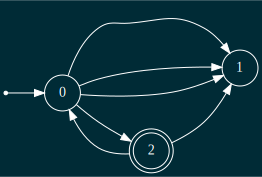

('green', 'yellow') 0.000587070236830156
('green', 'blue', 'yellow') 0.000587070236830156
('blue', 'yellow') 0.0005870702368315689
('blue', 'green', 'yellow') 0.9999999999854589
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 11.55072418901861,
 'grad': array([ 0.16478443, -0.15963492,  0.32110956, -0.0101956 ,  0.23522097,
       -0.01722764,  0.05685667, -0.01846605, -0.57244743]),
 'pivot': 0,
 'surprisal': 1.1214251952397398}


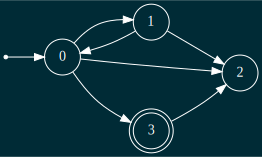

('green', 'yellow') 0.3707348021571953
('green', 'blue', 'yellow') 0.00036963987329450724
('blue', 'yellow') 0.0003696398732953968
('blue', 'green', 'yellow') 0.9999999999908443
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 11.684255581643132,
 'grad': array([ 0.16478443, -0.15963492,  0.32110956, -0.0101956 ,  0.23522097,
       -0.01722764,  0.05685667, -0.01846605, -0.57244743]),
 'pivot': 0,
 'surprisal': 1.1214251952397398}


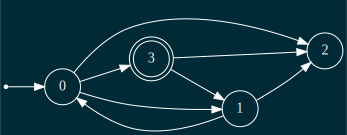

('green', 'yellow') 0.5247491239966678
('green', 'blue', 'yellow') 0.0002791695364548976
('blue', 'yellow') 0.00027916953645556943
('blue', 'green', 'yellow') 0.9999999999930852
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 35.8104994972925,
 'grad': array([ 0.08698911, -0.0842707 ,  0.5028574 , -0.01579924,  0.38372874,
       -0.02729704,  0.11492741, -0.03003549, -0.93110019]),
 'pivot': 8,
 'surprisal': 3.5628177940498547}


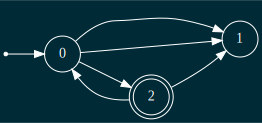

('green', 'yellow') 0.5247491240005383
('green', 'blue', 'yellow') 0.0002791695364526241
('blue', 'yellow') 0.0002791695364532959
('blue', 'green', 'yellow') 0.9999999999849414
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 11.55072418901861,
 'grad': array([ 0.16478443, -0.15963492,  0.32110956, -0.0101956 ,  0.23522097,
       -0.01722764,  0.05685667, -0.01846605, -0.57244743]),
 'pivot': 0,
 'surprisal': 1.1214251952397398}


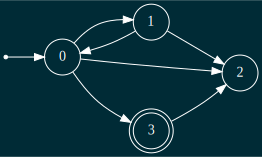

('green', 'yellow') 0.5247491240005383
('green', 'blue', 'yellow') 0.0002791695364526241
('blue', 'yellow') 0.0002791695364532959
('blue', 'green', 'yellow') 0.9999999999849414
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 35.86547245625292,
 'grad': array([ 0.07788902, -0.07545499,  0.50300079, -0.01579484,  0.38383146,
       -0.02729598,  0.11495192, -0.03003523, -0.93109216]),
 'pivot': 8,
 'surprisal': 3.5529000219631706}


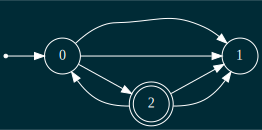

('green', 'yellow') 0.5247491240042017
('green', 'blue', 'yellow') 0.0002791695364504722
('blue', 'yellow') 0.00027916953645114404
('blue', 'green', 'yellow') 0.9999999999772333
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 11.55072418901861,
 'grad': array([ 0.16478443, -0.15963492,  0.32110956, -0.0101956 ,  0.23522097,
       -0.01722764,  0.05685667, -0.01846605, -0.57244743]),
 'pivot': 0,
 'surprisal': 1.1214251952397398}


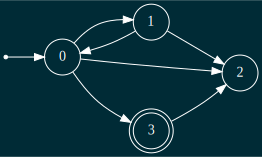

('green', 'yellow') 0.5247491240042017
('green', 'blue', 'yellow') 0.0002791695364504722
('blue', 'yellow') 0.00027916953645114404
('blue', 'green', 'yellow') 0.9999999999772333
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 9.550898908314192,
 'grad': array([ 0.17771622, -0.17216259,  0.26945697, -0.00859408,  0.19517459,
       -0.01442472,  0.04609794, -0.01541451, -0.47784982]),
 'pivot': 0,
 'surprisal': 0.9080895279068457}


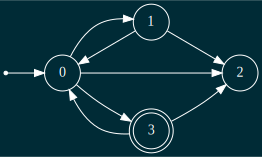

('green', 'yellow') 0.8450177477724804
('green', 'blue', 'yellow') 9.103891375634066e-05
('blue', 'yellow') 9.103891375655975e-05
('blue', 'green', 'yellow') 0.9999999999925757
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 35.907918628303875,
 'grad': array([ 0.0958404 , -0.09284538,  0.50271793, -0.01580353,  0.38362883,
       -0.02729807,  0.11490356, -0.03003574, -0.931108  ]),
 'pivot': 8,
 'surprisal': 3.5725597071509925}


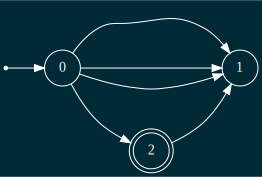

('green', 'yellow') 0.8450177477704446
('green', 'blue', 'yellow') 9.103891375612132e-05
('blue', 'yellow') 9.103891375634041e-05
('blue', 'green', 'yellow') 0.9999999999901664
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 11.802038617299516,
 'grad': array([ 0.16478443, -0.15963492,  0.32110956, -0.0101956 ,  0.23522097,
       -0.01722764,  0.05685667, -0.01846605, -0.57244743]),
 'pivot': 0,
 'surprisal': 1.1214251952397398}


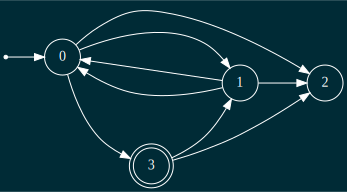

('green', 'yellow') 0.8552848505896894
('green', 'blue', 'yellow') 8.500786262194364e-05
('blue', 'yellow') 8.500786262214821e-05
('blue', 'green', 'yellow') 0.9999999999908177
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 8.513099539655096,
 'grad': array([ 0.18442877, -0.17866537,  0.23939327, -0.00766115,  0.17222287,
       -0.0128037 ,  0.0401925 , -0.0136596 , -0.42344759]),
 'pivot': 0,
 'surprisal': 0.8043095910409361}


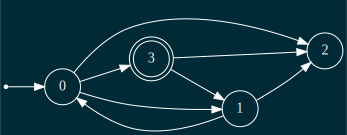

('green', 'yellow') 0.9478761763786054
('green', 'blue', 'yellow') 3.061832058214522e-05
('blue', 'yellow') 3.0618320582218904e-05
('blue', 'green', 'yellow') 0.9999999999966929
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 35.749129894958024,
 'grad': array([ 0.09796564, -0.09490421,  0.50268444, -0.01580456,  0.38360484,
       -0.02729832,  0.11489784, -0.0300358 , -0.93110987]),
 'pivot': 8,
 'surprisal': 3.5749129894958025}


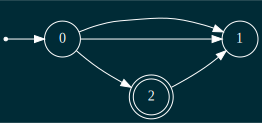

('green', 'yellow') 0.9478761763786548
('green', 'blue', 'yellow') 3.0618320582116135e-05
('blue', 'yellow') 3.061832058218982e-05
('blue', 'green', 'yellow') 0.999999999995743
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 11.55072418901861,
 'grad': array([ 0.16478443, -0.15963492,  0.32110956, -0.0101956 ,  0.23522097,
       -0.01722764,  0.05685667, -0.01846605, -0.57244743]),
 'pivot': 0,
 'surprisal': 1.1214251952397398}


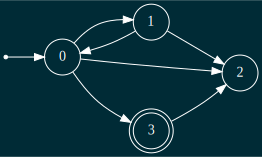

('green', 'yellow') 0.9478761763786548
('green', 'blue', 'yellow') 3.0618320582116135e-05
('blue', 'yellow') 3.061832058218982e-05
('blue', 'green', 'yellow') 0.999999999995743
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 35.907918628303875,
 'grad': array([ 0.0958404 , -0.09284538,  0.50271793, -0.01580353,  0.38362883,
       -0.02729807,  0.11490356, -0.03003574, -0.931108  ]),
 'pivot': 8,
 'surprisal': 3.5725597071509925}


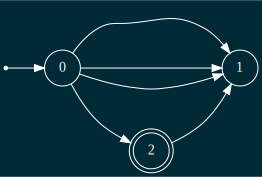

('green', 'yellow') 0.9478761763786548
('green', 'blue', 'yellow') 3.0618320582116135e-05
('blue', 'yellow') 3.061832058218982e-05
('blue', 'green', 'yellow') 0.999999999995743
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 11.684255581643132,
 'grad': array([ 0.16478443, -0.15963492,  0.32110956, -0.0101956 ,  0.23522097,
       -0.01722764,  0.05685667, -0.01846605, -0.57244743]),
 'pivot': 0,
 'surprisal': 1.1214251952397398}


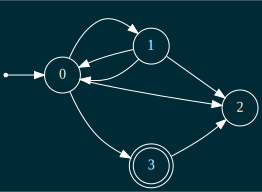

('green', 'yellow') 0.9492387899232572
('green', 'blue', 'yellow') 2.981790082317345e-05
('blue', 'yellow') 2.9817900823245207e-05
('blue', 'green', 'yellow') 0.9999999999958542
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 35.749129894958024,
 'grad': array([ 0.09796564, -0.09490421,  0.50268444, -0.01580456,  0.38360484,
       -0.02729832,  0.11489784, -0.0300358 , -0.93110987]),
 'pivot': 8,
 'surprisal': 3.5749129894958025}


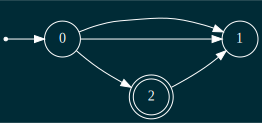

('green', 'yellow') 0.9492387899232572
('green', 'blue', 'yellow') 2.981790082317345e-05
('blue', 'yellow') 2.9817900823245207e-05
('blue', 'green', 'yellow') 0.9999999999958542
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 11.684255581643132,
 'grad': array([ 0.16478443, -0.15963492,  0.32110956, -0.0101956 ,  0.23522097,
       -0.01722764,  0.05685667, -0.01846605, -0.57244743]),
 'pivot': 0,
 'surprisal': 1.1214251952397398}


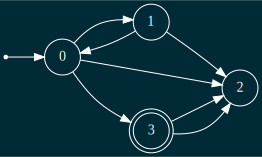

('green', 'yellow') 0.950531975935561
('green', 'blue', 'yellow') 2.9058263844415536e-05
('blue', 'yellow') 2.9058263844485463e-05
('blue', 'green', 'yellow') 0.9999999999959599
energy 8.513099539655096


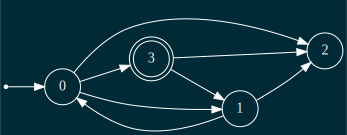

energy 9.550898908314192


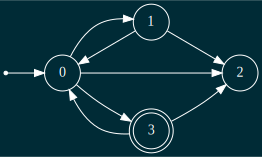

energy 11.020660847036153


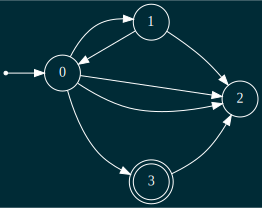

energy 11.55072418901861


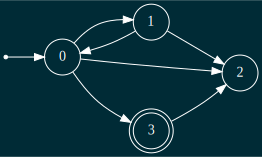

energy 11.684255581643132


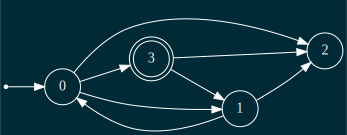

energy 11.684255581643132


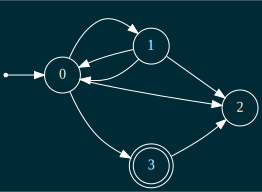

energy 11.684255581643132


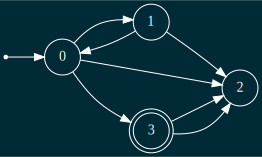

energy 11.802038617299516


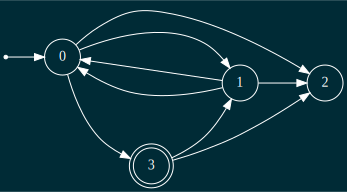

energy 18.460439695801277


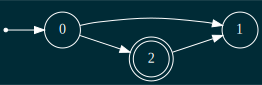

energy 35.749129894958024


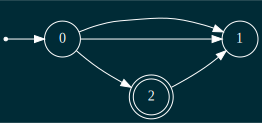

energy 35.8104994972925


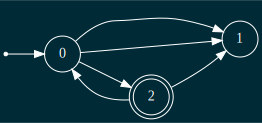

energy 35.86547245625292


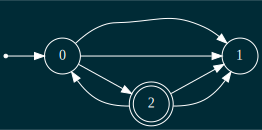

energy 35.907918628303875


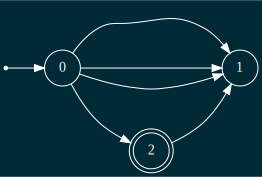

energy 35.97422610829098


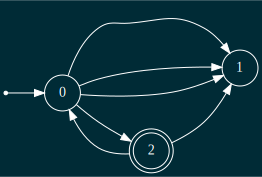

energy 45.21328423510165


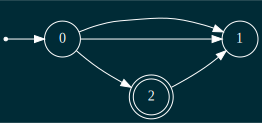

In [13]:
n_iters = 20

dfa_search = diss(
    demos=demos,
    to_concept=identifer,
    to_chain=to_chain,
    competency=lambda *_: 0.8,
    lift_path=lift_path,
    n_iters=n_iters,
    reset_period=5,
    surprise_weight=10,  # Rescale surprise to make comparable to size.
    sgs_temp=1/10,
    synth_timeout=3
)

df = analyze(dfa_search, n_iters)

<AxesSubplot:>

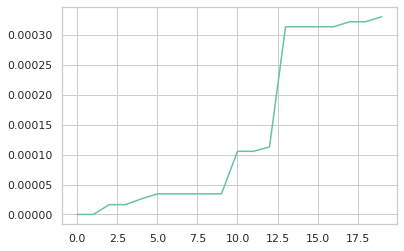

In [14]:
df['probability mass explored'].plot()

<AxesSubplot:>

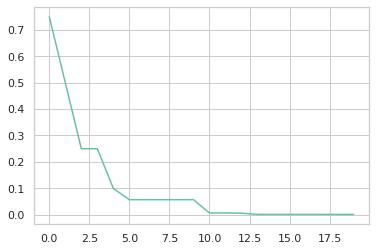

In [15]:
df['brier score'].plot()

# Circuit + BDD based MaxEnt Policy (CAV '20)

🚨 🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧 🚨

Everything after this point of the notebook is currently under development!

🚨 🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧 🚨 

# 1. Create Dynamical System

Here we create a BitVector sequential circuit, `DYN`, using `py-aiger`, the models a gridworld (line 4).

Afterwords, lines 6-8 describe introducing a slip probability of `1/32` (modeled by a biased coin with bias `31/32`). 

**Note that states are 1-hot encoded**

In [13]:
import aiger as A
import aiger_bv as BV
import aiger_gridworld as GW
import aiger_ptltl as LTL
from bidict import bidict
from aiger_bdd import to_bdd

In [14]:
STATE = BV.uatom(16, 'state')
X = STATE[:8]
Y = STATE[8:]
s0 = (3, 5)
#                            
DYN = GW.gridworld(8, start=(s0[0], 9 - s0[1]), compressed_inputs=True)
SLIP = BV.atom(1, 'c', signed=False).repeat(2) & BV.atom(2, 'a', signed=False)
SLIP = SLIP.with_output('a').aigbv
DYN <<= SLIP

def encode_state(x, y):
    x, y = x - 1, (9 - y) + 7
    return {'state': (1 << x) | (1 << y)}

# 2. Create Sensor / Feature overlay

Next, we define the mapping from concrete states to sensor values / atomic predicates.
We use simple coordinate wise bitvector masks to encode the color overlays.

In [15]:
def mask_test(xmask, ymask):
    return ((X & xmask) !=0) & ((Y & ymask) != 0)


APS = {       #            x-axis       y-axis
    'yellow': mask_test(0b0000_0001, 0b1000_0000) \
            | mask_test(0b0000_0100, 0b0000_0001),
    'blue':   mask_test(0b0000_1010, 0b0011_1100),
    'green':  mask_test(0b0010_0000, 0b1000_0000) \
            | mask_test(0b0000_0001, 0b0000_0001),
    'red':    mask_test(0b1000_0000, 0b0011_0010) \
            | mask_test(0b0000_0111, 0b0000_0010)
}

def create_sensor(aps):
    sensor = BV.aig2aigbv(A.empty())
    for name, ap in APS.items():
        sensor |= ap.with_output(name).aigbv
    aps = reduce(lambda x, y: x.concat(y), APS.values())
    sensor |= (aps == 0).with_output('white').aigbv
    return sensor

SENSOR = create_sensor(APS)

In [16]:
SENSOR.outputs

{'blue', 'green', 'red', 'white', 'yellow'}

## Visualizing Overlay

This can all seem pretty abstract, so let's visualize the way the sensor sees the board.

In [17]:
from IPython.display import HTML as html_print


def tile(color='black'):
    color = COLOR_ALIAS.get(color, color)
    s = '&nbsp;'*4
    return f"<text style='border: solid 1px;background-color:{color}'>{s}</text>"


def ap_at_state(x, y, in_ascii=False):
    """Use sensor to create colored tile."""
    state = encode_state(x, y)
    obs = SENSOR(state)[0]   # <----------   
    for k in COLOR_ALIAS.keys():
        if k == 'brown':
            continue
        if obs[k][0]:
            return tile(k)
    raise NotImplementedError

def print_map():
    """Scan the board row by row and print colored tiles."""
    order = range(1, 9)
    buffer = ''
    for y in order:
        chars = (ap_at_state(x, y, in_ascii=True) for x in order)
        buffer += '&nbsp;'.join(chars) + '<br>'
    display(html_print(buffer))
    
DYN_SENSE = DYN >> SENSOR

def encode_trace(trc):
    actions, states = trc
    actions = [{'a': a} for a in actions]
    states = [encode_state(*s) for s in states]

    # Fill in coin flips to mark slipping. Could use SAT solver more generally.
    for s, a, s2 in zip([encode_state(*s0)] + states, actions, states):
        s, s2 = GW.GridState(s['state'], 8), GW.GridState(s2['state'], 8)
        action = a['a']
        print(s.x, s.y)
        print(s2.x, s2.y)

        if action == GW.WEST:
            a['c'] = 1
        elif action == GW.EAST:
            a['c'] = int((s2.x > s.x) or s.x == 8)
        else:
            a['c'] = int(s.x == s2.x)
    actions[-1]['c'] = 1  # Last action needs some arbitrary assignment to slipping.
    
    return actions, states


def lift_path(path):
    aps = fn.pluck(0, DYN_SENSE.simulate(path))
    aps = [fn.first(k for k, v in ap.items() if v == 1) for ap in aps]
    print(ignore_white(aps))
    return ignore_white(aps)


def print_trc(trc, idx=0):
    obs = lift_path(trc)
    actions = [x['a'] for x in trc]
    obs = map(tile, obs)
    display(
        html_print(f'trc {idx}:&nbsp;&nbsp;&nbsp;' + ''.join(''.join(x) for x in zip(actions, obs)) + '\n')
    )
        
print_map()

TRC4 = [
    {'a': '↑', 'c': 0},
    {'a': '↑', 'c': 1},
    {'a': '↑', 'c': 1},
    {'a': '→', 'c': 1},
    {'a': '↑', 'c': 1},
    {'a': '↑', 'c': 1},
    {'a': '→', 'c': 1},
    {'a': '→', 'c': 1},
    {'a': '→', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1},
]

TRC5 = [
    {'a': '↑', 'c': 1},
    {'a': '↑', 'c': 1},
    {'a': '↑', 'c': 1},
    {'a': '↑', 'c': 1},
    {'a': '↑', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1},
]

print(len(TRC4))

print_trc(TRC4, 4)
print_trc(TRC5, 5)

14
('blue', 'blue', 'blue', 'green', 'yellow')


('yellow', 'yellow')


# 4. Define Specification Circuits / Concept Class



In [18]:
import aiger_dfa

In [115]:
from dfa import DFA, dfa2dict, dict2dfa
from functools import reduce

def concept2monitor(concept):
    # Add noop on white:
    def transition_with_noop(s, c):
        if c == 'white':
            return s
        return concept.dfa._transition(s, c)
    
    dfa = DFA(
        start=concept.dfa.start,
        outputs=concept.dfa.outputs,
        inputs=COLOR_ALIAS,
        label=concept.dfa._label,
        transition=transition_with_noop,
    )
    dfa = attr.evolve(
        concept.dfa,
        transition=transition_with_noop,
        inputs=frozenset(COLOR_ALIAS),
        outputs=frozenset({True, False}),
    )
    circ, relabels, _ = aiger_dfa.dfa2aig(dfa)
    # Wrap circ i/o to interface with sensor.
    atoms = [BV.uatom(1, c) for c in COLOR_ALIAS]

    # Convert input.
    def get_idx(atom):
        c = fn.first(atom.inputs)
        return relabels['inputs'][c]['action'].index(True)

    atoms = sorted(atoms, key=get_idx)
    action = reduce(lambda x, y: x.concat(y), atoms).with_output('action')
    
    # Convert output.
    output = BV.uatom(2, 'output')
    for key, val in relabels['outputs'].items():
        if val is True:
            sat = output[key['output'].index(True)].with_output('SAT')
    monitor = action.aigbv >> circ >> sat.aigbv
    monitor = attr.evolve(monitor, aig=monitor.aig.lazy_aig)  # HACK: force lazy evaluation.
    return DYN >> SENSOR >> monitor, relabels

# Creating BDD game-graph

In [116]:
H = 15  # SAT output only depends on latch....
causal_order = []
for t in range(H):
    causal_order.append(f'a##time_{t}[0]')
    causal_order.append(f'a##time_{t}[1]')
    causal_order.append(f'c##time_{t}[0]')
causal_order = {x: i for i, x in enumerate(causal_order)}

In [117]:
from dd.cudd import BDD

In [118]:
manager = BDD()
manager.declare(*causal_order)

In [119]:
import networkx as nx

In [120]:
def to_nx(bexpr):
    # DFS to translate edge-compelemented BDD to networkx graph.
    dag = nx.DiGraph()

    stack, visited = [(bexpr, False, int(bexpr))], set()
    while stack:
        bexpr, parity, ref = stack.pop()

        if ref in visited:
            continue

        visited.add(ref)
        if bexpr in (bexpr.bdd.true, bexpr.bdd.false):
            label = (bexpr == bexpr.bdd.true) ^ parity
            dag.add_node(ref, label=label, level=len(bexpr.bdd.vars))
            continue

        dag.add_node(ref, label=bexpr.var, level=bexpr.level)

        parity = bexpr.negated ^ parity
        for lbl, bexpr2 in [(0, bexpr.low), (1, bexpr.high)]:
            ref2 = int(bexpr2 if parity else ~bexpr2)
            dag.add_edge(ref, ref2, label=lbl)
            stack.append((bexpr2, parity, ref2))
            
    #TODO: Everything above this line should be upstreamed into aiger-bdd.
            
    for src, data in dag.nodes(data=True):
        label = data['label']
        if isinstance(label, bool):
            data['kind'] = label
        elif label.startswith('a'):
            data['kind'] = 'ego'
        else:
            data['kind'] = 'env'

    for src, tgt, data in dag.edges(data=True):
        entropy = dag.nodes[tgt]['level'] - dag.nodes[src]['level'] - 1
        entropy /= np.log2(np.e)  # Convert from base 2.
        data['entropy'] = entropy
    
        if dag.nodes[src]['kind'] == 'env':
            data['prob'] = 31/32 if data['label'] else 1/32
    return dag

# Create Tabular Policy from BDD

1. Create policy on BDD Game graph.
2. Lift bit level policy into policy over ego and env actions (at bitvectors)

In [121]:
from diss import DemoPrefixTree as PrefixTree

In [122]:
from diss.planners.tabular import TabularPolicy

In [123]:
import dd.cudd

In [124]:
def to_demo(trc):
    demo = [(None, 'ego')]
    for circ_input in trc:
        demo.extend([
            (circ_input['a'], 'env'),
            (circ_input['c'], 'ego'),
        ])
    return demo

In [125]:
tree = PrefixTree.from_demos([to_demo(TRC4)])

In [126]:
#               bdd-id    lvl   prev action  
# Node = tuple[  int  ,   int,  int | str]   # Lifted policy state.

def get_lvl(dag, node):
    label = dag.nodes[node]['label']
    if isinstance(label, bool):
        return len(causal_order)
    return causal_order[label]

def get_debt(dag, node1, node2):
    lvl1 = get_lvl(dag, node1)
    lvl2 = get_lvl(dag, node2)
    return lvl2 - lvl1 - 1

def walk(dag, curr, bits):
    for bit in bits:
        yield curr
        node, debt = curr
        if debt > 0:  # Don't care consumes bits.
            curr = (node, debt - 1)
            continue
        # Use bit for BDD transition.
        if dag.out_degree(node) == 0:
            import pdb; pdb.set_trace()
            break
        for kid in dag.neighbors(node):
            if bit == dag.edges[node, kid]['label']:
                break
        curr = (kid, get_debt(dag, node, kid))
    yield curr


@attr.frozen
class LiftedPolicy:
    policy: TabularPolicy

    def psat(self, node = None): return self.policy.psat(node[0])
    def lsat(self, node = None): return self.policy.lsat(node[0])
        
    @property
    def root(self):
        dag, root = self.policy.dag, self.policy.root
        return (root, get_lvl(dag, root), None)

    @staticmethod
    def from_psat(unrolled, psat, xtol=0.5):
        return LiftedPolicy(TabularPolicy.from_psat(unrolled, psat, xtol=xtol))

    def prob(self, node, move, log = False):
        dag = self.policy.dag
        node1, debt1, _ = node 
        node2, debt2, action = move
        assert (node1 != node2) or (debt1 > debt2 >= 0)

        if isinstance(action, int):
            prob = 31 / 32 if action else 1/32
            return np.log(prob) if log else prob

        action = GW.dynamics.ACTIONS_C[action]
        bits = [action & 1, (action >> 1) & 1]
        curr = (node1, debt1)
        edges = fn.pairwise(walk(dag, (node1, debt1), bits))
        
        logp = 0
        for start, end in edges:
            if start[0] == end[0]:  # Don't care consumes bits.
                logp -= np.log(2)
            else:
                logp += self.policy.prob(start[0], end[0], log=True)

        assert end == (node2, debt2)
        return logp if log else np.exp(logp)

    def transition(self, pstate, action):
        dag = self.policy.dag
        if isinstance(action, str):  # action correspond to previous action.
            bits = GW.dynamics.ACTIONS_C[action]
            bits = [bits & 1, (bits >> 1) & 1]
        else:
            bits = [action]
        node, debt = fn.last(walk(dag, pstate[:2], bits))  # QDD state.
        return (node, debt, action)

    def end_of_episode(self, pstate):
        node, debt, _ = pstate
        dag = self.policy.dag
        return (debt == 0) and (dag.out_degree(node) == 0)

In [127]:
def dont_count(aps):
    for curr, prev in fn.with_prev(aps):
        if curr == prev:
            continue
        yield curr

In [128]:
def lift_path(path):
    assert path[0] is None
    path = path[1:]
    path = [{'a': a, 'c': c} for a, c in fn.chunks(2, path)]
    aps = fn.pluck(0, DYN_SENSE.simulate(path))
    aps = [fn.first(k for k, v in ap.items() if v == 1) for ap in aps]
    aps = list(ignore_white(aps))
    aps = list(dont_count(aps))
    return tuple(aps)

In [129]:
import random

@attr.frozen
class CompressedMC:
    """Compressed Markov Chain operating with actions."""
    tree: PrefixTree
    policy: LiftedPolicy
    tree2policy: dict[int, tuple[int, int]]

    @property
    def edge_probs(self):
        edge_probs = {}
        for tree_edge in self.tree.tree.edges:
            dag_edge = [self.tree2policy[s] for s in tree_edge]
            edge_probs[tree_edge] = self.policy.prob(*dag_edge)
        return edge_probs
    
    def sample(self, pivot, win, attempts=20):
        # Sample until you give a path that respects subset properties.
        for i in range(attempts):
            result = self._sample(pivot, win)
            if result is None:
                return result
            word = lift_path(result[0])
            return result  # Remove to allow violations of subset in sample.
            if (not win) and (('red' in word) or ('yellow' not in word)):
                continue
            return result

    def _sample(self, pivot, win):
        policy = self.policy
        state = self.tree2policy[pivot]

        if policy.psat(state) == float(not win):
            return None  # Impossible to realize is_sat label.

        sample_prob: float = 1
        path = list(self.tree.prefix(pivot))
        if policy.end_of_episode(state):
             moves = []
        else:
            prev_ego = isinstance(state[-1], str)

            # Make sure to deviate from prefix tree at pivot.
            actions = {0, 1} if prev_ego else set(GW.dynamics.ACTIONS_C)
            actions -= {self.tree2policy[s][-1] for s in self.tree.tree.neighbors(pivot)}

            tmp = {policy.transition(state, a) for a in actions}

            moves = list(m for m in tmp if policy.psat(m) != float(not win))

        if not moves:
            return None  # Couldn't deviate
        
        # Sample suffix to path conditioned on win.
        while moves:
            # Apply bayes rule to get Pr(s' | is_sat, s).
            priors = np.array([policy.prob(state, m) for m in moves])
            likelihoods = np.array([policy.psat(m) for m in moves])
            normalizer = policy.psat(state)

            if not win:
                likelihoods = 1 - likelihoods
                normalizer = 1 - normalizer

            probs =  priors * likelihoods / normalizer
            prob, state = random.choices(list(zip(probs, moves)), probs)[0]
            sample_prob *= prob

            # Note: win/lose are strings so the below still works...
            action = state[-1]
            path.append(action)

            if policy.end_of_episode(state):
                moves = []
            else:
                prev_ego = isinstance(action, str)
                actions = {0, 1} if prev_ego else set(GW.dynamics.ACTIONS_C)
                moves = [policy.transition(state, a) for a in actions]

        return path, sample_prob
 
    @staticmethod
    def construct(concept, tree, psat):
        # 1. Compile concept: DFA -> AIG -> BDD -> Annotated DAG.
        monitor, _ = concept2monitor(concept)
        unrolled = monitor.aigbv.cone('SAT').unroll(H, only_last_outputs=True)
        manager = BDD()
        manager.declare(*causal_order)
        bexpr, *_ = to_bdd(unrolled, manager=manager, renamer=lambda _, x: x, levels=causal_order)
        dag = to_nx(bexpr)
        
        # 2. Fit (lifted) MaxEntPolicy.
        policy = LiftedPolicy.from_psat(dag, psat=psat)
        
        # 3. Need to associcate each tree stree with a policy state.
        stack = [(tree.root, policy.root)]
        tree2policy = {}
        while stack:
            tstate, pstate = stack.pop()
            tree2policy[tstate] = pstate

            # Compute local mapping from dynamics transition to next pstate.
            #move = {s[0]: s for s in policy.dag.neighbors(pstate)}
            for tstate2 in tree.tree.neighbors(tstate):
                action = tree.state(tstate2)  # tree states are next actions.
                pstate2 = policy.transition(pstate, action)
                stack.append((tstate2, pstate2))
        return CompressedMC(tree, policy, tree2policy)

# DISS + BDD

In [130]:
env_yellow = dfa.DFA(
    start=False,
    inputs={'blue', 'green', 'red', 'yellow'},
    outputs={True, False},
    label=lambda s: s,
    transition=lambda s, c: s | (c == 'yellow'),
)

In [131]:
universal = dfa.DFA(
    start=True,
    inputs={'blue', 'green', 'red', 'yellow'},
    outputs={True, False},
    label=lambda s: s,
    transition=lambda s, c: True,
)

DFAConcept.from_dfa(universal).size

0.0

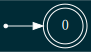

In [132]:
@fn.memoize(key_func=lambda c, t, psat: c.dfa)
def to_chain(c, t, psat):
    return CompressedMC.construct(concept=c, tree=t, psat=psat)

identifer = PartialDFAIdentifier(
    #partial = PARTIAL_DFA,
    #base_examples = BASE_EXAMPLES,
    base_examples = LabeledExamples(negative=[], positive=[]),
    partial = universal,
)

view_dfa(identifer(LabeledExamples()))

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

{'conjecture': +: set()
--------------
-: {('blue',)},
 'data': +: set()
--------------
-: set(),
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0.03085302, -0.03092861, -0.95878705]),
 'pivot': 0,
 'surprisal': 30.498475944637594}


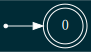

('green', 'blue', 'yellow') 1.0
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue',)},
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0.03085302, -0.03092861, -0.95878705]),
 'pivot': 28,
 'surprisal': 30.498475944637594}


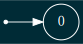

('green', 'blue', 'yellow') 0.5
('green', 'yellow') 0.5
('blue', 'green', 'yellow') 0.5
('blue', 'yellow') 0.5
{'conjecture': +: set()
--------------
-: {('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',)},
 'energy': 32.93882536544495,
 'grad': array([ 1.82216891,  0.        ,  0.86342555, -0.02876151,  0.08704962,
       -0.03058301,  0.04249801, -0.03095536,  0.03128032, -0.03096551,
        0.0314742 , -0.03098141,  0.03136329, -0.03099334,  0.02279482,
       -0.03073714,  0.01410559, -0.0302174 ,  0.04744537, -0.03075578,
        0.03492818, -0.03088616,  0.03189667, -0.03091774,  0.03116247,
       -0.03092539,  0.03098466, -0.03092724, -0.95874454, -0.61434639,
       -0.03596499, -0.08725395, -0.0321144 ,  0.00342312, -0.0312178 ,
        0.02640504, -0.0310674 ,  0.02156818, -0.03077055,  0.023513  ,
       -0.03054375,  0.03421733, -0.03065855, -0.95041502]),
 'pivot': 0,
 'surprisal': 32.2

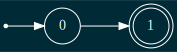

('green', 'blue', 'yellow') 0.5208732527988773
('green', 'yellow') 0.5208732527988773
('blue', 'green', 'yellow') 0.5208732527988773
('blue', 'yellow') 0.47912674720112275
{'conjecture': +: set()
--------------
-: {('red', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',), ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red')},
 'energy': 29.89759972251682,
 'grad': array([ 1.75462351,  0.        ,  0.73608057, -0.02471602,  0.13258631,
       -0.02808696,  0.11847809, -0.03091169,  0.02704298, -0.03079079,
        0.03170447, -0.03081934,  0.04199009, -0.03116843,  0.02952635,
       -0.03111711,  0.02668276, -0.03097854,  0.0292518 , -0.03092458,
        0.02933128, -0.03087479,  0.02705725, -0.03075549,  0.02191566,
       -0.03047925,  0.01599322, -0.03002656, -0.93082328, -0.45355688,
       -0.03894483, -0.12613039, -0.03378623, -0.03241774, -0.03171736,
        0.0145721 , -0.03118157,  0.00809206, -0.03046002,  0.01215914,
       -0.02

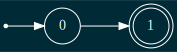

('green', 'blue', 'yellow') 0.7443008809874929
('green', 'yellow') 0.7443008809874929
('blue', 'green', 'yellow') 0.7443008809874929
('blue', 'yellow') 0.7220217142209677
{'conjecture': +: set()
--------------
-: {('blue', 'red', 'yellow', 'green')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('red', 'yellow')},
 'energy': 30.694303092639128,
 'grad': array([ 1.75401213,  0.        ,  0.84168506, -0.02801556,  0.11094067,
       -0.03060697,  0.04047141, -0.03091523,  0.03136274, -0.03092922,
        0.03131395, -0.03094124,  0.02301519, -0.03069355,  0.0185841 ,
       -0.03031513,  0.01924074, -0.02996906,  0.03316267, -0.03006886,
        0.04266859, -0.0304626 ,  0.04174457, -0.03081516,  0.03354751,
       -0.03090055,  0.03156229, -0.03092123, -0.95855801, -0.57194178,
       -0.0352268 , -0.06914056, -0.03196532,  0.00683693, -0.03118005,
        0.02740004, -0.03106193,  0.02763173, 

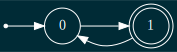

('green', 'blue', 'yellow') 0.788717551711315
('green', 'yellow') 0.788717551711315
('blue', 'green', 'yellow') 0.788717551711315
('blue', 'yellow') 0.5966016468392196
{'conjecture': +: set()
--------------
-: {('blue', 'red')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('red', 'yellow')},
 'energy': 31.23994665090918,
 'grad': array([ 1.68011681,  0.        ,  0.79647352, -0.02653054,  0.13743915,
       -0.02999643,  0.05893968, -0.03090091,  0.03130727, -0.03091361,
        0.03105992, -0.03091818,  0.03632823, -0.03108724,  0.03072932,
       -0.03107606,  0.02972577, -0.03103386,  0.02300262, -0.03078288,
        0.02945109, -0.03074127,  0.02956761, -0.03070459,  0.02502031,
       -0.03052696,  0.02438152, -0.03033491, -0.94038222, -0.49358579,
       -0.03543836, -0.07280633, -0.03205571,  0.00466026, -0.0311996 ,
        0.0268534 , -0.03106378,

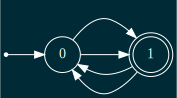

('green', 'blue', 'yellow') 0.808039812927013
('green', 'yellow') 0.808039812927013
('blue', 'green', 'yellow') 0.808039812927013
('blue', 'yellow') 0.6334933452121243
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('red', 'yellow')},
 'energy': 27.714338925371372,
 'grad': array([ 1.46407103,  0.        ,  0.68400271, -0.02280484,  0.18655971,
       -0.02792218,  0.11553377, -0.03066004,  0.03257181, -0.03071979,
        0.0338649 , -0.03081807,  0.04010153, -0.03110818,  0.03263196,
       -0.0311558 ,  0.03104305, -0.03115227,  0.01893344, -0.03077044,
        0.01837693, -0.03038314,  0.01769254, -0.02998656,  0.02130112,
       -0.02971514,  0.02989679, -0.02972081, -0.92134522, -0.26978344,
       -0.03589173, -0.0676882 , -0.03265486, -0.00886687, -0.0313573 ,
        0.

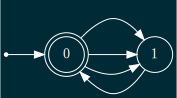

('green', 'blue', 'yellow') 0.9532606696597692
('green', 'yellow') 0.9532606696597692
('blue', 'green', 'yellow') 0.9532606696597692
('blue', 'yellow') 0.9107613100860847
{'conjecture': +: set()
--------------
-: {('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('red', 'yellow')},
 'energy': 29.72395713203743,
 'grad': array([ 1.50269841,  0.        ,  0.78221709, -0.02591176,  0.13773883,
       -0.02940636,  0.04376706, -0.02985513,  0.04712307, -0.03039475,
        0.04207997, -0.03075992,  0.00944665, -0.03009388,  0.01265733,
       -0.02954899,  0.01499219, -0.02909409,  0.07356251, -0.03048372,
        0.04125342, -0.03082028,  0.03342856, -0.03090179,  0.03153348,
       -0.03092153,  0.03107451, -0.03092631, -0.95871552, -0.26829799,
       -0.037

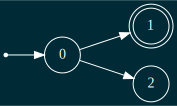

('green', 'blue', 'yellow') 0.9575638334550179
('green', 'yellow') 0.9575638334550179
('blue', 'green', 'yellow') 0.9575638334550179
('blue', 'yellow') 0.8269099783030454
{'conjecture': +: set()
--------------
-: {('blue', 'yellow', 'green', 'red', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow')},
 'energy': 28.03098545086575,
 'grad': array([ 1.52047714,  0.        ,  0.73425937, -0.02443045,  0.16321615,
       -0.0287675 ,  0.05464812, -0.02957627,  0.05350889, -0.03032416,
        0.04307763, -0.03072271,  0.01564921, -0.03025166,  0.02163175,
       -0.02998229,  0.02619346, -0.02986389,  0.04996547, -0.03049206,
        0.03308565, -0.03057311,  0.0289193 , -0.03052143,  0.03528972,
       -0.03067044,  0.034648

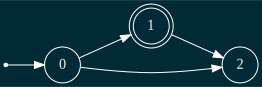

('green', 'blue', 'yellow') 0.6381878854458607
('green', 'yellow') 0.9717175540182484
('blue', 'green', 'yellow') 0.9717175540182484
('blue', 'yellow') 0.5511109673004302
{'conjecture': +: set()
--------------
-: {('blue', 'green')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'red', 'green', 'yellow'),
 ('red', 'yellow')},
 'energy': 28.902177225601097,
 'grad': array([ 1.15665464,  0.        ,  0.71190319, -0.02337652,  0.18171508,
       -0.0283246 ,  0.05510513, -0.02916149,  0.06003094, -0.03012616,
        0.04809147, -0.03068758,  0.00956422, -0.03002747,  0.01292036,
       -0.02949288,  0.01525742, -0.02904802,  0.07463359, -0.03047257,
        0.04151282, -0.03081757,  0.03349139, -0.03090113,  0.0315487 ,
       -

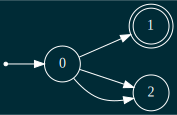

('green', 'blue', 'yellow') 0.6825001742580385
('green', 'yellow') 0.9751813957865171
('blue', 'green', 'yellow') 0.9751813957865171
('blue', 'yellow') 0.4836146415329269
{'conjecture': +: set()
--------------
-: {('blue', 'red', 'green', 'yellow', 'red')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow')},
 'energy': 29.830119470686807,
 'grad': array([ 1.8518665 ,  0.        ,  0.87989495, -0.02930518,  0.07843766,
       -0.03084057,  0.0352451 , -0.03097821,  0.02946305, -0.03093086,
        0.03118815, -0.0309389 ,  0.03497272, -0.03106496,  0.0277839 ,
       -0.03096243,  0.01627709, -0.03050351,  0.00635428, -0.02974885,
        0.00756761, -0.02905568,  0.00967531, -0.02845005,  0.0123643 ,
       -0.02794737,  0.01546243, -0.0275

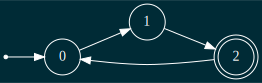

('green', 'blue', 'yellow') 0.6971640351703688
('green', 'yellow') 0.9763276532982312
('blue', 'green', 'yellow') 0.9763276532982312
('blue', 'yellow') 0.4612786990736424
{'conjecture': +: set()
--------------
-: {('blue', 'green')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow')},
 'energy': 27.873926474151283,
 'grad': array([ 1.33699435,  0.        ,  0.69565398, -0.02304485,  0.18677716,
       -0.02816148,  0.0605281 , -0.02917294,  0.06093397, -0.03016547,
        0.04692083, -0.03068907,  0.01368987, -0.03015785,  0.01879545,
       -0.02980277,  0.02249474, -0.0295744 ,  0.0388763 , -0.02986508,
        0.0466401 , -0.0303893 ,  0.04344873, -0.03079741,  0.03396024,
       -0.03089625, 

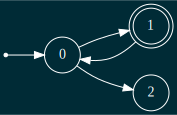

('green', 'blue', 'yellow') 0.7717270056054767
('green', 'yellow') 0.9821561568190947
('blue', 'green', 'yellow') 0.9821561568190947
('blue', 'yellow') 0.34770463920026334
{'conjecture': +: set()
--------------
-: {('red', 'yellow', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow')},
 'energy': 29.75075799186216,
 'grad': array([ 1.84163667,  0.        ,  0.87573436, -0.02916517,  0.08155695,
       -0.03080241,  0.03614635, -0.03096941,  0.02964728, -0.0309281 ,
        0.03125318, -0.03093826,  0.03498992, -0.03106487,  0.02778601,
       -0.03096241,  0.01627736, -0.0305035 ,  0.00635432, -0.02974884,
        0.00756765, -0.02905567,  0.00967533, -0.0284

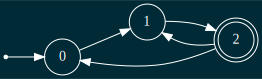

('green', 'blue', 'yellow') 0.7800179761460175
('green', 'yellow') 0.9828042526594956
('blue', 'green', 'yellow') 0.9828042526594956
('blue', 'yellow') 0.33507586141572865
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 26.05653426763384,
 'grad': array([ 1.18950697,  0.        ,  0.53174138, -0.01777855,  0.22204099,
       -0.02416175,  0.22968974, -0.0305845 ,  0.03042441, -0.03057949,
        0.03528629, -0.03072658,  0.04524483, -0.03118028,  0.03156732,
       -0.03119237,  0.0257371 , -0.03102189,  0.01935557, -0.03065732,
        0.02607178, -0.03051402,

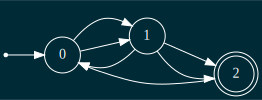

('green', 'blue', 'yellow') 0.9105982817130965
('green', 'yellow') 0.9930115682520995
('blue', 'green', 'yellow') 0.9930115682520995
('blue', 'yellow') 0.13617638951678424
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 25.73632004751039,
 'grad': array([ 1.16051276,  0.        ,  0.5179957 , -0.01732068,  0.22875185,
       -0.0239279 ,  0.2362835 , -0.03056402,  0.03083648, -0.03057253,
        0.0354448 , -0.03072479,  0.04529859, -0.03118022,  0.03174988,
       -0.03119802,  0.0286833 , -0.03111944,  0.02143827, -0.0308169 ,
        0.01700448, -0.03038526,

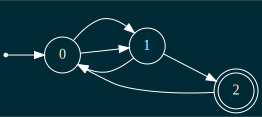

('green', 'blue', 'yellow') 0.9508141748238348
('green', 'yellow') 0.9961551993765407
('blue', 'green', 'yellow') 0.9961551993765407
('blue', 'yellow') 0.0749196795793031
{'conjecture': +: set()
--------------
-: {('blue', 'red', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 26.599728312786215,
 'grad': array([ 1.37697817,  0.        ,  0.63351216, -0.02114196,  0.20751374,
       -0.02696608,  0.14245621, -0.03057515,  0.03347203, -0.03066567,
        0.03470605, -0.03079193,  0.04158581, -0.03112924,  0.03259349,
       -0.031175  ,  0.02930622, -0.0311166 ,  0.02149166, -0.03081582,
        0.017017

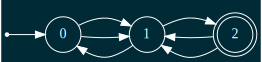

('green', 'blue', 'yellow') 0.9586571193077432
('green', 'yellow') 0.9967682735240924
('blue', 'green', 'yellow') 0.9967682735240924
('blue', 'yellow') 0.06297333354183923
{'conjecture': +: set()
--------------
-: {('blue', 'red', 'green', 'red', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 28.04130321696953,
 'grad': array([ 1.4513903 ,  0.        ,  0.68034573, -0.02267818,  0.18728491,
       -0.02782214,  0.11831558, -0.03065006,  0.03262049, -0.03071163,
        0.03411636, -0.03081803,  0.04032477, -0.03111512,  0.03246259,
       -0.03115723,  0.03030267, -0

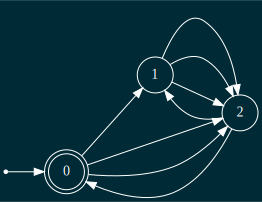

('green', 'blue', 'yellow') 0.960159886549223
('green', 'yellow') 0.9968857431488525
('blue', 'green', 'yellow') 0.9968857431488525
('blue', 'yellow') 0.06068432365310212
{'conjecture': +: set()
--------------
-: {('red', 'yellow', 'red', 'yellow', 'red')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 29.33160999379558,
 'grad': array([ 1.70276907,  0.        ,  0.83258208, -0.02768105,  0.11814675,
       -0.0305081 ,  0.04454544, -0.03094677,  0.03122115, -0.03095534,
        0.03077035, -0.03094956,  0.03344687, -0.0310276 ,  0.03

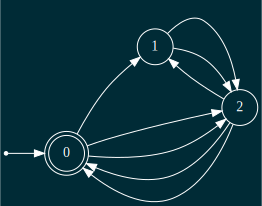

('green', 'blue', 'yellow') 0.950650798051832
('green', 'yellow') 0.9969165856620796
('blue', 'green', 'yellow') 0.9969165856620796
('blue', 'yellow') 0.06008332728561631
{'conjecture': +: set()
--------------
-: {('blue', 'red', 'green', 'yellow', 'red')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow'),
 ('red', 'yellow', 'red', 'yellow', 'red')},
 'energy': 25.984421268805498,
 'grad': array([ 1.58031365,  0.        ,  0.83497244, -0.02763616,  0.11746992,
       -0.03044347,  0.046531  , -0.0309462 ,  0.03146051, -0.03096228,
        0.03082035,

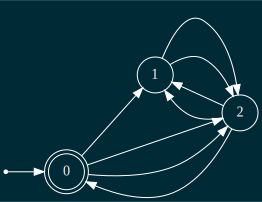

('green', 'blue', 'yellow') 0.961490723271009
('green', 'yellow') 0.9975938809277235
('blue', 'green', 'yellow') 0.9975938809277235
('blue', 'yellow') 0.04688557030102531
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow'),
 ('red', 'yellow', 'red', 'yellow', 'red')},
 'energy': 26.527256379746603,
 'grad': array([ 1.2574175 ,  0.        ,  0.5719876 , -0.01910256,  0.2181425 ,
       -0.02532256,  0.19244914, -0.03054526,  0.03168855, -0.03058099,
        0.03551318, -0.03073512,  0.044587

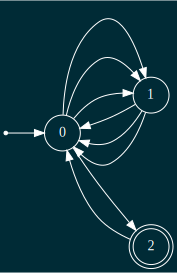

('green', 'blue', 'yellow') 0.8526555034891325
('green', 'yellow') 0.884671991349366
('blue', 'green', 'yellow') 0.9978662397677148
('blue', 'yellow') 0.0415783934091351
{'conjecture': +: set()
--------------
-: {('blue', 'yellow', 'blue')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 25.748508521372838,
 'grad': array([ 1.16405725,  0.        ,  0.51926422, -0.01736378,  0.22814855,
       -0.02395081,  0.23563366, -0.03056589,  0.03080273, -0.0305733 ,
        0.03542871, -0.03072503,  0.04529153, -0.03118023,  0.03174956,
       -0.03119802,  0.02868329, -0.03111944,  0.02143827, -0.0308169 ,
        0.01700448, -0.03

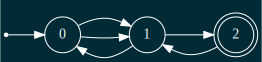

('green', 'blue', 'yellow') 0.881804908747494
('green', 'yellow') 0.9074875219012601
('blue', 'green', 'yellow') 0.9982883650808952
('blue', 'yellow') 0.03335287112513806
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 25.90183882396178,
 'grad': array([ 1.16385268,  0.        ,  0.51922411, -0.01736233,  0.22817736,
       -0.0239503 ,  0.23564622, -0.0305658 ,  0.0308048 , -0.03057326,
        0.03542948, -0.03072502,  0.04529156, -0.03118023,  0.03174972,
       -0.03119802,  0.02868329, -0.03111944,  0.02143827, -0.0308169 ,
    

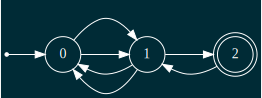

('green', 'blue', 'yellow') 0.7538668085871059
('green', 'yellow') 0.9209098453332014
('blue', 'green', 'yellow') 0.9985367004185036
('blue', 'yellow') 0.028513815542304692
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 26.590989771968083,
 'grad': array([ 1.35340293,  0.        ,  0.63235785, -0.02108287,  0.20855132,
       -0.02694125,  0.14311959, -0.03057183,  0.03353745, -0.0306645 ,
        0.03473162, -0.0307916 ,  0.0415951 , -0.03112921,  0.03259444,
       -0.031175  ,  0.02930628, -0.0311166 ,  0.02149166, -0.03081582,
 

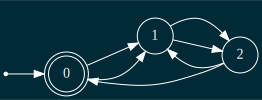

('green', 'blue', 'yellow') 0.7026874181810382
('green', 'yellow') 0.9262792101292915
('blue', 'green', 'yellow') 0.9986360426096034
('blue', 'yellow') 0.026578036329075683
{'conjecture': +: set()
--------------
-: {('blue', 'red', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 26.599728312786215,
 'grad': array([ 1.37697817,  0.        ,  0.63351216, -0.02114196,  0.20751374,
       -0.02696608,  0.14245621, -0.03057515,  0.03347203, -0.03066567,
        0.03470605, -0.03079193,  0.04158581, -0.03112924,  0.03259349,
       -0.031175  ,  0.02930622, -0.0311166 ,  0.02149166, -0.0308

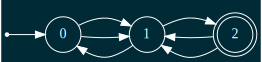

('green', 'blue', 'yellow') 0.7026874181810382
('green', 'yellow') 0.9262792101292915
('blue', 'green', 'yellow') 0.9986360426096034
('blue', 'yellow') 0.026578036329075683
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 25.889826285517962,
 'grad': array([ 1.16036832,  0.        ,  0.51796641, -0.01731962,  0.22877474,
       -0.02392759,  0.2362904 , -0.03056393,  0.03083826, -0.03057251,
        0.03544543, -0.03072478,  0.04529855, -0.03118021,  0.03175003,
       -0.03119802,  0.02868331, -0.03111944,

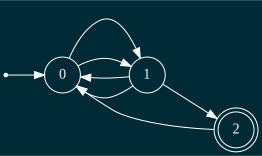

('green', 'blue', 'yellow') 0.6180888815651538
('green', 'yellow') 0.9351546656730567
('blue', 'green', 'yellow') 0.9988002533187301
('blue', 'yellow') 0.023378230951338973
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 26.007627117911095,
 'grad': array([ 1.19841704,  0.        ,  0.54454276, -0.01818729,  0.23415713,
       -0.02493635,  0.20251183, -0.03048558,  0.03298179, -0.03056359,
        0.03592606, -0.03073117,  0.04467021, -0.03116676,  0.03214634,
       -0.03119737,  0.02870086, -0.03111936,

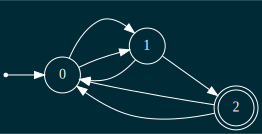

('green', 'blue', 'yellow') 0.6550078559285842
('green', 'yellow') 0.9414232007327735
('blue', 'green', 'yellow') 0.998916231657224
('blue', 'yellow') 0.021118280225913617
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 26.60004631318058,
 'grad': array([ 1.37700266,  0.        ,  0.63353318, -0.02114264,  0.20751615,
       -0.02696681,  0.14243142, -0.03057508,  0.03347351, -0.03066566,
        0.03470647, -0.03079193,  0.04158567, -0.03112924,  0.03259365,
       -0.031175  ,  0.02930623, -0.0311166 ,  

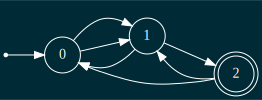

('green', 'blue', 'yellow') 0.672514198146799
('green', 'yellow') 0.9443956321682193
('blue', 'green', 'yellow') 0.9989712265891955
('blue', 'yellow') 0.020046650488691337
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 25.748508521372838,
 'grad': array([ 1.16405725,  0.        ,  0.51926422, -0.01736378,  0.22814855,
       -0.02395081,  0.23563366, -0.03056589,  0.03080273, -0.0305733 ,
        0.03542871, -0.03072503,  0.04529153, -0.03118023,  0.03174956,
       -0.03119802,  0.02868329, -0.03111944, 

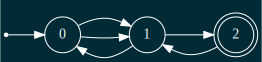

('green', 'blue', 'yellow') 0.672514198146799
('green', 'yellow') 0.9443956321682193
('blue', 'green', 'yellow') 0.9989712265891955
('blue', 'yellow') 0.020046650488691337
{'conjecture': +: set()
--------------
-: {('red', 'blue', 'red', 'green', 'yellow', 'green')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 27.31808913363686,
 'grad': array([ 1.40727982e+00,  0.00000000e+00,  6.49816285e-01, -2.16810556e-02,
        1.99338534e-01, -2.72328518e-02,  1.35303041e-01, -3.06100452e-02,
        3.31746748e-02, -3.06901899e-02,  3.44171305e-02, -3.08066568e-02,
      

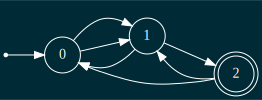

('green', 'blue', 'yellow') 0.6804231598355699
('green', 'yellow') 0.9457385081415326
('blue', 'green', 'yellow') 0.9989960720311853
('blue', 'yellow') 0.019562512886981475
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'blue', 'red', 'green', 'yellow', 'green'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 26.12711472195315,
 'grad': array([ 1.19493608,  0.        ,  0.54294047, -0.01813382,  0.23493966,
       -0.024909  ,  0.20326916, -0.03048276,  0.03303259, -0.03056244,
        0.03595034, -0.03073081,  0.04468058, -0.03116674,  0.032

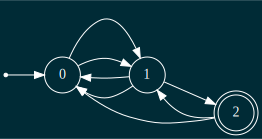

('green', 'blue', 'yellow') 0.7039480967964422
('green', 'yellow') 0.9497328469513053
('blue', 'green', 'yellow') 0.9990699739515106
('blue', 'yellow') 0.018122462092857266
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 26.590989771968083,
 'grad': array([ 1.35340293,  0.        ,  0.63235785, -0.02108287,  0.20855132,
       -0.02694125,  0.14311959, -0.03057183,  0.03353745, -0.0306645 ,
        0.03473162, -0.0307916 ,  0.0415951 , -0.03112921,  0.03259444,
       -0.031175  ,  0.02930628, -0.0311166 ,  0.02149166, -0.03081582,
        0.01701721, -0.0303846

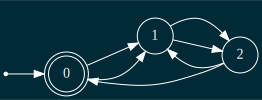

('green', 'blue', 'yellow') 0.7039480967964422
('green', 'yellow') 0.9497328469513053
('blue', 'green', 'yellow') 0.9990699739515106
('blue', 'yellow') 0.018122462092857266
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 25.73632004751039,
 'grad': array([ 1.16051276,  0.        ,  0.5179957 , -0.01732068,  0.22875185,
       -0.0239279 ,  0.2362835 , -0.03056402,  0.03083648, -0.03057253,
        0.0354448 , -0.03072479,  0.04529859, -0.03118022,  0.03174988,
       -0.03119802,  0.0286833 , -0.03111944,  0.02143827, -0.0308169 ,
        0.01700448, -0.03038526

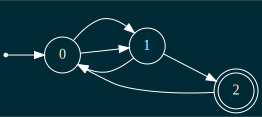

('green', 'blue', 'yellow') 0.7039480967964422
('green', 'yellow') 0.9497328469513053
('blue', 'green', 'yellow') 0.9990699739515106
('blue', 'yellow') 0.018122462092857266
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 26.60004631318058,
 'grad': array([ 1.37700266,  0.        ,  0.63353318, -0.02114264,  0.20751615,
       -0.02696681,  0.14243142, -0.03057508,  0.03347351, -0.03066566,
        0.03470647, -0.03079193,  0.04158567, -0.03112924,  0.03259365,
       -0.031175  ,  0.02930623, -0.0311166 ,  0.02149166, -0.03081582,
        0.01701721, -0.03038461

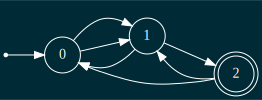

('green', 'blue', 'yellow') 0.7039480967964422
('green', 'yellow') 0.9497328469513053
('blue', 'green', 'yellow') 0.9990699739515106
('blue', 'yellow') 0.018122462092857266
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 26.590989771968083,
 'grad': array([ 1.35340293,  0.        ,  0.63235785, -0.02108287,  0.20855132,
       -0.02694125,  0.14311959, -0.03057183,  0.03353745, -0.0306645 ,
        0.03473162, -0.0307916 ,  0.0415951 , -0.03112921,  0.03259444,
       -0.031175  ,  0.02930628, -0.0311166 ,  0.02149166, -0.03081582,
        0.01701721, -0.0303846

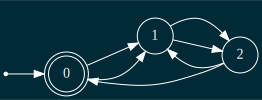

('green', 'blue', 'yellow') 0.7039480967964422
('green', 'yellow') 0.9497328469513053
('blue', 'green', 'yellow') 0.9990699739515106
('blue', 'yellow') 0.018122462092857266
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 26.578785869884488,
 'grad': array([ 1.37251691,  0.        ,  0.63196345, -0.02108921,  0.20843298,
       -0.0269437 ,  0.14305378, -0.03057214,  0.03353125, -0.03066461,
        0.03472926, -0.03079163,  0.04159422, -0.03112921,  0.03259436,
       -0.031175  ,  0.02930628, -0.0311166 ,  0.02149166, -0.03081582,
        0.01701721, -0.0303846

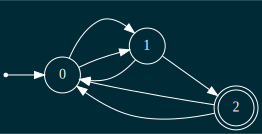

('green', 'blue', 'yellow') 0.717199884370325
('green', 'yellow') 0.9519828903623999
('blue', 'green', 'yellow') 0.9991116035019354
('blue', 'yellow') 0.01731126981416699
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 25.748508521372838,
 'grad': array([ 1.16405725,  0.        ,  0.51926422, -0.01736378,  0.22814855,
       -0.02395081,  0.23563366, -0.03056589,  0.03080273, -0.0305733 ,
        0.03542871, -0.03072503,  0.04529153, -0.03118023,  0.03174956,
       -0.03119802,  0.02868329, -0.03111944,  0.02143827, -0.0308169 ,
        0.01700448, -0.03038526,

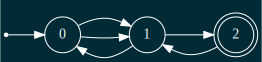

('green', 'blue', 'yellow') 0.717199884370325
('green', 'yellow') 0.9519828903623999
('blue', 'green', 'yellow') 0.9991116035019354
('blue', 'yellow') 0.01731126981416699
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 25.73632004751039,
 'grad': array([ 1.16051276,  0.        ,  0.5179957 , -0.01732068,  0.22875185,
       -0.0239279 ,  0.2362835 , -0.03056402,  0.03083648, -0.03057253,
        0.0354448 , -0.03072479,  0.04529859, -0.03118022,  0.03174988,
       -0.03119802,  0.0286833 , -0.03111944,  0.02143827, -0.0308169 ,
        0.01700448, -0.03038526, 

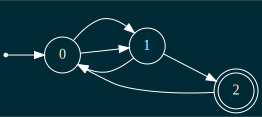

('green', 'blue', 'yellow') 0.717199884370325
('green', 'yellow') 0.9519828903623999
('blue', 'green', 'yellow') 0.9991116035019354
('blue', 'yellow') 0.01731126981416699
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 26.869579032520296,
 'grad': array([ 1.41210014e+00,  0.00000000e+00,  6.49398745e-01, -2.16727148e-02,
        1.97107792e-01, -2.71550610e-02,  1.37526514e-01, -3.06041689e-02,
        3.28205161e-02, -3.06734297e-02,  3.46241523e-02, -3.07968898e-02,
        4.12206004e-02, -3.11226308e-02,  3.25913664e-02, -3.11685288e-02,
        3.05378749e-

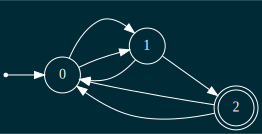

('green', 'blue', 'yellow') 0.726357864834273
('green', 'yellow') 0.9535378393447129
('blue', 'green', 'yellow') 0.9991403726477872
('blue', 'yellow') 0.01675067502653304
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 25.73632004751039,
 'grad': array([ 1.16051276,  0.        ,  0.5179957 , -0.01732068,  0.22875185,
       -0.0239279 ,  0.2362835 , -0.03056402,  0.03083648, -0.03057253,
        0.0354448 , -0.03072479,  0.04529859, -0.03118022,  0.03174988,
       -0.03119802,  0.0286833 , -0.03111944,  0.02143827, -0.0308169 ,
        0.01700448, -0.03038526, 

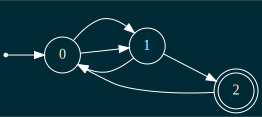

('green', 'blue', 'yellow') 0.726357864834273
('green', 'yellow') 0.9535378393447129
('blue', 'green', 'yellow') 0.9991403726477872
('blue', 'yellow') 0.01675067502653304
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 25.748508521372838,
 'grad': array([ 1.16405725,  0.        ,  0.51926422, -0.01736378,  0.22814855,
       -0.02395081,  0.23563366, -0.03056589,  0.03080273, -0.0305733 ,
        0.03542871, -0.03072503,  0.04529153, -0.03118023,  0.03174956,
       -0.03119802,  0.02868329, -0.03111944,  0.02143827, -0.0308169 ,
        0.01700448, -0.03038526,

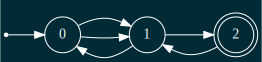

('green', 'blue', 'yellow') 0.726357864834273
('green', 'yellow') 0.9535378393447129
('blue', 'green', 'yellow') 0.9991403726477872
('blue', 'yellow') 0.01675067502653304
{'conjecture': +: set()
--------------
-: {('blue', 'red', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 27.34161837137087,
 'grad': array([ 1.41176469e+00,  0.00000000e+00,  6.51527213e-01, -2.17389019e-02,
        1.98355865e-01, -2.72581820e-02,  1.34620738e-01, -3.06132618e-02,
        3.31112350e-02, -3.06913235e-02,  3.43922695e-02, -3.08069781e-02,
        4.09450340e-02,

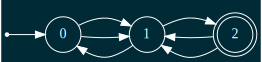

('green', 'blue', 'yellow') 0.7317755579456651
('green', 'yellow') 0.9544577186153892
('blue', 'green', 'yellow') 0.9991573919463016
('blue', 'yellow') 0.01641903744211113
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 24.747182208018017,
 'grad': array([ 1.00015635,  0.        ,  0.76626458, -0.02492248,  0.16009219,
       -0.02914654,  0.04376308, -0.0296033 ,  0.04892506, -0.03020711,
        0.04583813, -0.03069558,  0.00297221, -0.02982922,  0.00426547,


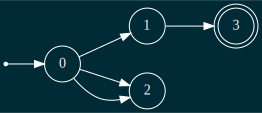

('green', 'blue', 'yellow') 0.7879786628529206
('green', 'yellow') 0.9640005387952761
('blue', 'green', 'yellow') 0.9993339500126545
('blue', 'yellow') 0.012978631799853535
{'conjecture': +: {('yellow',)}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0

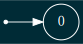

('green', 'blue', 'yellow') 0.7879786628529206
('green', 'yellow') 0.9640005387952761
('blue', 'green', 'yellow') 0.9993339500126545
('blue', 'yellow') 0.012978631799853535
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow',)}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 24.499581091240184,
 'grad': array([ 0.27835802,  0.        ,  0.74347598, -0.02350546,  0.20349809,
       -0.02913023,  0.07272219, -0.03049248,  0.04104991, -0.0308224 ,
        0.03337927, -0.0309023 ,  0.03152154, -0.03092165

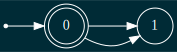

('green', 'blue', 'yellow') 0.6212348986070744
('green', 'yellow') 0.9716183664790423
('blue', 'green', 'yellow') 0.7878654009018481
('blue', 'yellow') 0.010232230122892951
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 25.566262078046154,
 'grad': array([ 1.2201248 ,  0.        ,  0.55159045, -0.01842873,  0.23762914,
       -0.02527874,  0.18930856, -0.03040467,  0.03531781, -0.03055821,
        0.03667001, -0.0307492 ,  0.04302157, -0.03113272,  0.03313

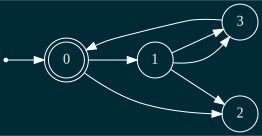

('green', 'blue', 'yellow') 0.5790644355428725
('green', 'yellow') 0.9735449591910436
('blue', 'green', 'yellow') 0.8022654519871398
('blue', 'yellow') 0.00953764924305286
{'conjecture': +: {('yellow', 'blue')}
--------------
-: set(),
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 17.822461031687876,
 'grad': array([ 0.38351628,  0.        ,  0.77256971, -0.02451733,  0.193626  ,
       -0.02980198,  0.06569207, -0.03092354,  0.03350929, -0.03100435,
        0.03290519, -0.03106375,  0.02370146, -0.03083368,  0.011412

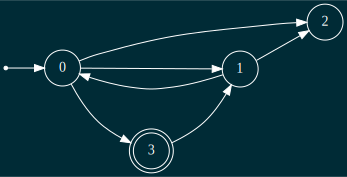

('green', 'blue', 'yellow') 0.0036738394315638644
('green', 'yellow') 0.9998321575870974
('blue', 'green', 'yellow') 0.9987454850706018
('blue', 'yellow') 6.051104112567898e-05
{'conjecture': +: {('yellow', 'red')}
--------------
-: set(),
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 18.446594137712935,
 'grad': array([ 0.22767142,  0.        ,  0.77251214, -0.02436334,  0.19760186,
       -0.02977704,  0.06669912, -0.03093086,  0.03372359, -0.03101813,
        0.03303896, -0.03108128,  0.02780943

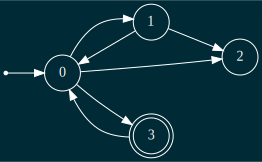

('green', 'blue', 'yellow') 0.002397556131116329
('green', 'yellow') 0.9998904656521843
('blue', 'green', 'yellow') 0.9991813006483858
('blue', 'yellow') 3.948964573809573e-05
{'conjecture': +: set()
--------------
-: {('blue', 'red', 'blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'red')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 19.85336316245296,
 'grad': array([ 0.32431524,  0.        ,  0.7333861 , -0.02323503,  0.20631204,
       -0.02895619,  0.08803921, -0.03080253,  0.03641076, -0.03097779,
        

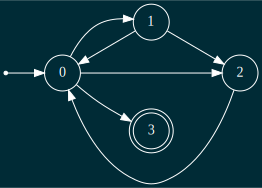

('green', 'blue', 'yellow') 0.0022095473221555636
('green', 'yellow') 0.9998990549911391
('blue', 'green', 'yellow') 0.9992455004758669
('blue', 'yellow') 3.6392991955877464e-05
{'conjecture': +: set()
--------------
-: {('blue', 'yellow', 'green', 'yellow')},
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 19.57307642875973,
 'grad': array([ 0.28369755,  0.        ,  0.77099078, -0.02437051,  0.19749024,
       -0.0297805 ,  0.06674478, -0.03093564,  0.0337714 , -0.03102425,
        0.03310117, -0.0

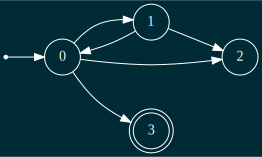

('green', 'blue', 'yellow') 0.0020017906185200913
('green', 'yellow') 0.9999085465291021
('blue', 'green', 'yellow') 0.9993164436652057
('blue', 'yellow') 3.297107472949772e-05
{'conjecture': +: {('yellow',)}
--------------
-: set(),
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 18.27347909198143,
 'grad': array([ 0.20331052,  0.        ,  0.86578196, -0.02725423,  0.13436192,
       -0.03060135,  0.04284063, -0.03098382,  0.03088856, -0.03098085,
        0.0

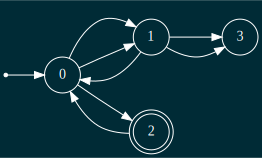

('green', 'blue', 'yellow') 0.0014884602728571783
('green', 'yellow') 0.9999319984532913
('blue', 'green', 'yellow') 0.999491731832896
('blue', 'yellow') 2.451611793672218e-05
{'conjecture': +: {('yellow', 'blue')}
--------------
-: set(),
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 17.84197659630038,
 'grad': array([ 0.31272067,  0.        ,  0.77238604, -0.02444245,  0.19546903,
       -0.02978704,  0.0660917 , -0.03092156,  0.03355916, -0.03100398,
        0.03291478, -0.03106369,  0.02370254, -0.03083366,  0.011

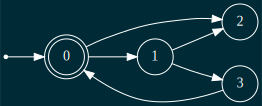

('green', 'blue', 'yellow') 0.001067149400684705
('green', 'yellow') 0.9999512463912277
('blue', 'green', 'yellow') 0.9996355978860818
('blue', 'yellow') 1.7576794651743427e-05
{'conjecture': +: set()
--------------
-: {('blue', 'yellow', 'green')},
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 21.090569853217207,
 'grad': array([ 0.6217285 ,  0.        ,  0.84344606, -0.02696485,  0.13237227,
       -0.03025883,  0.04162732, -0.03061409,  0.03532185, -0.03076121,
        0.03439552, -0.03087478,  

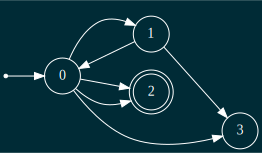

('green', 'blue', 'yellow') 0.011926616003687029
('green', 'yellow') 0.999951776395007
('blue', 'green', 'yellow') 0.9996395593261163
('blue', 'yellow') 1.7385716127902787e-05
{'conjecture': +: set()
--------------
-: {('blue', 'red', 'green', 'red', 'green', 'yellow', 'green')},
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 21.99862069942093,
 'grad': array([ 0.8316516 ,  0.        ,  0.88527754, -0.02847708,  0.08915215,
       -0.03037318,  0.04762358, -0.03091225, 

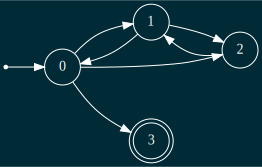

('green', 'blue', 'yellow') 0.011874553146014523
('green', 'yellow') 0.999951986903896
('blue', 'green', 'yellow') 0.9996411327457264
('blue', 'yellow') 1.7309822843167053e-05
{'conjecture': +: {('yellow', 'blue')}
--------------
-: set(),
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'yellow', 'green'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 27.33267480563072,
 'grad': array([ 0.59309572,  0.        ,  0.79588488, -0.0254506 ,  0.16913942,
       -0.02994087,  0.05

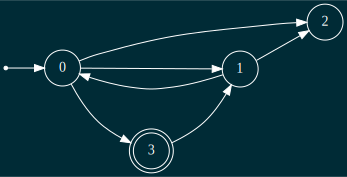

('green', 'blue', 'yellow') 0.011874303071962841
('green', 'yellow') 0.9999519879150355
('blue', 'green', 'yellow') 0.9996411403033489
('blue', 'yellow') 1.7309458304183646e-05
{'conjecture': +: set()
--------------
-: {('blue', 'yellow', 'green', 'yellow')},
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'yellow', 'green'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 19.71335384640157,
 'grad': array([ 0.27805803,  0.        ,  0.77072386, -0.02435666,  0.19783416,
     

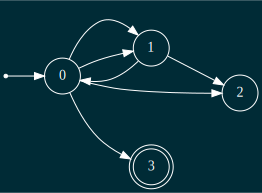

('green', 'blue', 'yellow') 0.011385825177861443
('green', 'yellow') 0.9588165681519536
('blue', 'green', 'yellow') 0.9996559028563878
('blue', 'yellow') 1.6597392283195186e-05
{'conjecture': +: set()
--------------
-: {('blue', 'red', 'yellow', 'red')},
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'yellow', 'green'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 27.45515234799447,
 'grad': array([ 1.48947953,  0.        ,  0.695488

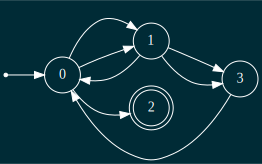

('green', 'blue', 'yellow') 0.011385621767454623
('green', 'yellow') 0.9588173039035126
('blue', 'green', 'yellow') 0.999655909003763
('blue', 'yellow') 1.6597095766933633e-05
{'conjecture': +: {('yellow',)}
--------------
-: set(),
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'yellow', 'green'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'red', 'yellow', 'red'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 28.345396577339613,
 'grad': array([ 0.20042157,  0.     

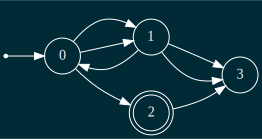

('green', 'blue', 'yellow') 0.011385538258303744
('green', 'yellow') 0.9588176059627285
('blue', 'green', 'yellow') 0.999655911527538
('blue', 'yellow') 1.6596974033627987e-05
{'conjecture': +: set()
--------------
-: {('red', 'yellow', 'red', 'green', 'red', 'green')},
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'yellow', 'green'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'red', 'yellow', 'red'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 27.45515234799447,


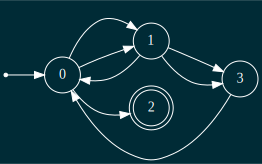

('green', 'blue', 'yellow') 0.011385538258303744
('green', 'yellow') 0.9588176059627285
('blue', 'green', 'yellow') 0.999655911527538
('blue', 'yellow') 1.6596974033627987e-05
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'yellow', 'green'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'red', 'yellow', 'red'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow'),
 ('red', 'yellow', 'red', 'green', 'red', 'green')},


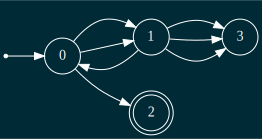

('green', 'blue', 'yellow') 0.011383537707537935
('green', 'yellow') 0.9588248421133662
('blue', 'green', 'yellow') 0.9996559719872582
('blue', 'yellow') 1.6594057782471496e-05
{'conjecture': +: {('yellow', 'green')}
--------------
-: set(),
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'yellow', 'green'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'red', 'yellow', 'red'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow'),
 ('red', 'yellow', 'red', 'green', 'red', 'green')},
 'energ

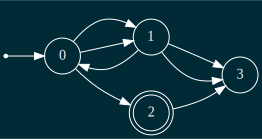

('green', 'blue', 'yellow') 0.00931226656777111
('green', 'yellow') 0.9663167939474125
('blue', 'green', 'yellow') 0.9997185689858687
('blue', 'yellow') 1.3574715829249286e-05
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 20.277090392608933,
 'grad': array([ 3.19111879e-01,  0.00000000e+00,  8.64606433e-01, -2.73305837e-02,
        1.33354685e-01, -3.06438369e-02,  4.36050168e-02, -3.104

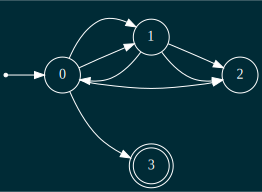

('green', 'blue', 'yellow') 0.00913731469936447
('green', 'yellow') 0.9481623599711655
('blue', 'green', 'yellow') 0.9997238563003364
('blue', 'yellow') 1.3319684266295993e-05
{'conjecture': +: set()
--------------
-: {('red', 'blue')},
 'data': +: {('yellow',), ('yellow', 'blue')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 38.329354200395024,
 'grad': array([ 1.88210179,  0.        ,  0.70588824, -0.023897  ,  0.19439481,
       -0.02922505,  0.07051749, -0.03051544,  0.04051596, -0.03082796,
      

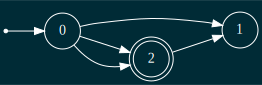

('green', 'blue', 'yellow') 0.009137314696883147
('green', 'yellow') 0.9481623599852425
('blue', 'green', 'yellow') 0.9997238560288522
('blue', 'yellow') 1.3319684262678912e-05
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow',), ('yellow', 'blue')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow'),
 ('red', 'blue'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 24.95323886796689,
 'grad': array([ 0.26919075,  0.        ,  0.74369084, -0.02350322,  0.20355013,
       -0.02912969,  0.0727348 , -0.03049235,  0

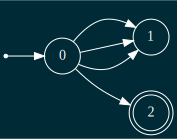

('green', 'blue', 'yellow') 0.009135715947853682
('green', 'yellow') 0.9479964607355077
('blue', 'green', 'yellow') 0.999548935103221
('blue', 'yellow') 1.3317353727615363e-05
{'conjecture': +: {('yellow', 'green')}
--------------
-: set(),
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow'),
 ('red', 'blue'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 18.02548469804418,
 'grad': array([ 0.19109685,  0.        ,  0.86755311, -0.02729765,  0.13396025,
       -0.03063086,  0.04340561, -0.03103007,  0.03193274,

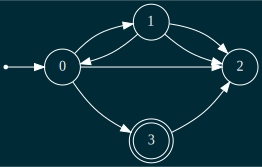

('green', 'blue', 'yellow') 0.007751962320661195
('green', 'yellow') 0.95587324745861
('blue', 'green', 'yellow') 0.9996172562605973
('blue', 'yellow') 1.1300222653227858e-05
{'conjecture': +: {('yellow',)}
--------------
-: set(),
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow'),
 ('red', 'blue'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 18.27347909198143,
 'grad': array([ 0.20331052,  0.        ,  0.86578196, -0.02725423,  0.13436192,
       -0.03060135,  0.04284063, -0.0309838

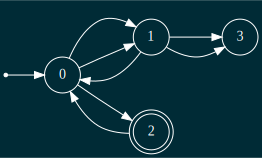

('green', 'blue', 'yellow') 0.007751962320661195
('green', 'yellow') 0.95587324745861
('blue', 'green', 'yellow') 0.9996172562605973
('blue', 'yellow') 1.1300222653227858e-05
{'conjecture': +: {('yellow',)}
--------------
-: set(),
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow'),
 ('red', 'blue'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 28.345396577339613,
 'grad': array([ 0.20042157,  0.        ,  0.85678262, -0.02697018,  0.13728344,
       -0.03041747,  0.04068962, -0.030738

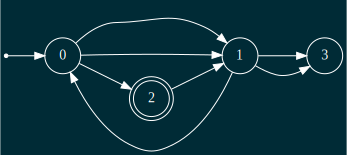

('green', 'blue', 'yellow') 0.007751923608725661
('green', 'yellow') 0.9558734678198463
('blue', 'green', 'yellow') 0.999617258171952
('blue', 'yellow') 1.1300166221904693e-05
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow'),
 ('red', 'blue'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 20.150032402746124,
 'grad': array([ 0.31915412,  0.        ,  0.86459824, -0.02733037,  0.13335692,
       -0.0306437 ,  0.04

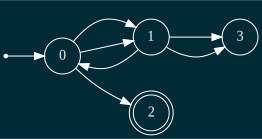

('green', 'blue', 'yellow') 0.0076141219331449924
('green', 'yellow') 0.9566578808738069
('blue', 'green', 'yellow') 0.999624061962583
('blue', 'yellow') 1.109928939206007e-05
{'conjecture': +: {('yellow',)}
--------------
-: set(),
 'data': +: {('yellow',), ('yellow', 'blue'), ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow'),
 ('red', 'blue'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 37.37087153786812,
 'grad': array([ 0.15898052,  0.        ,  0.74627389, -0.02347631,  0.20417571,
       -0.02912317,  0.0728863 , -0.03049077

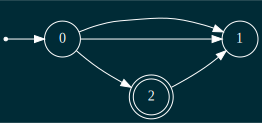

('green', 'blue', 'yellow') 0.007614121928651858
('green', 'yellow') 0.9566578808993831
('blue', 'green', 'yellow') 0.9996240613726993
('blue', 'yellow') 1.109928938551032e-05
{'conjecture': +: set()
--------------
-: {('blue', 'yellow', 'red', 'yellow', 'red', 'yellow')},
 'data': +: {('yellow',), ('yellow', 'blue'), ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow'),
 ('red', 'blue'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 29.316655068071615,
 'grad': array([ 1.1991769 ,  0.        ,  0.51066984, -0.0171295 ,  0.39786857,
  

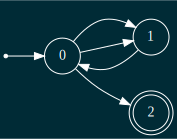

('green', 'blue', 'yellow') 0.007614107788619831
('green', 'yellow') 0.956657961389157
('blue', 'green', 'yellow') 0.9996222049910476
('blue', 'yellow') 1.1099268773244207e-05
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow',), ('yellow', 'blue'), ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow'),
 ('blue', 'yellow', 'red', 'yellow', 'red', 'yellow'),
 ('red', 'blue'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 24.939359359918196,
 'grad': array([ 0.32029552,  0.        ,  0.74249307

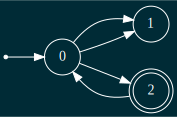

('green', 'blue', 'yellow') 0.007612982093596663
('green', 'yellow') 0.9566643692203188
('blue', 'green', 'yellow') 0.9994744175191015
('blue', 'yellow') 1.1097627820427975e-05
{'conjecture': +: {('yellow', 'blue')}
--------------
-: set(),
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 17.84197659630038,
 'grad': array([ 0.31272067,  0.        ,  0.77238604, -0.02444245,  0.19546903,
       -0.02978704,  0.0660917 , -0.03092156,  0.03355916, -0.03100398,
        0.03291478, -0.03106369,  0.02370254, -0.03083366,  0.01

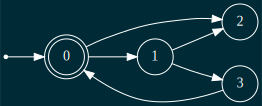

('green', 'blue', 'yellow') 0.007612982093596663
('green', 'yellow') 0.9566643692203188
('blue', 'green', 'yellow') 0.9994744175191015
('blue', 'yellow') 1.1097627820427975e-05
{'conjecture': +: set()
--------------
-: {('blue', 'red', 'green', 'yellow')},
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 21.99862069942093,
 'grad': array([ 0.8316516 ,  0.        ,  0.88527754, -0.02847708,  0.08915215,
       -0.03037318,  0.04762358, -0.03091225,  0.03135225, -0.030926  ,
        0.03332079, -0.03100

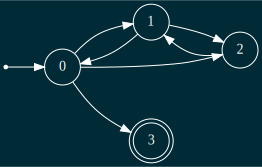

('green', 'blue', 'yellow') 0.007612982093596663
('green', 'yellow') 0.9566643692203188
('blue', 'green', 'yellow') 0.9994744175191015
('blue', 'yellow') 1.1097627820427975e-05
{'conjecture': +: {('yellow', 'green')}
--------------
-: set(),
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 18.561496718604115,
 'grad': array([ 0.32183218,  0.        ,  0.77032981, -0.0243871 ,  0.19700948,
       -0.02978155,  0.06657809, -0.03093144,  0.03370887, -0.03101823,
        0.03303627, -0.0310813 ,  0.027809

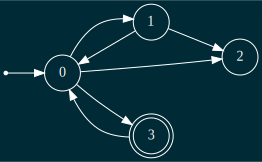

('green', 'blue', 'yellow') 0.007003465839469515
('green', 'yellow') 0.9601339388342136
('blue', 'green', 'yellow') 0.9995164970959417
('blue', 'yellow') 1.0209121259445266e-05
{'conjecture': +: set()
--------------
-: {('blue', 'yellow', 'green', 'yellow', 'red')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 19.57307642875973,
 'grad': array([ 0.28369755,  0.        ,  0.77099078, -0.02437051,  0.19749024,
       -0.0297805 ,  0.06674478, -0.03093564,  0.0337714 , -0.0310

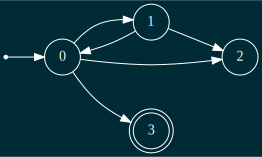

('green', 'blue', 'yellow') 0.007003465839469515
('green', 'yellow') 0.9601339388342136
('blue', 'green', 'yellow') 0.9995164970959417
('blue', 'yellow') 1.0209121259445266e-05
{'conjecture': +: {('yellow', 'red')}
--------------
-: set(),
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 18.44622075667234,
 'grad': array([ 0.2274374 ,  0.        ,  0.77249537, -0.02436259,  0.19762047,
       -0.0297769 ,  0.06670309, -0.03093084, 

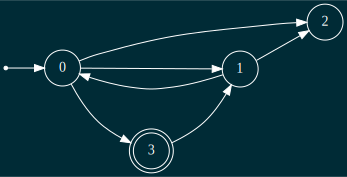

('green', 'blue', 'yellow') 0.006426111475842488
('green', 'yellow') 0.963420432250798
('blue', 'green', 'yellow') 0.9995563562910721
('blue', 'yellow') 9.367497862823596e-06
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green'),
 ('yellow', 'red')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 25.554140952491757,
 'grad': array([ 1.17267997,  0.        ,  0.45023747, -0.01521512,  0.45007574,
       -0.02880451,  0.072

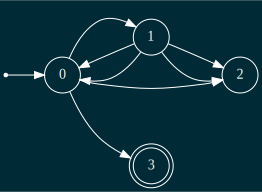

('green', 'blue', 'yellow') 0.006425677847293443
('green', 'yellow') 0.9634229006089873
('blue', 'green', 'yellow') 0.9995563862277731
('blue', 'yellow') 9.366865752017287e-06
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green'),
 ('yellow', 'red')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 20.150032402746124,
 'grad': array([ 0.31915412,  0.        ,  0.86459824, -0.02733037,  0.13335692,
       -0.030643

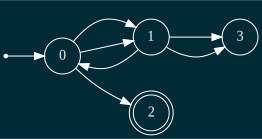

('green', 'blue', 'yellow') 0.006425677847293443
('green', 'yellow') 0.9634229006089873
('blue', 'green', 'yellow') 0.9995563862277731
('blue', 'yellow') 9.366865752017287e-06
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow',), ('yellow', 'blue'), ('yellow', 'green'), ('yellow', 'red')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 24.762949532082935,
 'grad': array([ 0.2639307 ,  0.        ,  0.74381412, -0.02350194,  0.20357998,
       -0.02912938,

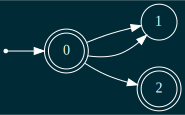

('green', 'blue', 'yellow') 0.006424721459589076
('green', 'yellow') 0.9634283446864763
('blue', 'green', 'yellow') 0.9994076138398122
('blue', 'yellow') 9.36547160256775e-06
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green'),
 ('yellow', 'red')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 20.277090392608933,
 'grad': array([ 3.19111879e-01,  0.00000000e+00,  8.64606433e-01, -2.73305837e-02,
        1.3335

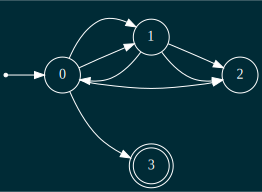

('green', 'blue', 'yellow') 0.006424721459589076
('green', 'yellow') 0.9634283446864763
('blue', 'green', 'yellow') 0.9994076138398122
('blue', 'yellow') 9.36547160256775e-06
{'conjecture': +: set()
--------------
-: {('red', 'blue', 'red')},
 'data': +: {('yellow',), ('yellow', 'blue'), ('yellow', 'green'), ('yellow', 'red')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 38.329354200395024,
 'grad': array([ 1.88210179,  0.        ,  0.70588824, -0.023897  ,  0.19439481,
       -0.02922505,  0.07

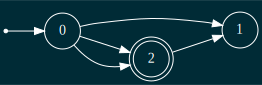

('green', 'blue', 'yellow') 0.006424721459589076
('green', 'yellow') 0.9634283446864763
('blue', 'green', 'yellow') 0.9994076138398122
('blue', 'yellow') 9.36547160256775e-06
{'conjecture': +: {('yellow', 'green')}
--------------
-: set(),
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 18.561496718604115,
 'grad': array([ 0.32183218,  0.        ,  0.77032981, -0.0243871 ,  0.19700948,
       -0.02978155,  0.06657809, -0.03093144,  0.03370887, -0.03101823,
        0.03303627, -0.0310813 ,  0.0278091 , -0.03097904,  0.01

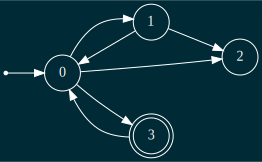

('green', 'blue', 'yellow') 0.006424721459589076
('green', 'yellow') 0.9634283446864763
('blue', 'green', 'yellow') 0.9994076138398122
('blue', 'yellow') 9.36547160256775e-06
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('yellow',), ('yellow', 'green'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 25.566262078046154,
 'grad': array([ 1.2201248 ,  0.        ,  0.55159045, -0.01842873,  0.23762914,
       -0.02527874,  0.18930856, -0.03040467,  0.03531781, -0.03055821,
        0.03667001, -0.0307492 ,  0.04302157

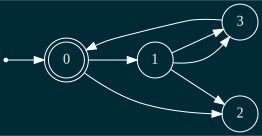

('green', 'blue', 'yellow') 0.006424721459589076
('green', 'yellow') 0.9634283446864763
('blue', 'green', 'yellow') 0.9994076138398122
('blue', 'yellow') 9.36547160256775e-06
{'conjecture': +: {('yellow', 'blue')}
--------------
-: set(),
 'data': +: {('yellow',), ('yellow', 'green'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 18.40782852314489,
 'grad': array([ 0.32744783,  0.        ,  0.86383429, -0.02731459,  0.13350272,
       -0.03063297,  0.0433492 , -0.03103036,  0.0319253 , -0.03105832,
        0.03060841, -0.03104426,  0.01749534,

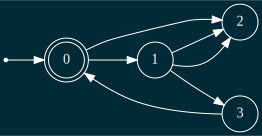

('green', 'blue', 'yellow') 0.0059178767284900685
('green', 'yellow') 0.9663134737803707
('blue', 'green', 'yellow') 0.999454347041548
('blue', 'yellow') 8.626631799803377e-06
{'conjecture': +: set()
--------------
-: {('blue', 'yellow', 'green')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 21.090569853217207,
 'grad': array([ 0.6217285 ,  0.        ,  0.84344606, -0.02696485,  0.13237227,
       -0.03025883,  0.04162732, -0.03061409,  0.03532185, -0.03076121,
        0.0

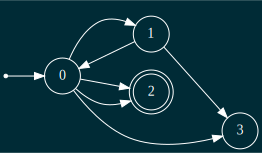

('green', 'blue', 'yellow') 0.0059178767284900685
('green', 'yellow') 0.9663134737803707
('blue', 'green', 'yellow') 0.999454347041548
('blue', 'yellow') 8.626631799803377e-06
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 25.424219603208726,
 'grad': array([ 1.17312302,  0.        ,  0.45036894, -0.01521966,  0.45049918,
       -0.02882214,  0.07162877, -0.03015985,  0.06261745, -0.

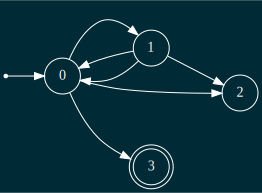

('green', 'blue', 'yellow') 0.005917457958179095
('green', 'yellow') 0.9663158575605181
('blue', 'green', 'yellow') 0.9994543856539201
('blue', 'yellow') 8.626021348209469e-06
{'conjecture': +: set()
--------------
-: {('blue', 'yellow', 'green', 'yellow', 'red')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 19.583258110216132,
 'grad': array([ 0.23487044,  0.        ,  0.75256838, -0.02374713,  0.21297944,
       -0.02966064,  0.06997389, -0.

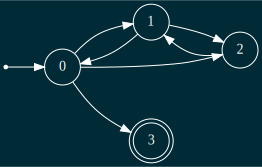

('green', 'blue', 'yellow') 0.005776790407253822
('green', 'yellow') 0.9671165841318716
('blue', 'green', 'yellow') 0.9994673557898056
('blue', 'yellow') 8.420966862675762e-06
{'conjecture': +: set()
--------------
-: {('blue', 'yellow', 'red')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 26.142841678035367,
 'grad': array([ 1.28618605,  0.        ,  0.55080823, -0.0184688 ,  0.36318923,
       -

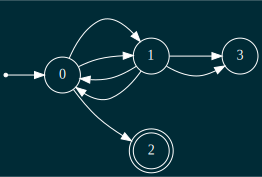

('green', 'blue', 'yellow') 0.005776595898215941
('green', 'yellow') 0.9671176913421271
('blue', 'green', 'yellow') 0.9994673737243516
('blue', 'yellow') 8.42068332215464e-06
{'conjecture': +: {('yellow', 'blue', 'red')}
--------------
-: set(),
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow', 'red'),
 ('blue', 'yellow', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 18.44622075667234,
 'grad': array([ 0.2274374 ,  0.        ,  0.77249537, -0.02436

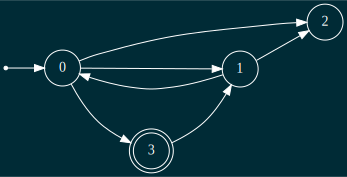

('green', 'blue', 'yellow') 0.005776595898215941
('green', 'yellow') 0.9671176913421271
('blue', 'green', 'yellow') 0.9994673737243516
('blue', 'yellow') 8.42068332215464e-06
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'blue', 'red'),
 ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow', 'red'),
 ('blue', 'yellow', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 20.150032212764334,
 'grad': array([ 0.31915419,  0.

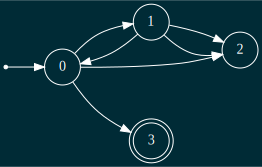

('green', 'blue', 'yellow') 0.00569972688557019
('green', 'yellow') 0.9675552553754404
('blue', 'green', 'yellow') 0.9994744613684658
('blue', 'yellow') 8.308629506346531e-06
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'blue', 'red'),
 ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow', 'red'),
 ('blue', 'yellow', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 24.73018368343424,
 'grad': array([ 0.26916876,  0. 

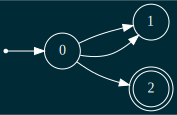

('green', 'blue', 'yellow') 0.005698949315385175
('green', 'yellow') 0.9675596815640255
('blue', 'green', 'yellow') 0.9993381107051014
('blue', 'yellow') 8.307496023512671e-06
{'conjecture': +: {('yellow', 'blue')}
--------------
-: set(),
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 17.84197659630038,
 'grad': array([ 0.31272067,  0.        ,  0.77238604, -0.02444245,  0.19546903,
       -0.02978704,  0.0660917 , -0.03092156,  0.03355916, -0.03100398,
        0.03291478, -0.03106369,  0.02370254, -0.03083366,  0.011

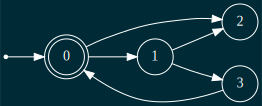

('green', 'blue', 'yellow') 0.005698949315385175
('green', 'yellow') 0.9675596815640255
('blue', 'green', 'yellow') 0.9993381107051014
('blue', 'yellow') 8.307496023512671e-06
{'conjecture': +: {('yellow',)}
--------------
-: set(),
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 27.33236649216631,
 'grad': array([ 0.59287882,  0.        ,  0.79589037, -0.02545056,  0.16914041,
       -0.02994087,  0.05868403, -0.03083909,  0.03224218, -0.03088294,
        0.03269226, -0.03093948,  0.01088714, -0.030

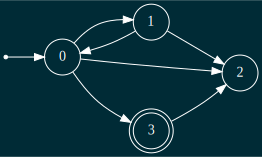

('green', 'blue', 'yellow') 0.005698891696835474
('green', 'yellow') 0.9675600095480095
('blue', 'green', 'yellow') 0.9993381173970542
('blue', 'yellow') 8.307412031561519e-06
{'conjecture': +: {('yellow', 'blue')}
--------------
-: set(),
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 17.822692552589046,
 'grad': array([ 0.38305077,  0.        ,  0.77258109, -0.02451723,  0.19362848,
       -0.02980196,  0.06569256, -0.03092354,  0.03350935, -0.03100435,
        0.0329052 , -0.03106375,  0.02370146, -0.03083368,  0.01

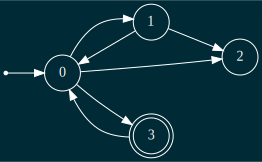

('green', 'blue', 'yellow') 0.005014930638853378
('green', 'yellow') 0.9714533437910156
('blue', 'green', 'yellow') 0.9994175542331012
('blue', 'yellow') 7.310385482459854e-06
{'conjecture': +: {('yellow', 'green')}
--------------
-: set(),
 'data': +: {('yellow',), ('yellow', 'blue'), ('blue', 'green', 'yellow')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 18.5613597922282,
 'grad': array([ 0.32173434,  0.        ,  0.77032788, -0.02438694,  0.19701339,
       -0.02978152,  0.06657887, -0.03093143,  0.03370897, -0.03101823,
        0.03303629, -0.0310813 ,  0.0278091 ,

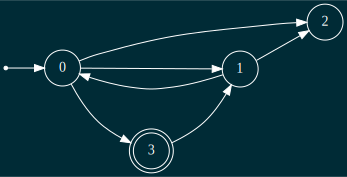

('green', 'blue', 'yellow') 0.004742978178499567
('green', 'yellow') 0.973001387811956
('blue', 'green', 'yellow') 0.9994491394275411
('blue', 'yellow') 6.9139538144549115e-06
{'conjecture': +: set()
--------------
-: {('blue', 'yellow', 'green', 'yellow', 'red')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 21.090569853217207,
 'grad': array([ 0.6217285 ,  0.        ,  0.84344606, -0.02696485,  0.13237227,
       -0.03025883,  0.04162732, -0.03061409,  0.03532185, -0.0307

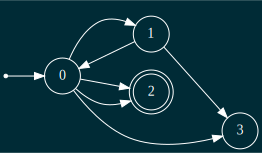

('green', 'blue', 'yellow') 0.004742978178499567
('green', 'yellow') 0.973001387811956
('blue', 'green', 'yellow') 0.9994491394275411
('blue', 'yellow') 6.9139538144549115e-06
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 20.150032402746124,
 'grad': array([ 0.31915412,  0.        ,  0.86459824, -0.02733037,  0.13335692,
       -0.0306437 ,  0.04360148, -0.

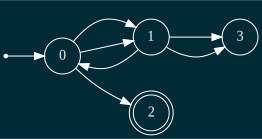

('green', 'blue', 'yellow') 0.004742978178499567
('green', 'yellow') 0.973001387811956
('blue', 'green', 'yellow') 0.9994491394275411
('blue', 'yellow') 6.9139538144549115e-06
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow',), ('yellow', 'blue'), ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 24.73018368343424,
 'grad': array([ 0.26916876,  0.        ,  0.74369136, -0.02350322,  0.20355025,
       -0.02912968,  0.07273483, -0.030

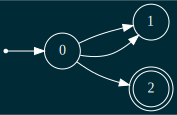

('green', 'blue', 'yellow') 0.004742978178499567
('green', 'yellow') 0.973001387811956
('blue', 'green', 'yellow') 0.9994491394275411
('blue', 'yellow') 6.9139538144549115e-06
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 20.150032212764334,
 'grad': array([ 0.31915419,  0.        ,  0.86459824, -0.02733037,  0.13335692,
       -0.0306437 ,  0.04360148, -0.

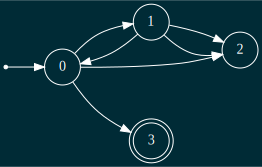

('green', 'blue', 'yellow') 0.004742978178499567
('green', 'yellow') 0.973001387811956
('blue', 'green', 'yellow') 0.9994491394275411
('blue', 'yellow') 6.9139538144549115e-06
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow',), ('yellow', 'blue'), ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 24.95323886796689,
 'grad': array([ 0.26919075,  0.        ,  0.74369084, -0.02350322,  0.20355013,
       -0.02912969,  0.0727348 , -0.030

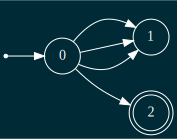

('green', 'blue', 'yellow') 0.004742978178499567
('green', 'yellow') 0.973001387811956
('blue', 'green', 'yellow') 0.9994491394275411
('blue', 'yellow') 6.9139538144549115e-06
{'conjecture': +: {('yellow', 'red')}
--------------
-: set(),
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green')}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'red'),
 ('blue', 'red', 'green', 'red', 'green', 'red', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'red', 'green', 'yellow', 'red'),
 ('blue', 'red', 'yellow'),
 ('blue', 'red', 'yellow', 'green'),
 ('blue', 'yellow'),
 ('blue', 'yellow', 'blue'),
 ('blue', 'yellow', 'green', 'red', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow', 'green', 'yellow', 'red'),
 ('red', 'yellow'),
 ('red', 'yellow', 'green', 'yellow')},
 'energy': 18.446220585656757,
 'grad': array([ 0.22743725,  0.        ,  0.77249537, -0.02436259,  0.19762047,
       -0.0297769 ,  0.06670309, -0.03093084, 

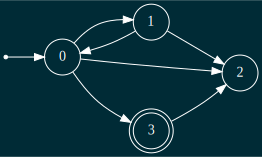

('green', 'blue', 'yellow') 0.004470939192826095
('green', 'yellow') 0.9745499243638468
('blue', 'green', 'yellow') 0.999480734671234
('blue', 'yellow') 6.5173960164022615e-06
energy 17.822461031687876


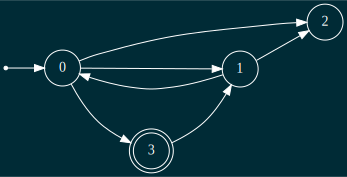

energy 17.822692552589046


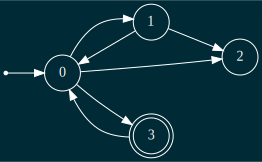

energy 17.84197659630038


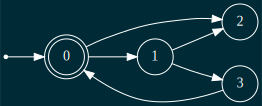

energy 18.02548469804418


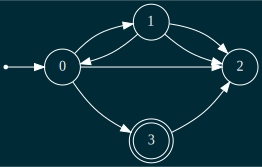

energy 18.025485221319734


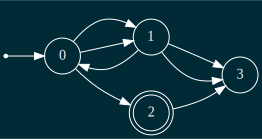

energy 18.27347909198143


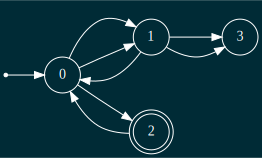

energy 18.40782852314489


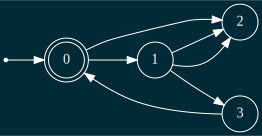

energy 18.446220585656757


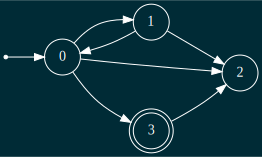

energy 18.44622075667234


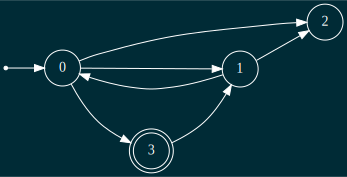

energy 18.446594137712935


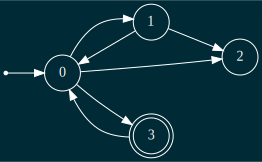

energy 18.5613597922282


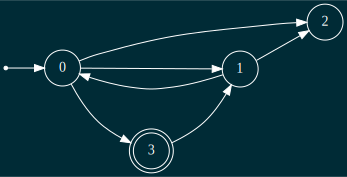

energy 18.561496718604115


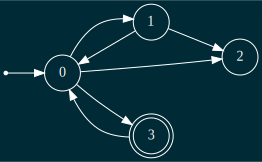

energy 19.57307642875973


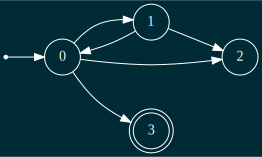

energy 19.583258110216132


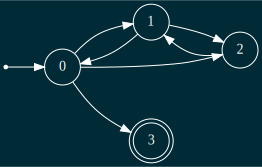

energy 19.71335384640157


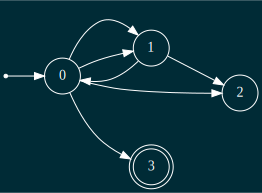

energy 19.85336316245296


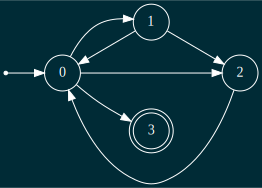

energy 20.150032212764334


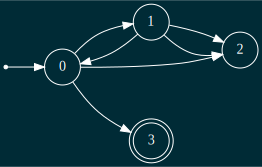

energy 20.150032402746124


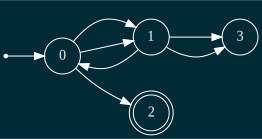

energy 20.277090392608933


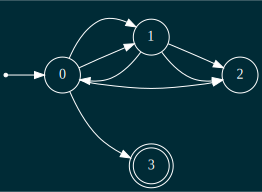

energy 21.090569853217207


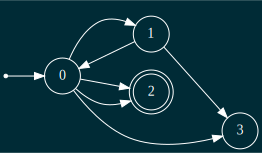

energy 21.99862069942093


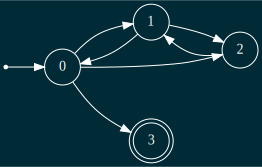

energy 24.499581091240184


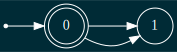

energy 24.73018368343424


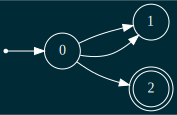

energy 24.747182208018017


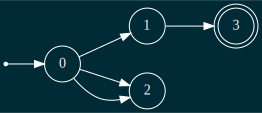

energy 24.762949532082935


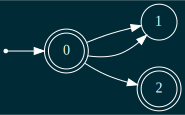

energy 24.939359359918196


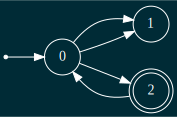

energy 24.95323886796689


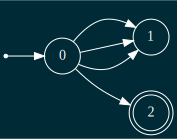

energy 25.168991930143324


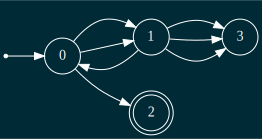

energy 25.424219603208726


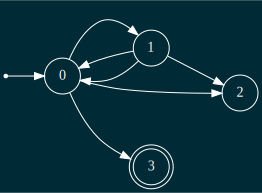

energy 25.554140952491757


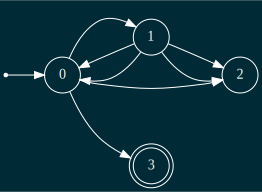

energy 25.566262078046154


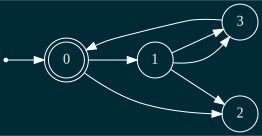

energy 25.73632004751039


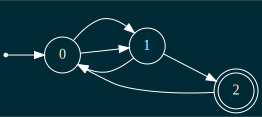

energy 25.748508521372838


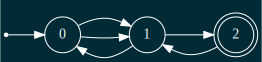

energy 25.889826285517962


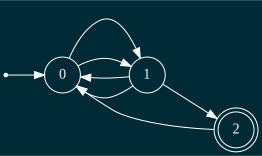

energy 25.90183882396178


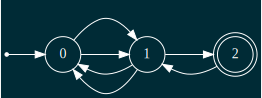

energy 25.984421268805498


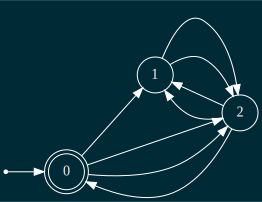

energy 26.007627117911095


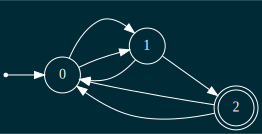

energy 26.05653426763384


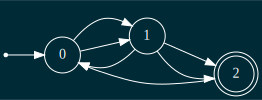

energy 26.12711472195315


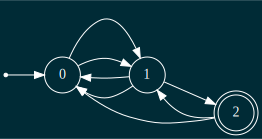

energy 26.142841678035367


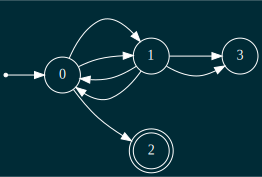

energy 26.527256379746603


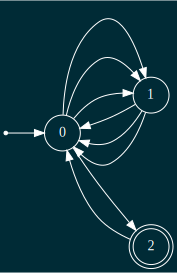

energy 26.578785869884488


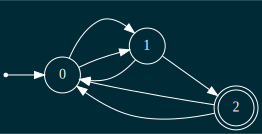

energy 26.590989771968083


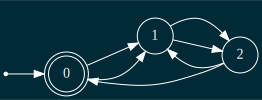

energy 26.599728312786215


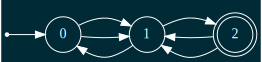

energy 26.60004631318058


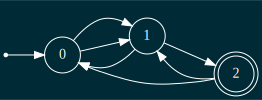

energy 26.869579032520296


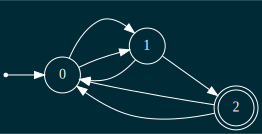

energy 27.31808913363686


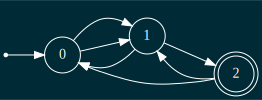

energy 27.33236649216631


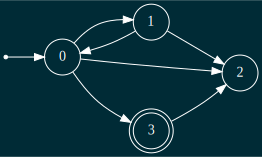

energy 27.33267480563072


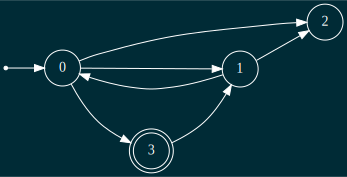

energy 27.34161837137087


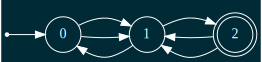

energy 27.45515234799447


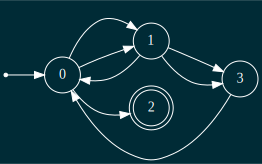

energy 27.714338925371372


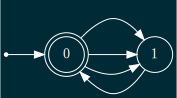

energy 27.873926474151283


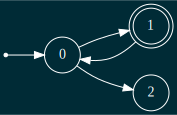

energy 28.03098545086575


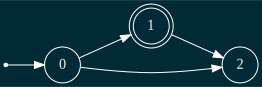

energy 28.04130321696953


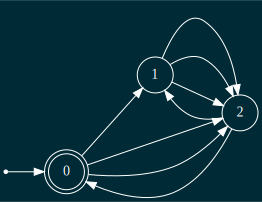

energy 28.345396577339613


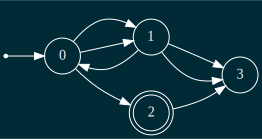

energy 28.345396577339613


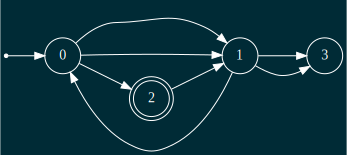

energy 28.902177225601097


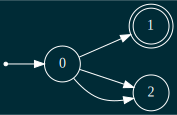

energy 29.316655068071615


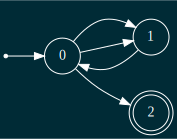

energy 29.33160999379558


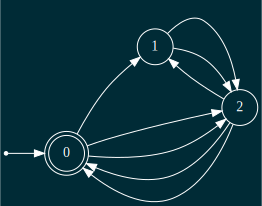

energy 29.72395713203743


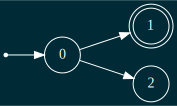

energy 29.75075799186216


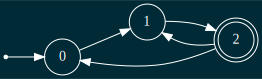

energy 29.830119470686807


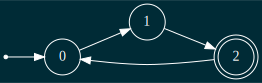

energy 29.89759972251682


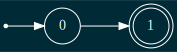

energy 30.498475944637594


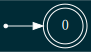

energy 30.498475944637594


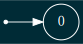

energy 30.694303092639128


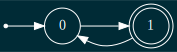

energy 31.23994665090918


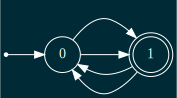

energy 32.93882536544495


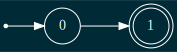

energy 37.37087153786812


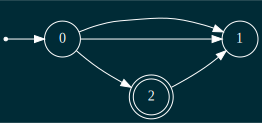

energy 38.329354200395024


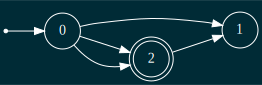

In [133]:
n_iters =100

dfa_search = diss(
    demos=[to_demo(TRC4), to_demo(TRC5)],
    to_concept=identifer,
    to_chain=to_chain,
    competency=lambda *_: 0.8,
    lift_path=lambda x: lift_path(x),
    n_iters=n_iters,
    reset_period=10,
    surprise_weight=1,  # Rescale surprise to make comparable to size.
    size_weight=1,
    sgs_temp=1/100,
)

df_greed4 = analyze(dfa_search, n_iters)

In [134]:
df_greed4['treatment'] = r'$\beta$ = 1/100'
df_greed4['iteration'] = df_greed4.index

<AxesSubplot:>

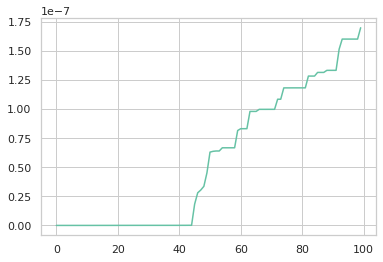

In [135]:
df_greed4['probability mass explored'].plot()

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

{'conjecture': +: set()
--------------
-: {('blue', 'green')},
 'data': +: set()
--------------
-: set(),
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0.03085302, -0.03092861, -0.95878705]),
 'pivot': 24,
 'surprisal': 30.498475944637594}


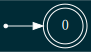

('green', 'blue', 'yellow') 1.0
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
{'conjecture': +: {('blue', 'green')}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue', 'green')},
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0.03085302, -0.03092861, -0.95878705]),
 'pivot': 19,
 'surprisal': 30.498475944637594}


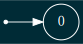

('green', 'blue', 'yellow') 0.5
('green', 'yellow') 0.5
('blue', 'green', 'yellow') 0.5
('blue', 'yellow') 0.5
{'conjecture': +: set()
--------------
-: {('blue',)},
 'data': +: {('blue', 'green')}
--------------
-: set(),
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0.03085302, -0.03092861, -0.95878705]),
 'pivot': 39,
 'surprisal': 30.498475944637594}


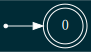

('green', 'blue', 'yellow') 0.5
('green', 'yellow') 0.5
('blue', 'green', 'yellow') 0.5
('blue', 'yellow') 0.5
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: {('blue', 'green')}
--------------
-: {('blue',)},
 'energy': 32.93882536544495,
 'grad': array([ 1.82216891,  0.        ,  0.86342555, -0.02876151,  0.08704962,
       -0.03058301,  0.04249801, -0.03095536,  0.03128032, -0.03096551,
        0.0314742 , -0.03098141,  0.03136329, -0.03099334,  0.02279482,
       -0.03073714,  0.01410559, -0.0302174 ,  0.04744537, -0.03075578,
        0.03492818, -0.03088616,  0.03189667, -0.03091774,  0.03116247,
       -0.03092539,  0.03098466, -0.03092724, -0.95874454, -0.61434639,
       -0.03596499, -0.08725395, -0.0321144 ,  0.00342312, -0.0312178 ,
        0.02640504, -0.0310674 ,  0.02156818, -0.03077055,  0.023513  ,
       -0.03054375,  0.03421733, -0.03065855, -0.95041502]),
 'pivot': 31,
 'surprisal': 32.245678184885}


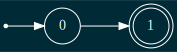

('green', 'blue', 'yellow') 0.5208732527988773
('green', 'yellow') 0.5208732527988773
('blue', 'green', 'yellow') 0.5208732527988773
('blue', 'yellow') 0.47912674720112275
{'conjecture': +: set()
--------------
-: {('yellow',)},
 'data': +: {('blue',), ('blue', 'green')}
--------------
-: set(),
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0.03085302, -0.03092861, -0.95878705]),
 'pivot': 41,
 'surprisal'

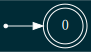

('green', 'blue', 'yellow') 0.5208732527988773
('green', 'yellow') 0.5208732527988773
('blue', 'green', 'yellow') 0.5208732527988773
('blue', 'yellow') 0.47912674720112275
{'conjecture': +: set()
--------------
-: {('blue',)},
 'data': +: {('blue',), ('blue', 'green')}
--------------
-: {('yellow',)},
 'energy': 32.90778132511766,
 'grad': array([ 1.65143996,  0.        ,  0.76810645, -0.02561606,  0.16226081,
       -0.02988621,  0.0602957 , -0.03083651,  0.03590604, -0.03099493,
        0.03172976, -0.03101789,  0.03117453, -0.03102279,  0.02737565,
       -0.03090881,  0.0293019 , -0.0308586 ,  0.03257127, -0.03091212,
        0.03139909, -0.03092734,  0.03127833, -0.03093831,  0.03177083,
       -0.03096432,  0.03362223, -0.03104738, -0.96246884, -0.47539116,
       -0.03513879, -0.06897063, -0.03188537,  0.00884559, -0.03116538,
        0.02893616, -0.03109572,  0.01604649, -0.03062543,  0.01626583,
       -0.03017669,  0.04839197, -0.03074592, -0.95312343]),
 'pivot': 0,
 'surpri

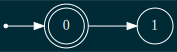

('green', 'blue', 'yellow') 0.49936901871685224
('green', 'yellow') 0.49936901871685224
('blue', 'green', 'yellow') 0.49936901871685224
('blue', 'yellow') 0.4593460161472467
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: {('blue', 'green')}
--------------
-: {('yellow',), ('blue',)},
 'energy': 32.93882536544495,
 'grad': array([ 1.82216891,  0.        ,  0.86342555, -0.02876151,  0.08704962,
       -0.03058301,  0.04249801, -0.03095536,  0.03128032, -0.03096551,
        0.0314742 , -0.03098141,  0.03136329, -0.03099334,  0.02279482,
       -0.03073714,  0.01410559, -0.0302174 ,  0.04744537, -0.03075578,
        0.03492818, -0.03088616,  0.03189667, -0.03091774,  0.03116247,
       -0.03092539,  0.03098466, -0.03092724, -0.95874454, -0.61434639,
       -0.03596499, -0.08725395, -0.0321144 ,  0.00342312, -0.0312178 ,
        0.02640504, -0.0310674 ,  0.02156818, -0.03077055,  0.023513  ,
       -0.03054375,  0.03421733, -0.03065855, -0.95041502]),
 'pivot': 15,
 'sur

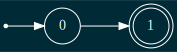

('green', 'blue', 'yellow') 0.49936901871685224
('green', 'yellow') 0.49936901871685224
('blue', 'green', 'yellow') 0.49936901871685224
('blue', 'yellow') 0.4593460161472467
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('blue',), ('blue', 'green')}
--------------
-: {('yellow',)},
 'energy': 32.90778132511766,
 'grad': array([ 1.65143996,  0.        ,  0.76810645, -0.02561606,  0.16226081,
       -0.02988621,  0.0602957 , -0.03083651,  0.03590604, -0.03099493,
        0.03172976, -0.03101789,  0.03117453, -0.03102279,  0.02737565,
       -0.03090881,  0.0293019 , -0.0308586 ,  0.03257127, -0.03091212,
        0.03139909, -0.03092734,  0.03127833, -0.03093831,  0.03177083,
       -0.03096432,  0.03362223, -0.03104738, -0.96246884, -0.47539116,
       -0.03513879, -0.06897063, -0.03188537,  0.00884559, -0.03116538,
        0.02893616, -0.03109572,  0.01604649, -0.03062543,  0.01626583,
       -0.03017669,  0.04839197, -0.03074592, -0.95312343]),
 

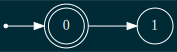

('green', 'blue', 'yellow') 0.49936901871685224
('green', 'yellow') 0.49936901871685224
('blue', 'green', 'yellow') 0.49936901871685224
('blue', 'yellow') 0.4593460161472467
{'conjecture': +: {('yellow',)}
--------------
-: set(),
 'data': +: {('blue',), ('blue', 'green', 'yellow'), ('blue', 'green')}
--------------
-: {('yellow',)},
 'energy': 36.581491599688185,
 'grad': array([ 1.74671657,  0.        ,  0.70906133, -0.02386394,  0.19516329,
       -0.02921705,  0.07070361, -0.0305135 ,  0.04056103, -0.03082749,
        0.03326087, -0.03090353,  0.03149287, -0.03092195,  0.03106468,
       -0.03092641,  0.03096098, -0.03092749,  0.03093586, -0.03092775,
        0.03092978, -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.61192138,
       -0.03375657, -0.04500751, -0.03129519,  0.02854402, -0.03120922,
        0.02772714, -0.03110041,  0.02344493, -0.03086117,  0.02673965,
       -0.03073237,  0.03063077, -0.0307292 , -0

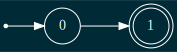

('green', 'blue', 'yellow') 0.49989308073518596
('green', 'yellow') 0.4988462777247319
('blue', 'green', 'yellow') 0.49989308073518596
('blue', 'yellow') 0.4599119743651577
{'conjecture': +: set()
--------------
-: {('blue', 'red', 'blue')},
 'data': +: {('yellow',), ('blue',), ('blue', 'green', 'yellow'), ('blue', 'green')}
--------------
-: set(),
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0.03085302,

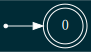

('green', 'blue', 'yellow') 0.49989308073518596
('green', 'yellow') 0.4988462777247319
('blue', 'green', 'yellow') 0.49989308073518596
('blue', 'yellow') 0.4599119743651577
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue', 'green')},
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0.03085302, -0.03092861, -0.95878705]),
 'pivot': 36,
 'surprisal': 30.4984759

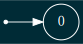

('green', 'blue', 'yellow') 0.49989308073518596
('green', 'yellow') 0.4988462777247319
('blue', 'green', 'yellow') 0.49989308073518596
('blue', 'yellow') 0.4599119743651577
{'conjecture': +: set()
--------------
-: {('blue',)},
 'data': +: {('blue',)}
--------------
-: {('blue', 'green')},
 'energy': 32.32064475793423,
 'grad': array([ 1.55387214,  0.        ,  0.73331155, -0.02443344,  0.1826956 ,
       -0.02937913,  0.07330121, -0.0307517 ,  0.03640808, -0.03092846,
        0.03260681, -0.03098091,  0.03420951, -0.0310818 ,  0.03139736,
       -0.03109166,  0.02856563, -0.03101272,  0.02895418, -0.03094839,
        0.03044984, -0.03093281,  0.03081207, -0.03092904,  0.0308998 ,
       -0.03092813,  0.03092104, -0.03092791, -0.95876508, -0.3848762 ,
       -0.03501367, -0.06558578, -0.03186994,  0.00935458, -0.03116633,
        0.02720929, -0.03104267,  0.01960346, -0.0306852 ,  0.02455291,
       -0.03049357,  0.03520646, -0.03064084, -0.94986614]),
 'pivot': 8,
 'surprisal': 31.627

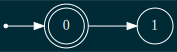

('green', 'blue', 'yellow') 0.4653688104808048
('green', 'yellow') 0.4643943031500246
('blue', 'green', 'yellow') 0.4653688104808048
('blue', 'yellow') 0.4972122405155708
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue',), ('blue', 'green')},
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0.03085302, -0.03092861, -0.95878705]),
 'pivot': 5,
 'surprisal': 30

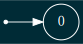

('green', 'blue', 'yellow') 0.4653688104808048
('green', 'yellow') 0.4643943031500246
('blue', 'green', 'yellow') 0.4653688104808048
('blue', 'yellow') 0.4972122405155708
{'conjecture': +: {('blue', 'green', 'red')}
--------------
-: set(),
 'data': +: {('blue',)}
--------------
-: {('blue', 'green')},
 'energy': 32.32064475793423,
 'grad': array([ 1.55387214,  0.        ,  0.73331155, -0.02443344,  0.1826956 ,
       -0.02937913,  0.07330121, -0.0307517 ,  0.03640808, -0.03092846,
        0.03260681, -0.03098091,  0.03420951, -0.0310818 ,  0.03139736,
       -0.03109166,  0.02856563, -0.03101272,  0.02895418, -0.03094839,
        0.03044984, -0.03093281,  0.03081207, -0.03092904,  0.0308998 ,
       -0.03092813,  0.03092104, -0.03092791, -0.95876508, -0.3848762 ,
       -0.03501367, -0.06558578, -0.03186994,  0.00935458, -0.03116633,
        0.02720929, -0.03104267,  0.01960346, -0.0306852 ,  0.02455291,
       -0.03049357,  0.03520646, -0.03064084, -0.94986614]),
 'pivot': 15,
 'surp

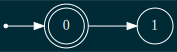

('green', 'blue', 'yellow') 0.4653688104808048
('green', 'yellow') 0.4643943031500246
('blue', 'green', 'yellow') 0.4653688104808048
('blue', 'yellow') 0.4972122405155708
{'conjecture': +: {('blue', 'green')}
--------------
-: set(),
 'data': +: {('blue',), ('blue', 'green', 'red')}
--------------
-: {('blue', 'green')},
 'energy': 31.03762665876833,
 'grad': array([ 1.52120956,  0.        ,  0.71761682, -0.02391108,  0.19496546,
       -0.02925653,  0.07639107, -0.03072949,  0.03693449, -0.03092339,
        0.03271248, -0.0309793 ,  0.03408428, -0.03107633,  0.03091694,
       -0.03107135,  0.02749842, -0.0309597 ,  0.01896225, -0.03058478,
        0.03262099, -0.03064841,  0.03742452, -0.03086016,  0.03250125,
       -0.03091145,  0.0313089 , -0.03092387, -0.95863984, -0.36079481,
       -0.0347774 , -0.05998924, -0.03181595,  0.01065481, -0.03115466,
        0.02747882, -0.03103979,  0.01974557, -0.03068685,  0.02456502,
       -0.03049554,  0.03516947, -0.0306416 , -0.94988961]),
 

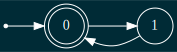

('green', 'blue', 'yellow') 0.37254937857201836
('green', 'yellow') 0.37176924012629625
('blue', 'green', 'yellow') 0.37254937857201836
('blue', 'yellow') 0.5974950122763594
{'conjecture': +: set()
--------------
-: {()},
 'data': +: {('blue',), ('blue', 'green', 'red'), ('blue', 'green')}
--------------
-: set(),
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0.03085302, -0.03092861, -0.95878705]),
 'pivot

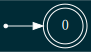

('green', 'blue', 'yellow') 0.37254937857201836
('green', 'yellow') 0.37176924012629625
('blue', 'green', 'yellow') 0.37254937857201836
('blue', 'yellow') 0.5974950122763594
{'conjecture': +: {('yellow',)}
--------------
-: set(),
 'data': +: {('blue',), ('blue', 'green', 'red'), ('blue', 'green')}
--------------
-: {()},
 'energy': 36.581491599688185,
 'grad': array([ 1.74671657,  0.        ,  0.70906133, -0.02386394,  0.19516329,
       -0.02921705,  0.07070361, -0.0305135 ,  0.04056103, -0.03082749,
        0.03326087, -0.03090353,  0.03149287, -0.03092195,  0.03106468,
       -0.03092641,  0.03096098, -0.03092749,  0.03093586, -0.03092775,
        0.03092978, -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.61192138,
       -0.03375657, -0.04500751, -0.03129519,  0.02854402, -0.03120922,
        0.02772714, -0.03110041,  0.02344493, -0.03086117,  0.02673965,
       -0.03073237,  0.03063077, -0.0307292 , -0.95260516]),

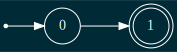

('green', 'blue', 'yellow') 0.37254937857201836
('green', 'yellow') 0.37176924012629625
('blue', 'green', 'yellow') 0.37254937857201836
('blue', 'yellow') 0.5974950122763594
{'conjecture': +: set()
--------------
-: {('blue',)},
 'data': +: {('blue',), ('blue', 'green', 'red'), ('blue', 'green')}
--------------
-: set(),
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0.03085302, -0.03092861, -0.95878705]),


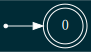

('green', 'blue', 'yellow') 0.37254937857201836
('green', 'yellow') 0.37176924012629625
('blue', 'green', 'yellow') 0.37254937857201836
('blue', 'yellow') 0.5974950122763594
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: {('blue', 'green', 'red'), ('blue', 'green')}
--------------
-: {('blue',)},
 'energy': 32.93882536544495,
 'grad': array([ 1.82216891,  0.        ,  0.86342555, -0.02876151,  0.08704962,
       -0.03058301,  0.04249801, -0.03095536,  0.03128032, -0.03096551,
        0.0314742 , -0.03098141,  0.03136329, -0.03099334,  0.02279482,
       -0.03073714,  0.01410559, -0.0302174 ,  0.04744537, -0.03075578,
        0.03492818, -0.03088616,  0.03189667, -0.03091774,  0.03116247,
       -0.03092539,  0.03098466, -0.03092724, -0.95874454, -0.61434639,
       -0.03596499, -0.08725395, -0.0321144 ,  0.00342312, -0.0312178 ,
        0.02640504, -0.0310674 ,  0.02156818, -0.03077055,  0.023513  ,
       -0.03054375,  0.03421733, -0.03065855, -0.95041502]),
 'pivo

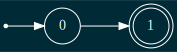

('green', 'blue', 'yellow') 0.37254937857201836
('green', 'yellow') 0.37176924012629625
('blue', 'green', 'yellow') 0.37254937857201836
('blue', 'yellow') 0.5974950122763594
{'conjecture': +: set()
--------------
-: {('blue',)},
 'data': +: {('blue',), ('blue', 'green', 'red'), ('blue', 'green')}
--------------
-: set(),
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0.03085302, -0.03092861, -0.95878705]),


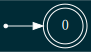

('green', 'blue', 'yellow') 0.37254937857201836
('green', 'yellow') 0.37176924012629625
('blue', 'green', 'yellow') 0.37254937857201836
('blue', 'yellow') 0.5974950122763594
{'conjecture': +: {('yellow',)}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue', 'green')},
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0.03085302, -0.03092861, -0.95878705]),
 'pivot': 43,
 'surprisal': 30.4984

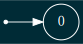

('green', 'blue', 'yellow') 0.37254937857201836
('green', 'yellow') 0.37176924012629625
('blue', 'green', 'yellow') 0.37254937857201836
('blue', 'yellow') 0.5974950122763594
{'conjecture': +: {('blue', 'green')}
--------------
-: set(),
 'data': +: {('yellow',)}
--------------
-: {('blue', 'green')},
 'energy': 29.89759972251682,
 'grad': array([ 1.75462351,  0.        ,  0.73608057, -0.02471602,  0.13258631,
       -0.02808696,  0.11847809, -0.03091169,  0.02704298, -0.03079079,
        0.03170447, -0.03081934,  0.04199009, -0.03116843,  0.02952635,
       -0.03111711,  0.02668276, -0.03097854,  0.0292518 , -0.03092458,
        0.02933128, -0.03087479,  0.02705725, -0.03075549,  0.02191566,
       -0.03047925,  0.01599322, -0.03002656, -0.93082328, -0.45355688,
       -0.03894483, -0.12613039, -0.03378623, -0.03241774, -0.03171736,
        0.0145721 , -0.03118157,  0.00809206, -0.03046002,  0.01215914,
       -0.02988812,  0.05510123, -0.03067603, -0.95095689]),
 'pivot': 23,
 'surpri

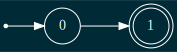

('green', 'blue', 'yellow') 0.6135582676777813
('green', 'yellow') 0.6130777867568605
('blue', 'green', 'yellow') 0.6135582676777813
('blue', 'yellow') 0.7521004531475942
{'conjecture': +: set()
--------------
-: {('blue',)},
 'data': +: {('yellow',), ('blue', 'green')}
--------------
-: set(),
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0.03085302, -0.03092861, -0.95878705]),
 'pivot': 12,
 'surprisal':

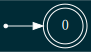

('green', 'blue', 'yellow') 0.6135582676777813
('green', 'yellow') 0.6130777867568605
('blue', 'green', 'yellow') 0.6135582676777813
('blue', 'yellow') 0.7521004531475942
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('yellow',), ('blue', 'green')}
--------------
-: {('blue',)},
 'energy': 32.09944286581337,
 'grad': array([ 1.80028692,  0.        ,  0.82550693, -0.02755518,  0.09578095,
       -0.02968724,  0.07185944, -0.03100512,  0.02692384, -0.03087758,
        0.03061905, -0.0308695 ,  0.03930413, -0.03113308,  0.02452998,
       -0.03092674,  0.0154407 , -0.0304428 ,  0.04220495, -0.03081037,
        0.03365901, -0.03089939,  0.03158929, -0.03092094,  0.03108803,
       -0.03092617,  0.03096663, -0.03092743, -0.95875036, -0.52684772,
       -0.03803688, -0.11423047, -0.03327853, -0.02193905, -0.03155298,
        0.01897008, -0.03115976,  0.00958036, -0.03048541,  0.0125634 ,
       -0.02992534,  0.05423576, -0.03068504, -0.95123637]),
 'pivot': 14,

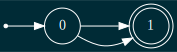

('green', 'blue', 'yellow') 0.6293060943505348
('green', 'yellow') 0.6288451934325727
('blue', 'green', 'yellow') 0.6293060943505348
('blue', 'yellow') 0.7622025688601661
{'conjecture': +: set()
--------------
-: {()},
 'data': +: {('yellow',), ('blue', 'green')}
--------------
-: {('blue',), ('blue', 'yellow')},
 'energy': 28.74495565133852,
 'grad': array([ 1.73971869,  0.        ,  0.84080105, -0.02797398,  0.11082843,
       -0.03056318,  0.04288882, -0.03094836,  0.03154967, -0.03096715,
        0.03113251, -0.03097231,  0.02951236, -0.03092669,  0.02325449,
       -0.03068693,  0.02140309, -0.03039681,  0.03883141, -0.0306604 ,
        0.02999482, -0.0306396 ,  0.02782948, -0.03055178,  0.03470461,
       -0.03068156,  0.03441457, -0.03079821, -0.95474458, -0.49922497,
       -0.03706648, -0.06332497, -0.03392925, -0.03611357, -0.03174041,
        0.0128621 , -0.03115047,  0.01724177, -0.03071582,  0.02241192,
       -0.03045632,  0.03473669, -0.03059008, -0.94829261]),
 'pivot':

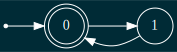

('green', 'blue', 'yellow') 0.2904399266720472
('green', 'yellow') 0.8287031132049136
('blue', 'green', 'yellow') 0.8289158300846924
('blue', 'yellow') 0.35177485200974934
{'conjecture': +: set()
--------------
-: {('blue', 'green')},
 'data': +: {('yellow',), ('blue', 'green')}
--------------
-: {('blue',), (), ('blue', 'yellow')},
 'energy': 24.38051341743705,
 'grad': array([ 1.4953807 ,  0.        ,  0.84827202, -0.02796883,  0.11153897,
       -0.0305804 ,  0.04138096, -0.03091792,  0.03179858, -0.03094544,
        0.03115403, -0.03095196,  0.02495149, -0.03076444,  0.02037778,
       -0.03043986,  0.02049019, -0.03012893,  0.02432026, -0.02994741,
        0.03100005, -0.02998031,  0.0358711 , -0.03016439,  0.04595142,
       -0.03065774,  0.03720761, -0.03086242, -0.95673504, -0.13998663,
       -0.04089573, -0.02326799, -0.03889062, -0.13802134, -0.03336212,
       -0.02818856, -0.03143866,  0.00843988, -0.03071995,  0.01590632,
       -0.03025702,  0.03992533, -0.03055916, -0.9

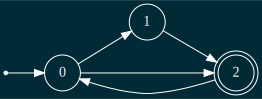

('green', 'blue', 'yellow') 0.006703409962524595
('green', 'yellow') 0.9960464345565401
('blue', 'green', 'yellow') 0.9960513441034727
('blue', 'yellow') 0.008119031961436995
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: {('yellow',)}
--------------
-: {('blue',), ('blue', 'green'), (), ('blue', 'yellow')},
 'energy': 30.432635498950795,
 'grad': array([ 1.87422796,  0.        ,  0.70607278, -0.02389508,  0.1944395 ,
       -0.02922459,  0.07052832, -0.03051533,  0.04051858, -0.03082793,
        0.03325059, -0.03090364,  0.03149038, -0.03092198,  0.03106408,
       -0.03092642,  0.03096083, -0.03092749,  0.03093583, -0.03092775,
        0.03092977, -0.03092781,  0.0309283 , -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.40630239,
       -0.04404237, -0.03296317, -0.04163595, -0.19189495, -0.03433811,
       -0.05613812, -0.03151073,  0.00511789, -0.03068595,  0.0102247 ,
       -0.03004654,  0.05141801, -0.0307144 , -0.95214

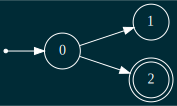

('green', 'blue', 'yellow') 0.006688037113394804
('green', 'yellow') 0.996055501220436
('blue', 'green', 'yellow') 0.9937671115824078
('blue', 'yellow') 0.00810041268346938
{'conjecture': +: set()
--------------
-: {('yellow', 'blue')},
 'data': +: {('yellow',), ('blue',)}
--------------
-: {('blue', 'yellow'), (), ('blue', 'green')},
 'energy': 32.49352234725109,
 'grad': array([ 1.60422275,  0.        ,  0.76277415, -0.02540332,  0.17147267,
       -0.02996798,  0.05660029, -0.03080024,  0.037024  , -0.03099474,
        0.03201587, -0.03102665,  0.03073786, -0.03101762,  0.03023436,
       -0.03099314,  0.03047791, -0.03097704,  0.02752824, -0.03086927,
        0.02860522, -0.03079852,  0.02976911, -0.03076635,  0.03095963,
       -0.03077239,  0.0287435 , -0.03070899, -0.95197855, -0.44693644,
       -0.03459857, -0.05893388, -0.03167568,  0.01456692, -0.03114104,
        0.02815788, -0.03104781,  0.02146071, -0.03074821,  0.02442648,
       -0.03055066,  0.03404447, -0.03065984, -0

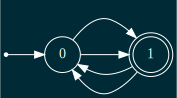

('green', 'blue', 'yellow') 0.006686084579127304
('green', 'yellow') 0.996056652794344
('blue', 'green', 'yellow') 0.9937689312386111
('blue', 'yellow') 0.00809804781421444
{'conjecture': +: {('yellow',)}
--------------
-: set(),
 'data': +: {('yellow',), ('blue',)}
--------------
-: {('blue', 'green'), ('yellow', 'blue'), (), ('blue', 'yellow')},
 'energy': 31.767765651815672,
 'grad': array([ 1.59134691,  0.        ,  0.75595629, -0.02517768,  0.17247225,
       -0.02978064,  0.06266977, -0.03080842,  0.03519179, -0.0309454 ,
        0.03188833, -0.03097487,  0.03235292, -0.03101794,  0.03100595,
       -0.03101756,  0.03336806, -0.03109101,  0.02422485, -0.03087645,
        0.02717102, -0.03076065,  0.02860087, -0.03069316,  0.02965815,
       -0.03066081,  0.02718929, -0.03055233, -0.9471222 , -0.42869378,
       -0.03477886, -0.06191726, -0.03175711,  0.01223385, -0.03114701,
        0.02793694, -0.03104669,  0.01944528, -0.03068415,  0.02354848,
       -0.03046116,  0.0355913 , -

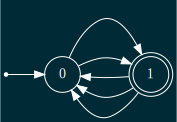

('green', 'blue', 'yellow') 0.006682053678624639
('green', 'yellow') 0.9960590301558692
('blue', 'green', 'yellow') 0.9937726878195973
('blue', 'yellow') 0.008093165670619245
{'conjecture': +: {('yellow',)}
--------------
-: set(),
 'data': +: {('yellow',), ('blue',)}
--------------
-: {('yellow', 'blue'), ('blue', 'yellow'), (), ('blue', 'green')},
 'energy': 32.10490815113448,
 'grad': array([ 1.60797482,  0.        ,  0.7640846 , -0.02544793,  0.16666609,
       -0.029861  ,  0.06064098, -0.03082287,  0.0348753 , -0.03094951,
        0.03179461, -0.03097592,  0.03229248, -0.03101706,  0.03087752,
       -0.0310127 ,  0.0327564 , -0.03106719,  0.02459264, -0.03086486,
        0.02975069, -0.03083005,  0.02788556, -0.03073803,  0.02844112,
       -0.03066625,  0.02709672, -0.0305547 , -0.94719583, -0.44331472,
       -0.03482534, -0.06308209, -0.03176573,  0.01201709, -0.03114859,
        0.02789879, -0.03104703,  0.01958346, -0.03068879,  0.02351964,
       -0.03046476,  0.03552074, 

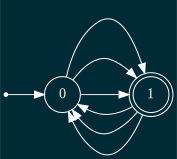

('green', 'blue', 'yellow') 0.0071093336277625995
('green', 'yellow') 0.9956305711178346
('blue', 'green', 'yellow') 0.9937753665244788
('blue', 'yellow') 0.008089684360904754
{'conjecture': +: {('blue', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow',), ('blue', 'green')}
--------------
-: {('blue',), (), ('blue', 'yellow')},
 'energy': 32.09108694844526,
 'grad': array([ 1.84515754,  0.        ,  0.86276782, -0.02876341,  0.08700243,
       -0.03058338,  0.04248884, -0.03095542,  0.03127879, -0.03096553,
        0.03147387, -0.03098141,  0.03136322, -0.03099334,  0.02279481,
       -0.03073714,  0.01410559, -0.0302174 ,  0.04744537, -0.03075578,
        0.03492818, -0.03088616,  0.03189667, -0.03091774,  0.03116247,
       -0.03092539,  0.03098466, -0.03092724, -0.95874454, -0.55086996,
       -0.03864458, -0.07885935, -0.03497258, -0.05712836, -0.03209442,
        0.00440489, -0.03122913,  0.00805419, -0.03050491,  0.01207367,
       -0.02992893,  0.05415232, -0.03068591,

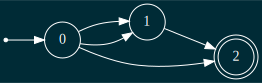

('green', 'blue', 'yellow') 0.007106234309135167
('green', 'yellow') 0.9951965253216075
('blue', 'green', 'yellow') 0.9937780801574986
('blue', 'yellow') 0.008086157657736414
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: {('yellow',), ('blue', 'yellow'), ('blue', 'green')}
--------------
-: {('blue',), ()},
 'energy': 27.97345974276202,
 'grad': array([ 1.53497523,  0.        ,  0.7236176 , -0.02411205,  0.16609019,
       -0.02854887,  0.09856351, -0.03073682,  0.03123932, -0.03075253,
        0.0332573 , -0.0308308 ,  0.03946052, -0.03110048,  0.03098143,
       -0.03109676,  0.02382159, -0.03086941,  0.02065339, -0.03055016,
        0.02515561, -0.03038158,  0.03102526, -0.03040169,  0.03272997,
       -0.03047445,  0.03893554, -0.03073886, -0.95290472, -0.33393009,
       -0.03603366, -0.07895376, -0.0324403 , -0.00406928, -0.03129938,
        0.02419   , -0.03107721,  0.01510192, -0.03057798,  0.02091186,
       -0.03027592,  0.03813009, -0.03052136, -0.946162

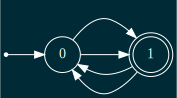

('green', 'blue', 'yellow') 0.032996014842741346
('green', 'yellow') 0.9953217762895552
('blue', 'green', 'yellow') 0.9939403171910929
('blue', 'yellow') 0.03395038661542209
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'red')},
 'data': +: {('yellow',), ('blue', 'green'), ('blue',), ('blue', 'yellow')}
--------------
-: {()},
 'energy': 35.20351260923749,
 'grad': array([ 1.7472601 ,  0.        ,  0.70904859, -0.02386408,  0.19516021,
       -0.02921708,  0.07070286, -0.03051351,  0.04056085, -0.03082749,
        0.03326083, -0.03090353,  0.03149286, -0.03092195,  0.03106468,
       -0.03092641,  0.03096098, -0.03092749,  0.03093586, -0.03092775,
        0.03092978, -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.611898  ,
       -0.03377376, -0.04518751, -0.03130622,  0.02657915, -0.0311585 ,
        0.02964498, -0.0311112 ,  0.01332567, -0.0305554 ,  0.01484063,
       -0.03006431,  0.05100469, -0.03071

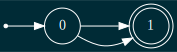

('green', 'blue', 'yellow') 0.03301428210993052
('green', 'yellow') 0.9953218646639197
('blue', 'green', 'yellow') 0.9939404316620223
('blue', 'yellow') 0.03396863585397391
{'conjecture': +: set()
--------------
-: {('blue',)},
 'data': +: {('yellow',), ('blue',), ('blue', 'yellow'), ('blue', 'green')}
--------------
-: {(), ('blue', 'green', 'red')},
 'energy': 30.33533598468941,
 'grad': array([ 1.47031017,  0.        ,  0.6939495 , -0.02312177,  0.20058505,
       -0.0286675 ,  0.09158535, -0.03063368,  0.03608181, -0.03080394,
        0.03296799, -0.03087156,  0.03574326, -0.0310238 ,  0.03265961,
       -0.03107492,  0.03194946, -0.03110225,  0.01688028, -0.03065781,
        0.03119709, -0.03067467,  0.03681399, -0.03086652,  0.03235339,
       -0.03091299,  0.03127309, -0.03092424, -0.9586514 , -0.31025099,
       -0.034816  , -0.06093115, -0.0318239 ,  0.01026468, -0.03115018,
        0.02831335, -0.03106152,  0.01462449, -0.03054787,  0.01886213,
       -0.03018269,  0.04117194

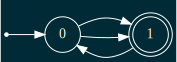

('green', 'blue', 'yellow') 0.035384682533916426
('green', 'yellow') 0.9953333323141434
('blue', 'green', 'yellow') 0.993955285659441
('blue', 'yellow') 0.036336696842663455
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('yellow',), ('blue', 'green'), ('blue', 'yellow')}
--------------
-: {('blue',), (), ('blue', 'green', 'red')},
 'energy': 28.41910017772558,
 'grad': array([ 1.49189006,  0.        ,  0.70123023, -0.02337037,  0.17254871,
       -0.02803219,  0.1145175 , -0.03073486,  0.03026929, -0.03072031,
        0.03334279, -0.03080226,  0.04150668, -0.03113677,  0.03097487,
       -0.03113171,  0.02219685, -0.0308525 ,  0.01893513, -0.03048008,
        0.02588461, -0.03033647,  0.03052183, -0.03034227,  0.04205066,
       -0.03070815,  0.03603544, -0.03087463, -0.95711356, -0.29447853,
       -0.03596219, -0.07503462, -0.03249354, -0.00517375, -0.03131643,
        0.02399152, -0.03108753,  0.01301994, -0.03052292,  0.01898022,
       -0.03016221,  

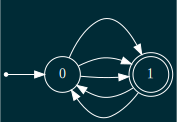

('green', 'blue', 'yellow') 0.051189582013706325
('green', 'yellow') 0.9954097941039833
('blue', 'green', 'yellow') 0.9940543262830002
('blue', 'yellow') 0.05212599788628857
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'blue')},
 'data': +: {('yellow',), ('blue', 'green')}
--------------
-: {('blue',), (), ('blue', 'green', 'red'), ('blue', 'yellow')},
 'energy': 25.767157772126655,
 'grad': array([ 1.53284147,  0.        ,  0.8433036 , -0.02785015,  0.11526241,
       -0.03058179,  0.04111296, -0.03091089,  0.03147979, -0.03092866,
        0.03132651, -0.0309411 ,  0.02301773, -0.03069349,  0.01858483,
       -0.0303151 ,  0.0192411 , -0.02996903,  0.03316302, -0.03006884,
        0.04266883, -0.03046259,  0.04174468, -0.03081516,  0.03354754,
       -0.03090055,  0.03156229, -0.03092123, -0.95855801, -0.19484031,
       -0.04031562, -0.03046134, -0.03810384, -0.12103088, -0.03313088,
       -0.02247832, -0.03139309,  0.00730192, -0.03064024,  0.01323953,
       -0.030

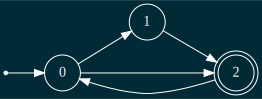

('green', 'blue', 'yellow') 0.04153784466378706
('green', 'yellow') 0.996275272194399
('blue', 'green', 'yellow') 0.9951753762862886
('blue', 'yellow') 0.04229770039079048
{'conjecture': +: set()
--------------
-: {('yellow',)},
 'data': +: {('yellow',), ('blue', 'green')}
--------------
-: {(),
 ('blue',),
 ('blue', 'green', 'blue'),
 ('blue', 'green', 'red'),
 ('blue', 'yellow')},
 'energy': 36.78700048286283,
 'grad': array([ 1.75536104,  0.        ,  0.84401337, -0.02808964,  0.11185194,
       -0.03070721,  0.03768796, -0.03092536,  0.03130604, -0.03093725,
        0.0308077 , -0.03093321,  0.02238843, -0.03066618,  0.02189257,
       -0.03039201,  0.02503789, -0.03022469,  0.04053072, -0.03054675,
        0.03586381, -0.03071291,  0.03309946, -0.03078749,  0.0364271 ,
       -0.03096373,  0.03993855, -0.03124419, -0.96856995, -0.58518823,
       -0.03485368, -0.05982241, -0.03189505,  0.00840178, -0.03116089,
        0.02687961, -0.0310271 ,  0.02064329, -0.0307026 ,  0.02681471,

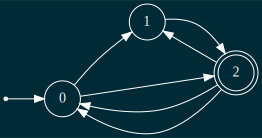

('green', 'blue', 'yellow') 0.041537716427879984
('green', 'yellow') 0.9962752836934032
('blue', 'green', 'yellow') 0.9951723039743254
('blue', 'yellow') 0.042297569809051805
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: {('blue', 'green')}
--------------
-: {(),
 ('blue',),
 ('blue', 'green', 'blue'),
 ('blue', 'green', 'red'),
 ('blue', 'yellow'),
 ('yellow',)},
 'energy': 30.91354852656712,
 'grad': array([ 1.76546815,  0.        ,  0.84227246, -0.0280451 ,  0.11057853,
       -0.03062427,  0.04073832, -0.03094034,  0.03140438, -0.03095484,
        0.03098542, -0.0309558 ,  0.02633808, -0.03081149,  0.02209343,
       -0.03053905,  0.02304546, -0.03030488,  0.03640903, -0.03049563,
        0.03250136, -0.03055831,  0.02920079, -0.03051589,  0.03542414,
       -0.03066927,  0.03467723, -0.03079452, -0.95463012, -0.59337616,
       -0.03490378, -0.06352011, -0.03182804,  0.01018144, -0.03115158,
        0.02762103, -0.03104125,  0.02567599, -0.03087359,  0.0239815

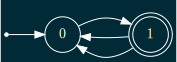

('green', 'blue', 'yellow') 0.04149218201523279
('green', 'yellow') 0.9962793667962765
('blue', 'green', 'yellow') 0.9951775961839574
('blue', 'yellow') 0.04225120243108092
{'conjecture': +: set()
--------------
-: {('blue', 'green')},
 'data': +: {('blue',), ('blue', 'green')}
--------------
-: {(),
 ('blue', 'green', 'blue'),
 ('blue', 'green', 'red'),
 ('blue', 'yellow'),
 ('yellow',)},
 'energy': 32.5738385466441,
 'grad': array([ 1.61005118,  0.        ,  0.76598489, -0.02550934,  0.16587556,
       -0.02989579,  0.05909241, -0.03080818,  0.03523675, -0.03094657,
        0.03197758, -0.03097879,  0.03062955, -0.03096788,  0.02972483,
       -0.03092903,  0.03057279, -0.0309179 ,  0.0265345 , -0.03078092,
        0.03062196, -0.03077595,  0.03114386, -0.03078745,  0.0338116 ,
       -0.03088195,  0.03521002, -0.03101721, -0.96153341, -0.4450398 ,
       -0.03483429, -0.06368295, -0.03175563,  0.01236867, -0.03114978,
        0.0278027 , -0.03104519,  0.02148446, -0.03074641,  0.024

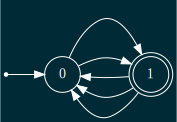

('green', 'blue', 'yellow') 0.041483537948398916
('green', 'yellow') 0.9960718119024742
('blue', 'green', 'yellow') 0.9949702708220415
('blue', 'yellow') 0.04224240023751366
{'conjecture': +: set()
--------------
-: {('blue',)},
 'data': +: {('blue',)}
--------------
-: {(),
 ('blue', 'green'),
 ('blue', 'green', 'blue'),
 ('blue', 'green', 'red'),
 ('blue', 'yellow'),
 ('yellow',)},
 'energy': 34.4658501693308,
 'grad': array([ 1.64019231,  0.        ,  0.78687644, -0.02619164,  0.15418055,
       -0.03019129,  0.05046291, -0.03082478,  0.03713911, -0.0310221 ,
        0.03222449, -0.03105968,  0.02874299, -0.03098728,  0.02989581,
       -0.03095317,  0.0280116 , -0.03086125,  0.03247597, -0.03091171,
        0.03130277, -0.03092393,  0.03101864, -0.03092689,  0.03094983,
       -0.03092761,  0.03093316, -0.03092778, -0.95876117, -0.48189339,
       -0.03459509, -0.06107745, -0.03160532,  0.01699702, -0.03114881,
        0.02810057, -0.03105356,  0.02291441, -0.03079921,  0.02581105,

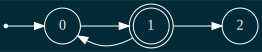

('green', 'blue', 'yellow') 0.04148223501030448
('green', 'yellow') 0.9960405267235164
('blue', 'green', 'yellow') 0.9949390202409003
('blue', 'yellow') 0.042241073464649254
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: {('yellow',), ('blue', 'green')}
--------------
-: {('blue',), (), ('blue', 'yellow')},
 'energy': 32.132462950801354,
 'grad': array([ 1.77884753,  0.        ,  0.82264689, -0.02744487,  0.10644554,
       -0.02991364,  0.06386468, -0.03097461,  0.02958271, -0.03093111,
        0.0305582 , -0.03091946,  0.03662661, -0.03109781,  0.02417677,
       -0.03088153,  0.01640912, -0.03042926,  0.0425196 , -0.03080709,
        0.03373521, -0.03089859,  0.03160775, -0.03092075,  0.0310925 ,
       -0.03092612,  0.03096772, -0.03092742, -0.95875001, -0.51833229,
       -0.03765395, -0.09857934, -0.03339666, -0.02445596, -0.03158876,
        0.01796475, -0.03116301,  0.00942849, -0.03048381,  0.01282188,
       -0.02993187,  0.05408397, -0.03068663, -0.951285

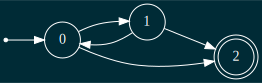

('green', 'blue', 'yellow') 0.0414688028246929
('green', 'yellow') 0.9960418088236723
('blue', 'green', 'yellow') 0.9949406590151728
('blue', 'yellow') 0.04222739556279395
{'conjecture': +: set()
--------------
-: {('blue', 'green')},
 'data': +: {('yellow',), ('blue',), ('blue', 'green')}
--------------
-: {(), ('blue', 'yellow')},
 'energy': 31.513804662849402,
 'grad': array([ 1.62032315,  0.        ,  0.77064818, -0.0256651 ,  0.16172922,
       -0.02991711,  0.05917975, -0.03083156,  0.0343984 , -0.03094303,
        0.03179049, -0.03096951,  0.03146698, -0.03098506,  0.02924114,
       -0.03093056,  0.02922943, -0.0308774 ,  0.03010063, -0.03085312,
        0.02930343, -0.0308047 ,  0.02979811, -0.03077324,  0.03186348,
       -0.03080731,  0.02969401, -0.03077252, -0.95394812, -0.45418563,
       -0.03485945, -0.06425094, -0.03176225,  0.01213145, -0.03114879,
        0.02790049, -0.03104728,  0.01945469, -0.03068501,  0.02351273,
       -0.03046088,  0.03564363, -0.03062284, -0.

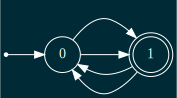

('green', 'blue', 'yellow') 0.04144388988775745
('green', 'yellow') 0.9960441867598662
('blue', 'green', 'yellow') 0.9943429351310918
('blue', 'yellow') 0.04220202689114333
{'conjecture': +: set()
--------------
-: {('blue',)},
 'data': +: {('yellow',), ('blue',)}
--------------
-: {('blue', 'green'), (), ('blue', 'yellow')},
 'energy': 32.61503849681035,
 'grad': array([ 1.59948377,  0.        ,  0.76029267, -0.02532114,  0.173311  ,
       -0.02994582,  0.05714078, -0.03079567,  0.03714363, -0.03099404,
        0.03204398, -0.03102685,  0.03081047, -0.03102009,  0.03049666,
       -0.03100373,  0.03138391, -0.03101561,  0.02436059, -0.03080764,
        0.02947056, -0.03076586,  0.03043519, -0.03075553,  0.03118422,
       -0.03076892,  0.02881054, -0.03070772, -0.95193943, -0.44282469,
       -0.0345836 , -0.05859833, -0.03167167,  0.01467006, -0.03114037,
        0.02817061, -0.03104756,  0.02137881, -0.03074541,  0.02444341,
       -0.03054847,  0.03409523, -0.03065931, -0.95043863

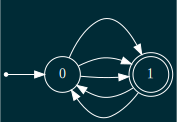

('green', 'blue', 'yellow') 0.04143561394588584
('green', 'yellow') 0.9960449766973097
('blue', 'green', 'yellow') 0.9943440647919451
('blue', 'yellow') 0.042193599556683135
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: {('yellow',)}
--------------
-: {('blue',), ('blue', 'yellow'), (), ('blue', 'green')},
 'energy': 31.0114975341684,
 'grad': array([ 1.88783889,  0.        ,  0.70575378, -0.0238984 ,  0.19436224,
       -0.02922539,  0.07050961, -0.03051552,  0.04051405, -0.03082798,
        0.0332495 , -0.03090365,  0.03149011, -0.03092198,  0.03106401,
       -0.03092642,  0.03096082, -0.03092749,  0.03093582, -0.03092775,
        0.03092977, -0.03092781,  0.0309283 , -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.42262263,
       -0.04394442, -0.03213401, -0.04156696, -0.19092611, -0.03430156,
       -0.05516119, -0.03150585,  0.00573511, -0.03070051,  0.01019529,
       -0.03005972,  0.05111147, -0.03071759, -0.95224525

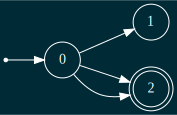

('green', 'blue', 'yellow') 0.0423861231854849
('green', 'yellow') 0.9960488984851903
('blue', 'green', 'yellow') 0.9933580765425634
('blue', 'yellow') 0.04215176052446573
{'conjecture': +: set()
--------------
-: {('blue',)},
 'data': +: {('yellow',), ('blue',)}
--------------
-: {('blue', 'green'), (), ('blue', 'yellow')},
 'energy': 32.49352234725109,
 'grad': array([ 1.60422275,  0.        ,  0.76277415, -0.02540332,  0.17147267,
       -0.02996798,  0.05660029, -0.03080024,  0.037024  , -0.03099474,
        0.03201587, -0.03102665,  0.03073786, -0.03101762,  0.03023436,
       -0.03099314,  0.03047791, -0.03097704,  0.02752824, -0.03086927,
        0.02860522, -0.03079852,  0.02976911, -0.03076635,  0.03095963,
       -0.03077239,  0.0287435 , -0.03070899, -0.95197855, -0.44693644,
       -0.03459857, -0.05893388, -0.03167568,  0.01456692, -0.03114104,
        0.02815788, -0.03104781,  0.02146071, -0.03074821,  0.02442648,
       -0.03055066,  0.03404447, -0.03065984, -0.9504551 ]

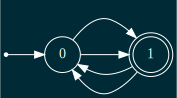

('green', 'blue', 'yellow') 0.0423861231854849
('green', 'yellow') 0.9960488984851903
('blue', 'green', 'yellow') 0.9933580765425634
('blue', 'yellow') 0.04215176052446573
{'conjecture': +: set()
--------------
-: {('yellow',)},
 'data': +: {('yellow',)}
--------------
-: {('blue',), ('blue', 'yellow'), (), ('blue', 'green')},
 'energy': 30.432635498950795,
 'grad': array([ 1.87422796,  0.        ,  0.70607278, -0.02389508,  0.1944395 ,
       -0.02922459,  0.07052832, -0.03051533,  0.04051858, -0.03082793,
        0.03325059, -0.03090364,  0.03149038, -0.03092198,  0.03106408,
       -0.03092642,  0.03096083, -0.03092749,  0.03093583, -0.03092775,
        0.03092977, -0.03092781,  0.0309283 , -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.40630239,
       -0.04404237, -0.03296317, -0.04163595, -0.19189495, -0.03433811,
       -0.05613812, -0.03151073,  0.00511789, -0.03068595,  0.0102247 ,
       -0.03004654,  0.05141801, -0.0307144 , -0.952146

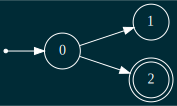

('green', 'blue', 'yellow') 0.0423861231854849
('green', 'yellow') 0.9960488984851903
('blue', 'green', 'yellow') 0.9933580765425634
('blue', 'yellow') 0.04215176052446573
{'conjecture': +: {('blue', 'yellow')}
--------------
-: set(),
 'data': +: set()
--------------
-: {('yellow',), ('blue', 'green'), ('blue',), (), ('blue', 'yellow')},
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0.03085302, -0.0309286

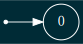

('green', 'blue', 'yellow') 0.0423861231854849
('green', 'yellow') 0.9960488984851903
('blue', 'green', 'yellow') 0.9933580765425634
('blue', 'yellow') 0.04215176052446573
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'yellow')}
--------------
-: {('yellow',), ('blue',), (), ('blue', 'green')},
 'energy': 32.10091469888473,
 'grad': array([ 1.65619927,  0.        ,  0.72906529, -0.02440067,  0.1255373 ,
       -0.02756119,  0.13484145, -0.0309137 ,  0.02527594, -0.03073752,
        0.03222274, -0.03078393,  0.04346544, -0.03118023,  0.03074009,
       -0.03116648,  0.02738066, -0.03104817,  0.02688254, -0.03091799,
        0.02697184, -0.03079468,  0.02267227, -0.03054085,  0.01649652,
       -0.03010197,  0.01276613, -0.02956022, -0.91636685, -0.41878247,
       -0.03705189, -0.13737844, -0.03160094,  0.01694787, -0.03114304,
        0.02826534, -0.03105311,  0.02147401, -0.03075376,  0.02398476,
       -0.03054223,  0.03344685, -0.030633  , -0.

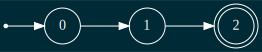

('green', 'blue', 'yellow') 0.042705462781049225
('green', 'yellow') 0.9957167417985491
('blue', 'green', 'yellow') 0.9933602914531886
('blue', 'yellow') 0.042471178273949084
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: set()
--------------
-: {('yellow',), ('blue', 'yellow'), ('blue',), (), ('blue', 'green')},
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0.03085302, -0.03092861, -0.

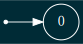

('green', 'blue', 'yellow') 0.042705462781049225
('green', 'yellow') 0.9957167417985491
('blue', 'green', 'yellow') 0.9933602914531886
('blue', 'yellow') 0.042471178273949084
{'conjecture': +: {('blue', 'green')}
--------------
-: set(),
 'data': +: {('blue',)}
--------------
-: {('yellow',), ('blue', 'green'), (), ('blue', 'yellow')},
 'energy': 32.38094023784961,
 'grad': array([ 1.59725885,  0.        ,  0.75915161, -0.02528331,  0.17420421,
       -0.02993709,  0.0573704 , -0.03079438,  0.03719098, -0.03099427,
        0.03205017, -0.03102727,  0.03096358, -0.03102528,  0.0307359 ,
       -0.03101624,  0.03178938, -0.0310404 ,  0.02491964, -0.03084912,
        0.02668649, -0.03071904,  0.02792392, -0.03063169,  0.03360013,
       -0.03072446,  0.03386924, -0.03082273, -0.9555047 , -0.44114987,
       -0.03456858, -0.05830376, -0.03166632,  0.01480795, -0.0311395 ,
        0.02814353, -0.03104587,  0.02137781, -0.03074375,  0.02460239,
       -0.03055183,  0.03376067, -0.03065211, -

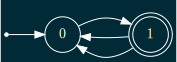

('green', 'blue', 'yellow') 0.04269470252054492
('green', 'yellow') 0.9954658565292527
('blue', 'green', 'yellow') 0.9931099999257215
('blue', 'yellow') 0.04246047704482307
{'conjecture': +: set()
--------------
-: {('yellow',)},
 'data': +: {('yellow',), ('blue', 'green')}
--------------
-: {('blue',), (), ('blue', 'yellow')},
 'energy': 35.17265744079533,
 'grad': array([ 1.76128164,  0.        ,  0.8428138 , -0.02805793,  0.10816809,
       -0.03056138,  0.04241615, -0.03093184,  0.03147579, -0.03094884,
        0.03140115, -0.03096297,  0.02677046, -0.03083195,  0.01954109,
       -0.03047911,  0.01766234, -0.03007859,  0.05078663, -0.03072572,
        0.03589273, -0.03088719,  0.03266167, -0.03094264,  0.03315615,
       -0.03101181,  0.03755947, -0.03121643, -0.96770918, -0.58011247,
       -0.03519154, -0.07050311, -0.03188858,  0.00872981, -0.03116487,
        0.02759959, -0.03105345,  0.01759698, -0.03063294,  0.02197759,
       -0.03036246,  0.04681035, -0.03087645, -0.957170

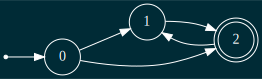

('green', 'blue', 'yellow') 0.04269404292265254
('green', 'yellow') 0.9954659265780246
('blue', 'green', 'yellow') 0.9930946571964323
('blue', 'yellow') 0.04245982106552085
{'conjecture': +: {('blue', 'yellow')}
--------------
-: set(),
 'data': +: {('blue', 'green')}
--------------
-: {('yellow',), ('blue',), (), ('blue', 'yellow')},
 'energy': 32.93882536544495,
 'grad': array([ 1.82216891,  0.        ,  0.86342555, -0.02876151,  0.08704962,
       -0.03058301,  0.04249801, -0.03095536,  0.03128032, -0.03096551,
        0.0314742 , -0.03098141,  0.03136329, -0.03099334,  0.02279482,
       -0.03073714,  0.01410559, -0.0302174 ,  0.04744537, -0.03075578,
        0.03492818, -0.03088616,  0.03189667, -0.03091774,  0.03116247,
       -0.03092539,  0.03098466, -0.03092724, -0.95874454, -0.61434639,
       -0.03596499, -0.08725395, -0.0321144 ,  0.00342312, -0.0312178 ,
        0.02640504, -0.0310674 ,  0.02156818, -0.03077055,  0.023513  ,
       -0.03054375,  0.03421733, -0.03065855, -0

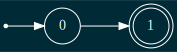

('green', 'blue', 'yellow') 0.04269404292265254
('green', 'yellow') 0.9954659265780246
('blue', 'green', 'yellow') 0.9930946571964323
('blue', 'yellow') 0.04245982106552085
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'yellow'), ('blue', 'green')}
--------------
-: {('yellow',), ('blue',), ()},
 'energy': 33.01347600862804,
 'grad': array([ 1.74830678,  0.        ,  0.82692781, -0.02754882,  0.09591047,
       -0.02968513,  0.07191851, -0.03100492,  0.02692816, -0.03087752,
        0.03062038, -0.03086948,  0.0393046 , -0.03113308,  0.02453001,
       -0.03092674,  0.0154407 , -0.0304428 ,  0.04220496, -0.03081037,
        0.03365901, -0.03089939,  0.03158929, -0.03092094,  0.03108803,
       -0.03092617,  0.03096663, -0.03092743, -0.95875036, -0.51520323,
       -0.03682716, -0.11432658, -0.0321036 ,  0.00359479, -0.0312127 ,
        0.0261357 , -0.03105404,  0.0206333 , -0.0307284 ,  0.02366769,
       -0.03050775,  0.0340425 , -0.03061821, -0

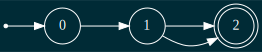

('green', 'blue', 'yellow') 0.042822163380734676
('green', 'yellow') 0.9953326990037308
('blue', 'green', 'yellow') 0.993095581368769
('blue', 'yellow') 0.04258797287054218
{'conjecture': +: set()
--------------
-: {('blue', 'green')},
 'data': +: {('blue', 'green')}
--------------
-: {('yellow',), ('blue',), (), ('blue', 'yellow')},
 'energy': 32.93882536544495,
 'grad': array([ 1.82216891,  0.        ,  0.86342555, -0.02876151,  0.08704962,
       -0.03058301,  0.04249801, -0.03095536,  0.03128032, -0.03096551,
        0.0314742 , -0.03098141,  0.03136329, -0.03099334,  0.02279482,
       -0.03073714,  0.01410559, -0.0302174 ,  0.04744537, -0.03075578,
        0.03492818, -0.03088616,  0.03189667, -0.03091774,  0.03116247,
       -0.03092539,  0.03098466, -0.03092724, -0.95874454, -0.61434639,
       -0.03596499, -0.08725395, -0.0321144 ,  0.00342312, -0.0312178 ,
        0.02640504, -0.0310674 ,  0.02156818, -0.03077055,  0.023513  ,
       -0.03054375,  0.03421733, -0.03065855, -0.

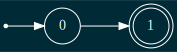

('green', 'blue', 'yellow') 0.042822163380734676
('green', 'yellow') 0.9953326990037308
('blue', 'green', 'yellow') 0.993095581368769
('blue', 'yellow') 0.04258797287054218
{'conjecture': +: {('yellow',)}
--------------
-: set(),
 'data': +: set()
--------------
-: {('yellow',), ('blue', 'green'), ('blue',), (), ('blue', 'yellow')},
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0.03085302, -0.03092861, -0.

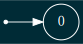

('green', 'blue', 'yellow') 0.042822163380734676
('green', 'yellow') 0.9953326990037308
('blue', 'green', 'yellow') 0.993095581368769
('blue', 'yellow') 0.04258797287054218
{'conjecture': +: {('blue', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow',)}
--------------
-: {('blue',), ('blue', 'yellow'), (), ('blue', 'green')},
 'energy': 25.129074982928234,
 'grad': array([ 0.75494007,  0.        ,  0.73230609, -0.02362181,  0.20079288,
       -0.02915841,  0.07206703, -0.0304993 ,  0.04089123, -0.03082405,
        0.03334085, -0.0309027 ,  0.03151224, -0.03092175,  0.03106937,
       -0.03092636,  0.03096211, -0.03092748,  0.03093614, -0.03092775,
        0.03092985, -0.03092781,  0.03092832, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288,  0.01535306,
       -0.02333441,  0.00583509, -0.02278756,  0.19495713, -0.02816786,
        0.10535161, -0.03057985,  0.01403275, -0.03006275,  0.01789267,
       -0.02968244,  0.05592881, -0.03050264, -

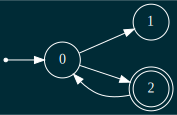

('green', 'blue', 'yellow') 0.03159370490410794
('green', 'yellow') 0.9965565184303342
('blue', 'green', 'yellow') 0.7326946203155631
('blue', 'yellow') 0.03142092181034924
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: {('yellow',), ('blue', 'yellow')}
--------------
-: {('blue',), (), ('blue', 'green')},
 'energy': 29.89759972251682,
 'grad': array([ 1.75462351,  0.        ,  0.73608057, -0.02471602,  0.13258631,
       -0.02808696,  0.11847809, -0.03091169,  0.02704298, -0.03079079,
        0.03170447, -0.03081934,  0.04199009, -0.03116843,  0.02952635,
       -0.03111711,  0.02668276, -0.03097854,  0.0292518 , -0.03092458,
        0.02933128, -0.03087479,  0.02705725, -0.03075549,  0.02191566,
       -0.03047925,  0.01599322, -0.03002656, -0.93082328, -0.45355688,
       -0.03894483, -0.12613039, -0.03378623, -0.03241774, -0.03171736,
        0.0145721 , -0.03118157,  0.00809206, -0.03046002,  0.01215914,
       -0.02988812,  0.05510123, -0.03067603, -0.95095689

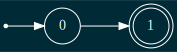

('green', 'blue', 'yellow') 0.03159370490410794
('green', 'yellow') 0.9965565184303342
('blue', 'green', 'yellow') 0.7326946203155631
('blue', 'yellow') 0.03142092181034924
{'conjecture': +: set()
--------------
-: {('yellow',)},
 'data': +: {('yellow',), ('blue',), ('blue', 'yellow')}
--------------
-: {(), ('blue', 'green')},
 'energy': 30.92606742851059,
 'grad': array([ 1.5122849 ,  0.        ,  0.71382227, -0.02378379,  0.19444677,
       -0.02911701,  0.08019954, -0.03071333,  0.03650651, -0.03089437,
        0.03287978, -0.03095641,  0.03463146, -0.03107126,  0.03137091,
       -0.03108062,  0.03066983, -0.03106779,  0.02553334, -0.03089484,
        0.02792787, -0.03080212,  0.02925151, -0.03075366,  0.02996901,
       -0.03072914,  0.0263917 , -0.0305936 , -0.94840148, -0.35087145,
       -0.03481733, -0.06151536, -0.03180693,  0.01081956, -0.03115108,
        0.02803171, -0.0310536 ,  0.01697622, -0.03061368,  0.02149878,
       -0.03032884,  0.03786947, -0.03056448, -0.947499

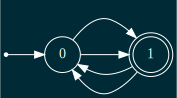

('green', 'blue', 'yellow') 0.03236418537757594
('green', 'yellow') 0.9965592581226757
('blue', 'green', 'yellow') 0.732907293009393
('blue', 'yellow') 0.032191539752977186
{'conjecture': +: {('blue', 'green')}
--------------
-: set(),
 'data': +: {('blue',), ('blue', 'yellow')}
--------------
-: {('yellow',), (), ('blue', 'green')},
 'energy': 32.04214143705801,
 'grad': array([ 1.53525066,  0.        ,  0.72090712, -0.02402762,  0.19251782,
       -0.02929293,  0.07549096, -0.03073662,  0.03678013, -0.03092548,
        0.03266965, -0.03097999,  0.03418087, -0.03108002,  0.03144343,
       -0.03109137,  0.0301345 , -0.03106147,  0.02466513, -0.03086158,
        0.02637256, -0.0307213 ,  0.02735757, -0.03061619,  0.03372369,
       -0.03071329,  0.03396426, -0.03081489, -0.95526151, -0.37930282,
       -0.0346241 , -0.06149029, -0.03162053,  0.01632713, -0.03114261,
        0.02783786, -0.03103934,  0.02209372, -0.03075978,  0.02579217,
       -0.03060455,  0.03319711, -0.03068556, -0.

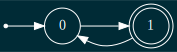

('green', 'blue', 'yellow') 0.032616299988313384
('green', 'yellow') 0.9962996075954407
('blue', 'green', 'yellow') 0.7327163362112965
('blue', 'yellow') 0.032443699346014564
{'conjecture': +: set()
--------------
-: {('blue',)},
 'data': +: {('yellow',), ('blue',), ('blue', 'yellow')}
--------------
-: {(), ('blue', 'green')},
 'energy': 31.300168553312403,
 'grad': array([ 1.52526738,  0.        ,  0.71822255, -0.02393397,  0.19451153,
       -0.02926452,  0.07621095, -0.0307316 ,  0.03689993, -0.03092436,
        0.03269784, -0.03097978,  0.03419461, -0.03108024,  0.03148578,
       -0.03109292,  0.0303812 , -0.03107068,  0.02547139, -0.0308957 ,
        0.02791021, -0.0308024 ,  0.02924582, -0.03075376,  0.02996709,
       -0.03072917,  0.02639113, -0.03059361, -0.94840193, -0.3667631 ,
       -0.03471374, -0.06033091, -0.03174359,  0.01251788, -0.03114279,
        0.0281777 , -0.03105013,  0.01756766, -0.0306288 ,  0.02150906,
       -0.03034381,  0.03819705, -0.03058923, -0.94826

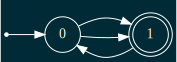

('green', 'blue', 'yellow') 0.03314533206840757
('green', 'yellow') 0.9963016312250416
('blue', 'green', 'yellow') 0.7328625053400792
('blue', 'yellow') 0.03297282581603574
{'conjecture': +: set()
--------------
-: {('yellow',)},
 'data': +: {('yellow',), ('blue', 'green')}
--------------
-: {('blue',), (), ('blue', 'yellow')},
 'energy': 33.93329558762623,
 'grad': array([ 1.89226262,  0.        ,  0.81376824, -0.02727817,  0.1194127 ,
       -0.03015737,  0.05341661, -0.03088423,  0.03312517, -0.03095426,
        0.03189074, -0.03098352,  0.03307282, -0.03104881,  0.02722384,
       -0.03092928,  0.01758596, -0.0305123 ,  0.04058899, -0.0308272 ,
        0.03326765, -0.03090346,  0.03149451, -0.03092193,  0.03106508,
       -0.03092641,  0.03096107, -0.03092749, -0.95875215, -0.65064549,
       -0.03695262, -0.08566889, -0.0331207 , -0.01879236, -0.03149842,
        0.02036008, -0.03115034,  0.00986552, -0.03048519,  0.01324662,
       -0.02994649,  0.05374416, -0.03069017, -0.951395

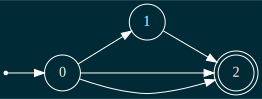

('green', 'blue', 'yellow') 0.03314402969352798
('green', 'yellow') 0.9963017765445269
('blue', 'green', 'yellow') 0.7328730019361529
('blue', 'yellow') 0.032971530219420106
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: {('blue', 'green')}
--------------
-: {('yellow',), ('blue',), (), ('blue', 'yellow')},
 'energy': 32.93882536544495,
 'grad': array([ 1.82216891,  0.        ,  0.86342555, -0.02876151,  0.08704962,
       -0.03058301,  0.04249801, -0.03095536,  0.03128032, -0.03096551,
        0.0314742 , -0.03098141,  0.03136329, -0.03099334,  0.02279482,
       -0.03073714,  0.01410559, -0.0302174 ,  0.04744537, -0.03075578,
        0.03492818, -0.03088616,  0.03189667, -0.03091774,  0.03116247,
       -0.03092539,  0.03098466, -0.03092724, -0.95874454, -0.61434639,
       -0.03596499, -0.08725395, -0.0321144 ,  0.00342312, -0.0312178 ,
        0.02640504, -0.0310674 ,  0.02156818, -0.03077055,  0.023513  ,
       -0.03054375,  0.03421733, -0.03065855, -0.9504150

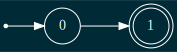

('green', 'blue', 'yellow') 0.03314402969352798
('green', 'yellow') 0.9963017765445269
('blue', 'green', 'yellow') 0.7328730019361529
('blue', 'yellow') 0.032971530219420106
{'conjecture': +: {('yellow',)}
--------------
-: set(),
 'data': +: {('blue',), ('blue', 'green')}
--------------
-: {('yellow',), (), ('blue', 'yellow')},
 'energy': 31.846184686014535,
 'grad': array([ 1.60410645,  0.        ,  0.76658269, -0.02552222,  0.16849195,
       -0.02999002,  0.05562114, -0.030791  ,  0.03699123, -0.03098475,
        0.03205169, -0.03101809,  0.03050333, -0.03100201,  0.02882525,
       -0.03093398,  0.02918253, -0.03087925,  0.03197409, -0.03091347,
        0.03098895, -0.03091582,  0.0303102 , -0.0308969 ,  0.02881021,
       -0.03083169,  0.02513465, -0.03065366, -0.95026336, -0.4459082 ,
       -0.03462719, -0.05958283, -0.03168312,  0.01425423, -0.03113847,
        0.02819026, -0.03104634,  0.02085799, -0.03072795,  0.0241188 ,
       -0.03052142,  0.03405467, -0.03063183, -0.9495

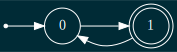

('green', 'blue', 'yellow') 0.03313353421735676
('green', 'yellow') 0.9959862849868693
('blue', 'green', 'yellow') 0.7326409284315287
('blue', 'yellow') 0.03296108936738895
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow',), ('blue',), ('blue', 'green')}
--------------
-: {(), ('blue', 'yellow')},
 'energy': 33.04478705458818,
 'grad': array([ 1.60992717,  0.        ,  0.76949127, -0.0256188 ,  0.1681    ,
       -0.03007133,  0.05310257, -0.03079106,  0.03753191, -0.03100171,
        0.03221343, -0.03103958,  0.02898478, -0.03097537,  0.02872728,
       -0.03090511,  0.02962572, -0.03086513,  0.03232651, -0.0309108 ,
        0.03113796, -0.0309179 ,  0.03057232, -0.0309071 ,  0.02962478,
       -0.03086703,  0.02738672, -0.03075827, -0.95350629, -0.45506242,
       -0.03451733, -0.05811345, -0.03162262,  0.01614317, -0.03113888,
        0.02835588, -0.03105192,  0.02156421, -0.03075542,  0.0243659 ,
       -0.03055575,  0.03402175, -0.030

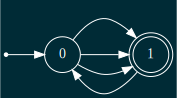

('green', 'blue', 'yellow') 0.033130369924083324
('green', 'yellow') 0.9959866683015901
('blue', 'green', 'yellow') 0.7325709603216836
('blue', 'yellow') 0.0329579415428108
{'conjecture': +: {('blue', 'yellow')}
--------------
-: set(),
 'data': +: {('blue',), ('blue', 'green')}
--------------
-: {('yellow',), (), ('blue', 'yellow')},
 'energy': 31.846184686014535,
 'grad': array([ 1.60410645,  0.        ,  0.76658269, -0.02552222,  0.16849195,
       -0.02999002,  0.05562114, -0.030791  ,  0.03699123, -0.03098475,
        0.03205169, -0.03101809,  0.03050333, -0.03100201,  0.02882525,
       -0.03093398,  0.02918253, -0.03087925,  0.03197409, -0.03091347,
        0.03098895, -0.03091582,  0.0303102 , -0.0308969 ,  0.02881021,
       -0.03083169,  0.02513465, -0.03065366, -0.95026336, -0.4459082 ,
       -0.03462719, -0.05958283, -0.03168312,  0.01425423, -0.03113847,
        0.02819026, -0.03104634,  0.02085799, -0.03072795,  0.0241188 ,
       -0.03052142,  0.03405467, -0.03063183, -

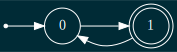

('green', 'blue', 'yellow') 0.033130369924083324
('green', 'yellow') 0.9959866683015901
('blue', 'green', 'yellow') 0.7325709603216836
('blue', 'yellow') 0.0329579415428108
{'conjecture': +: set()
--------------
-: {('yellow', 'blue')},
 'data': +: {('blue',), ('blue', 'yellow'), ('blue', 'green')}
--------------
-: {('yellow',), ()},
 'energy': 36.581491599688185,
 'grad': array([ 1.74671657,  0.        ,  0.70906133, -0.02386394,  0.19516329,
       -0.02921705,  0.07070361, -0.0305135 ,  0.04056103, -0.03082749,
        0.03326087, -0.03090353,  0.03149287, -0.03092195,  0.03106468,
       -0.03092641,  0.03096098, -0.03092749,  0.03093586, -0.03092775,
        0.03092978, -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.61192138,
       -0.03375657, -0.04500751, -0.03129519,  0.02854402, -0.03120922,
        0.02772714, -0.03110041,  0.02344493, -0.03086117,  0.02673965,
       -0.03073237,  0.03063077, -0.0307292 , -

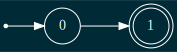

('green', 'blue', 'yellow') 0.033130369924083324
('green', 'yellow') 0.9959866683015901
('blue', 'green', 'yellow') 0.7325709603216836
('blue', 'yellow') 0.0329579415428108
{'conjecture': +: set()
--------------
-: {('yellow', 'green')},
 'data': +: {('blue',), ('blue', 'green'), ('blue', 'yellow')}
--------------
-: {('yellow',), ('yellow', 'blue'), ()},
 'energy': 36.293621128504675,
 'grad': array([ 1.74672598,  0.        ,  0.70906111, -0.02386395,  0.19516324,
       -0.02921705,  0.0707036 , -0.0305135 ,  0.04056103, -0.03082749,
        0.03326087, -0.03090353,  0.03149287, -0.03092195,  0.03106468,
       -0.03092641,  0.03096098, -0.03092749,  0.03093586, -0.03092775,
        0.03092978, -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.61181126,
       -0.0337603 , -0.04504258, -0.03129771,  0.02804562, -0.03119608,
        0.0278015 , -0.03109   ,  0.01979411, -0.030737  ,  0.02251449,
       -0.03048005,  0.035

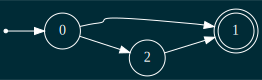

('green', 'blue', 'yellow') 0.03313395439089224
('green', 'yellow') 0.9959829758894552
('blue', 'green', 'yellow') 0.7325719517588809
('blue', 'yellow') 0.03296152664886186
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue',), ('blue', 'yellow'), ('blue', 'green')}
--------------
-: {('yellow',), ('yellow', 'blue'), (), ('yellow', 'green')},
 'energy': 35.20422294246551,
 'grad': array([ 1.7472593 ,  0.        ,  0.70904861, -0.02386408,  0.19516021,
       -0.02921708,  0.07070286, -0.03051351,  0.04056085, -0.03082749,
        0.03326083, -0.03090353,  0.03149286, -0.03092195,  0.03106468,
       -0.03092641,  0.03096098, -0.03092749,  0.03093586, -0.03092775,
        0.03092978, -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.61189088,
       -0.03377396, -0.04518934, -0.03130635,  0.02655887, -0.03115799,
        0.02962183, -0.03110999,  0.01356638, -0.03056175,  0.01503683,
       

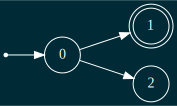

('green', 'blue', 'yellow') 0.03314460900655247
('green', 'yellow') 0.9959720004126966
('blue', 'green', 'yellow') 0.7325748987473327
('blue', 'yellow') 0.03297218316463155
{'conjecture': +: set()
--------------
-: {('blue', 'green')},
 'data': +: {('blue',), ('blue', 'green')}
--------------
-: {('yellow',), ('yellow', 'blue'), ('yellow', 'green'), (), ('blue', 'yellow')},
 'energy': 33.43634519630995,
 'grad': array([ 1.64197609,  0.        ,  0.76662608, -0.02556056,  0.16727537,
       -0.02998915,  0.05640933, -0.03081478,  0.03699213, -0.03100782,
        0.03205256, -0.03104047,  0.02933998, -0.03098733,  0.02782735,
       -0.03088858,  0.02971752, -0.03085198,  0.03272526, -0.03091052,
        0.03143636, -0.03092695,  0.03128733, -0.03093822,  0.03177299,
       -0.0309643 ,  0.03362274, -0.03104738, -0.96246874, -0.47291397,
       -0.0349297 , -0.06440699, -0.03182543,  0.01026214, -0.03115157,
        0.02948557, -0.03109951,  0.013698  , -0.03055572,  0.01522733,
       -

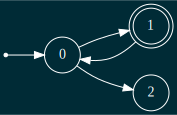

('green', 'blue', 'yellow') 0.033142469390276326
('green', 'yellow') 0.9959077064606325
('blue', 'green', 'yellow') 0.7325276081253033
('blue', 'yellow') 0.03297005467912897
{'conjecture': +: set()
--------------
-: {('blue',)},
 'data': +: {('blue',)}
--------------
-: {(),
 ('blue', 'green'),
 ('blue', 'yellow'),
 ('yellow',),
 ('yellow', 'blue'),
 ('yellow', 'green')},
 'energy': 32.86071414072368,
 'grad': array([ 1.59814535,  0.        ,  0.75969841, -0.02530126,  0.17462343,
       -0.02996758,  0.05640144, -0.03079364,  0.03745753, -0.03100189,
        0.03213741, -0.03103737,  0.03032837, -0.03101522,  0.03076045,
       -0.03100725,  0.03203954, -0.03103951,  0.02532406, -0.0308609 ,
        0.02764422, -0.03076038,  0.03035414, -0.03074769,  0.03129743,
       -0.03076487,  0.02678366, -0.03064045, -0.9498541 , -0.44373274,
       -0.03451471, -0.05750546, -0.03163907,  0.01566112, -0.03113976,
        0.02818431, -0.03104741,  0.02186671, -0.03076051,  0.02489459,
       -0.

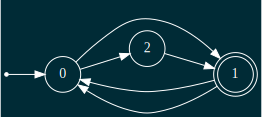

('green', 'blue', 'yellow') 0.03313866529490537
('green', 'yellow') 0.9957933960919196
('blue', 'green', 'yellow') 0.732443528546007
('blue', 'yellow') 0.03296627037353278
{'conjecture': +: set()
--------------
-: {('blue', 'green')},
 'data': +: {('yellow',), ('blue', 'green')}
--------------
-: {('blue',), (), ('blue', 'yellow')},
 'energy': 32.1655169702827,
 'grad': array([ 1.84964805,  0.        ,  0.86263934, -0.02876378,  0.08699321,
       -0.03058345,  0.04248705, -0.03095543,  0.03127849, -0.03096553,
        0.0314738 , -0.03098141,  0.0313632 , -0.03099334,  0.02279481,
       -0.03073714,  0.01410559, -0.0302174 ,  0.04744537, -0.03075578,
        0.03492817, -0.03088616,  0.03189667, -0.03091774,  0.03116247,
       -0.03092539,  0.03098466, -0.03092724, -0.95874454, -0.55340177,
       -0.0387014 , -0.0784584 , -0.03504016, -0.05859415, -0.03211408,
        0.00387667, -0.03123166,  0.00856578, -0.03052336,  0.01198767,
       -0.02994412,  0.05379932, -0.03068959, -0.95

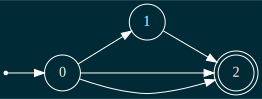

('green', 'blue', 'yellow') 0.03336102246112634
('green', 'yellow') 0.9957943635197097
('blue', 'green', 'yellow') 0.7325050607395709
('blue', 'yellow') 0.03295868884534667
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow',)}
--------------
-: {('blue',), ('blue', 'green'), (), ('blue', 'yellow')},
 'energy': 30.696619626218403,
 'grad': array([ 1.8729154 ,  0.        ,  0.70610355, -0.02389475,  0.19444695,
       -0.02922451,  0.07053012, -0.03051531,  0.04051901, -0.03082793,
        0.0332507 , -0.03090364,  0.0314904 , -0.03092197,  0.03106408,
       -0.03092642,  0.03096083, -0.03092749,  0.03093583, -0.03092775,
        0.03092977, -0.03092781,  0.0309283 , -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.40453411,
       -0.0440579 , -0.03298526, -0.0416503 , -0.192187  , -0.03434288,
       -0.05626675, -0.03151133,  0.00511269, -0.03068637,  0.01022192,
       -0.03004686,  0.0514105 , -0.03

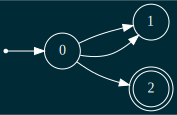

('green', 'blue', 'yellow') 0.033327723812986855
('green', 'yellow') 0.9948004309695679
('blue', 'green', 'yellow') 0.7317739252263717
('blue', 'yellow') 0.03292579177858923
{'conjecture': +: set()
--------------
-: {('yellow',)},
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {('blue',), ('blue', 'yellow'), (), ('blue', 'green')},
 'energy': 21.27317761237219,
 'grad': array([ 0.9736484 ,  0.        ,  0.86545359, -0.02799625,  0.10476305,
       -0.03039522,  0.04586513, -0.03087865,  0.03158205, -0.03090063,
        0.03191182, -0.03093223,  0.03563173, -0.03107909,  0.03015704,
       -0.03105028,  0.02272588, -0.03079014,  0.00769943, -0.03006855,
        0.00775124, -0.02937114,  0.00916656, -0.02873975,  0.01157861,
       -0.02820346,  0.01459453, -0.02777818, -0.8611236 ,  0.00566138,
       -0.0296526 ,  0.00271727, -0.02881087,  0.0710665 , -0.03013136,
        0.05477764, -0.03090156,  0.01135779, -0.03029082,  0.01604135,
       -0.02984552,  0.05

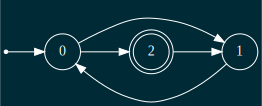

('green', 'blue', 'yellow') 0.0024960909673549534
('green', 'yellow') 0.9996105765469064
('blue', 'green', 'yellow') 0.9799111188568287
('blue', 'yellow') 0.0024659881338647293
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('yellow',), ('blue', 'green'), ('blue',), (), ('blue', 'yellow')},
 'energy': 30.686802022499005,
 'grad': array([ 1.85677807e+00,  0.00000000e+00,  8.81144755e-01, -2.93490334e-02,
        7.18787375e-02, -3.06780867e-02,  3.88494953e-02, -3.09334432e-02,
        3.02804150e-02, -3.09130361e-02,  3.16251913e-02, -3.09352909e-02,
        3.57386034e-02, -3.10853944e-02,  3.11898779e-02, -3.10886595e-02,
        2.77522516e-02, -3.09843968e-02,  1.07758137e-02, -3.03528786e-02,
        9.14361732e-03, -2.96900891e-02,  9.16733993e-03, -2.90487532e-02,
        1.09313149e-02, -2.84825833e-02,  1.37140011e-02, -2.80210651e-02,
       -8.68653018e-01, -6.40920059e-01, -3.61823030e-02

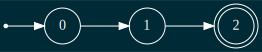

('green', 'blue', 'yellow') 0.0025713896810520883
('green', 'yellow') 0.9996106059433678
('blue', 'green', 'yellow') 0.9799126353089411
('blue', 'yellow') 0.002465801983481968
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: set()
--------------
-: {(),
 ('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'yellow'),
 ('yellow',)},
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.0309

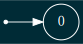

('green', 'blue', 'yellow') 0.0025713896810520883
('green', 'yellow') 0.9996106059433678
('blue', 'green', 'yellow') 0.9799126353089411
('blue', 'yellow') 0.002465801983481968
{'conjecture': +: {('blue', 'yellow')}
--------------
-: set(),
 'data': +: {('blue',)}
--------------
-: {(),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'yellow'),
 ('yellow',)},
 'energy': 32.38094023784961,
 'grad': array([ 1.59725885,  0.        ,  0.75915161, -0.02528331,  0.17420421,
       -0.02993709,  0.0573704 , -0.03079438,  0.03719098, -0.03099427,
        0.03205017, -0.03102727,  0.03096358, -0.03102528,  0.0307359 ,
       -0.03101624,  0.03178938, -0.0310404 ,  0.02491964, -0.03084912,
        0.02668649, -0.03071904,  0.02792392, -0.03063169,  0.03360013,
       -0.03072446,  0.03386924, -0.03082273, -0.9555047 , -0.44114987,
       -0.03456858, -0.05830376, -0.03166632,  0.01480795, -0.0311395 ,
        0.02814353, -0.03104587,  0.02137781, -0.03074375,  0.02460239,
       -0.03

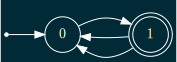

('green', 'blue', 'yellow') 0.0025713896810520883
('green', 'yellow') 0.9996106059433678
('blue', 'green', 'yellow') 0.9799126353089411
('blue', 'yellow') 0.002465801983481968
{'conjecture': +: {('blue', 'red', 'green', 'red')}
--------------
-: set(),
 'data': +: set()
--------------
-: {(),
 ('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'yellow'),
 ('yellow',)},
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.03

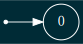

('green', 'blue', 'yellow') 0.0025713896810520883
('green', 'yellow') 0.9996106059433678
('blue', 'green', 'yellow') 0.9799126353089411
('blue', 'yellow') 0.002465801983481968
{'conjecture': +: {('yellow', 'blue')}
--------------
-: set(),
 'data': +: {('blue', 'red', 'green', 'red')}
--------------
-: {(),
 ('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'yellow'),
 ('yellow',)},
 'energy': 35.645947846449,
 'grad': array([ 1.89863843,  0.        ,  0.883332  , -0.02945826,  0.06918469,
       -0.03069971,  0.04018686, -0.03099619,  0.02811949, -0.03090629,
        0.03035685, -0.03088912,  0.0359742 , -0.03104803,  0.03201857,
       -0.03107836,  0.03185665, -0.03110268,  0.01687401, -0.03065803,
        0.0311928 , -0.03067475,  0.03681215, -0.03086654,  0.03235294,
       -0.03091299,  0.03127298, -0.03092424, -0.95865143, -0.69593437,
       -0.03573036, -0.07878071, -0.03215189,  0.00243766, -0.03122332,
        0.02576446, -0.03105273,  0.0185183 , -0.030

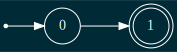

('green', 'blue', 'yellow') 0.002571388318632273
('green', 'yellow') 0.9996100763117423
('blue', 'green', 'yellow') 0.9799121161140475
('blue', 'yellow') 0.002465800677006521
{'conjecture': +: {()}
--------------
-: set(),
 'data': +: set()
--------------
-: {(),
 ('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'yellow'),
 ('yellow',)},
 'energy': 30.498475944637594,
 'grad': array([ 1.5       ,  0.        ,  0.71484375, -0.02380371,  0.19656372,
       -0.02920246,  0.07104278, -0.03050997,  0.04064317, -0.03082663,
        0.03328077, -0.03090333,  0.03149769, -0.0309219 ,  0.03106585,
       -0.0309264 ,  0.03096126, -0.03092749,  0.03093593, -0.03092775,
        0.0309298 , -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.33984375,
       -0.03479004, -0.05886841, -0.03186321,  0.00918031, -0.03115437,
        0.02566086, -0.0309827 ,  0.02965224, -0.03094112,  0.0306189 ,
       -0.03093105,  0

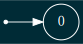

('green', 'blue', 'yellow') 0.002571388318632273
('green', 'yellow') 0.9996100763117423
('blue', 'green', 'yellow') 0.9799121161140475
('blue', 'yellow') 0.002465800677006521
{'conjecture': +: {('yellow',)}
--------------
-: set(),
 'data': +: {()}
--------------
-: {('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'yellow'),
 ('yellow',)},
 'energy': 37.850701482032555,
 'grad': array([ 1.78771533,  0.        ,  0.70810042, -0.02387395,  0.19493057,
       -0.02921947,  0.07064725, -0.03051409,  0.04054738, -0.03082763,
        0.03325757, -0.03090357,  0.03149207, -0.03092196,  0.03106449,
       -0.03092641,  0.03096093, -0.03092749,  0.03093585, -0.03092775,
        0.03092978, -0.03092781,  0.03092831, -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.29962812,
       -0.04475691, -0.03140334, -0.0423769 , -0.22747465, -0.03394404,
       -0.04042847, -0.0316199 ,  0.01648088, -0.03114681,  0.03443311,
       -0.0312495 ,

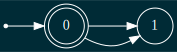

('green', 'blue', 'yellow') 0.0025713881683878505
('green', 'yellow') 0.9996100179052242
('blue', 'green', 'yellow') 0.9799120588584678
('blue', 'yellow') 0.0024658005329315108
{'conjecture': +: set()
--------------
-: {('blue', 'red', 'green', 'yellow')},
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {('blue',), ('blue', 'yellow'), (), ('blue', 'green')},
 'energy': 28.74437231713959,
 'grad': array([ 1.82334542,  0.        ,  0.73284839, -0.02468212,  0.17052315,
       -0.02923966,  0.07389454, -0.03063512,  0.03703695, -0.03083518,
        0.03345887, -0.03091717,  0.03634177, -0.03108669,  0.03190386,
       -0.03111222,  0.03231441, -0.03114979,  0.02298197, -0.03089455,
        0.02265475, -0.03063705,  0.01714813, -0.03021552,  0.01263422,
       -0.02966611,  0.01171048, -0.029105  , -0.90225486, -0.4246179 ,
       -0.04192962, -0.07683849, -0.03821812, -0.12373036, -0.03315723,
       -0.02425614, -0.03136306,  0.00634255, -0.03058117,  0.01105134,

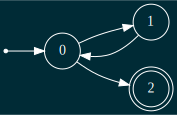

('green', 'blue', 'yellow') 0.0025700348555193083
('green', 'yellow') 0.9996102231514774
('blue', 'green', 'yellow') 0.9799226310737338
('blue', 'yellow') 0.0024645027904772604
{'conjecture': +: set()
--------------
-: {('blue', 'green')},
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {(),
 ('blue',),
 ('blue', 'green'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'yellow')},
 'energy': 33.757929615066594,
 'grad': array([ 1.73993547,  0.        ,  0.82961791, -0.02762472,  0.11993911,
       -0.03050954,  0.04470954, -0.03095329,  0.03180369, -0.03097987,
        0.03097463, -0.0309797 ,  0.03249363, -0.03102701,  0.02743787,
       -0.03091485,  0.02021035, -0.03058034,  0.03904005, -0.0308447 ,
        0.0400623 , -0.03113275,  0.02418801, -0.03091573,  0.02166113,
       -0.03062652,  0.02297919, -0.03038754, -0.94201383, -0.57323709,
       -0.03476017, -0.06108802, -0.03176491,  0.01170943, -0.03113818,
        0.02858079, -0.03105826,  0.01942992, -

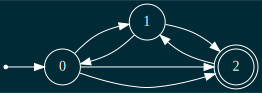

('green', 'blue', 'yellow') 0.0025700258645235024
('green', 'yellow') 0.9996067261205696
('blue', 'green', 'yellow') 0.979922701312291
('blue', 'yellow') 0.0024644941686742497
{'conjecture': +: {('blue', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {(),
 ('blue',),
 ('blue', 'green'),
 ('blue', 'red', 'green', 'yellow'),
 ('blue', 'yellow')},
 'energy': 30.763264691153605,
 'grad': array([ 1.83349889,  0.        ,  0.81547405, -0.02727409,  0.11453253,
       -0.03000092,  0.05824443, -0.03088353,  0.03147847, -0.03090212,
        0.03201863, -0.03093701,  0.03408691, -0.03103544,  0.03117619,
       -0.03103984,  0.03422072, -0.03113924,  0.02605281, -0.03098029,
        0.02571792, -0.03081584,  0.02234431, -0.03055111,  0.01639798,
       -0.03010882,  0.01272553, -0.0295656 , -0.91653346, -0.49357579,
       -0.04008207, -0.08322788, -0.03622863, -0.08296534, -0.03250382,
       -0.00662398, -0.03128108,  0.00715381, -

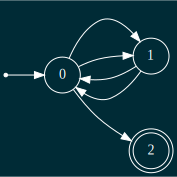

('green', 'blue', 'yellow') 0.0025698462496179866
('green', 'yellow') 0.9995368652409015
('blue', 'green', 'yellow') 0.9799241044818686
('blue', 'yellow') 0.0024643219292064056
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'red')},
 'data': +: {('yellow',), ('blue', 'green', 'yellow'), ('blue', 'yellow')}
--------------
-: {('blue',), (), ('blue', 'red', 'green', 'yellow'), ('blue', 'green')},
 'energy': 32.67513024287634,
 'grad': array([ 1.72132249,  0.        ,  0.81889974, -0.0272716 ,  0.12725855,
       -0.03039619,  0.04751011, -0.030931  ,  0.03242427, -0.03097766,
        0.03076729, -0.03097109,  0.03360047, -0.03105326,  0.03003115,
       -0.03102132,  0.03016479, -0.03099455,  0.02411105, -0.03077944,
        0.03085751, -0.03078188,  0.0318294 , -0.03081462,  0.02783496,
       -0.0307215 ,  0.02526126, -0.03055087, -0.94707692, -0.55233273,
       -0.03484995, -0.06315801, -0.0317872 ,  0.01123175, -0.03114484,
        0.02821651, -0.03105333,  0.0181474 ,

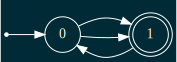

('green', 'blue', 'yellow') 0.0025801494044937314
('green', 'yellow') 0.9995368700249448
('blue', 'green', 'yellow') 0.9799243118598588
('blue', 'yellow') 0.0024746261741167884
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: {('yellow',), ('blue', 'green', 'yellow'), ('blue', 'yellow')}
--------------
-: {(),
 ('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow')},
 'energy': 26.46895754936582,
 'grad': array([ 1.29021829,  0.        ,  0.49798836, -0.01682211,  0.21362084,
       -0.02297208,  0.26848402, -0.03064432,  0.02855749, -0.03057911,
        0.03511557, -0.03072087,  0.04561133, -0.0311862 ,  0.03187169,
       -0.03120762,  0.03106951, -0.03120331,  0.01389823, -0.03066252,
        0.01189699, -0.0300761 ,  0.00990635, -0.0294458 ,  0.010416  ,
       -0.02885111,  0.01266929, -0.02834543, -0.87870841, -0.13096478,
       -0.03496669, -0.04799356, -0.03237419, -0.00243027, -0.03128655,
        0.02622097, -0.0311282

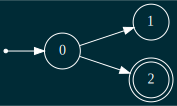

('green', 'blue', 'yellow') 0.0076623727683004
('green', 'yellow') 0.9995392298436093
('blue', 'green', 'yellow') 0.980026604922554
('blue', 'yellow') 0.007557387217844832
{'conjecture': +: set()
--------------
-: {('blue',)},
 'data': +: {('yellow',), ('blue',), ('blue', 'green', 'yellow'), ('blue', 'yellow')}
--------------
-: {(),
 ('blue', 'green'),
 ('blue', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow')},
 'energy': 29.221737239522476,
 'grad': array([ 1.53443438,  0.        ,  0.71407178, -0.02381321,  0.18563075,
       -0.02887001,  0.08778721, -0.03071117,  0.03406981, -0.03081613,
        0.03304243, -0.0308857 ,  0.03606852, -0.03104767,  0.03222217,
       -0.03108437,  0.03541541, -0.03121972,  0.01558253, -0.03073105,
        0.02100188, -0.03042702,  0.02119977, -0.03013866,  0.01754007,
       -0.02974496,  0.01308564, -0.02922436, -0.90595501, -0.35467455,
       -0.03536902, -0.07112348, -0.03204113,  0.00505778, -0.0311979 ,
        0.02672517, -0.03105813,  0

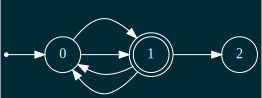

('green', 'blue', 'yellow') 0.007984611041146674
('green', 'yellow') 0.9995393794678655
('blue', 'green', 'yellow') 0.9800330908121908
('blue', 'yellow') 0.00787965958227599
{'conjecture': +: {('blue', 'green')}
--------------
-: set(),
 'data': +: {('yellow',), ('blue', 'green', 'yellow'), ('blue', 'yellow')}
--------------
-: {(),
 ('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'red'),
 ('blue', 'red', 'green', 'yellow')},
 'energy': 26.46895754936582,
 'grad': array([ 1.29021829,  0.        ,  0.49798836, -0.01682211,  0.21362084,
       -0.02297208,  0.26848402, -0.03064432,  0.02855749, -0.03057911,
        0.03511557, -0.03072087,  0.04561133, -0.0311862 ,  0.03187169,
       -0.03120762,  0.03106951, -0.03120331,  0.01389823, -0.03066252,
        0.01189699, -0.0300761 ,  0.00990635, -0.0294458 ,  0.010416  ,
       -0.02885111,  0.01266929, -0.02834543, -0.87870841, -0.13096478,
       -0.03496669, -0.04799356, -0.03237419, -0.00243027, -0.03128655,
        0.02622097, -0.03

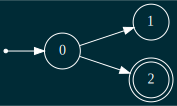

('green', 'blue', 'yellow') 0.007984611041146674
('green', 'yellow') 0.9995393794678655
('blue', 'green', 'yellow') 0.9800330908121908
('blue', 'yellow') 0.00787965958227599
{'conjecture': +: {('yellow', 'red')}
--------------
-: set(),
 'data': +: {('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'yellow'),
 ('yellow',)}
--------------
-: {('blue',), (), ('blue', 'green', 'red'), ('blue', 'red', 'green', 'yellow')},
 'energy': 26.732687564290625,
 'grad': array([ 1.26267899,  0.        ,  0.54847965, -0.01837307,  0.21717124,
       -0.02458552,  0.21457289, -0.03052262,  0.03146959, -0.03055221,
        0.03601583, -0.03072295,  0.04441744, -0.03115091,  0.02780451,
       -0.03104633,  0.01544049, -0.03055865,  0.02461918, -0.03037304,
        0.03673988, -0.030572  ,  0.03920092, -0.03084166,  0.03293147,
       -0.03090696,  0.03141309, -0.03092278, -0.95860619, -0.12505593,
       -0.03431764, -0.03867645, -0.03203657,  0.00473605, -0.03118343,
        0.02769132, -0.03

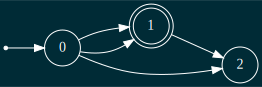

('green', 'blue', 'yellow') 0.011851133861598449
('green', 'yellow') 0.999541174802715
('blue', 'green', 'yellow') 0.9801109147158195
('blue', 'yellow') 0.011746591466150855
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: {('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'yellow'),
 ('yellow',),
 ('yellow', 'red')}
--------------
-: {('blue',), (), ('blue', 'green', 'red'), ('blue', 'red', 'green', 'yellow')},
 'energy': 31.791882985304813,
 'grad': array([ 1.69363514,  0.        ,  0.80642082, -0.02685459,  0.13520346,
       -0.03024049,  0.05144192, -0.03090304,  0.03272462, -0.03095996,
        0.03093825, -0.03095928,  0.0324861 , -0.031007  ,  0.02540759,
       -0.03083202,  0.02066409, -0.03051427,  0.02533183, -0.03035232,
        0.03714586, -0.03056461,  0.0393727 , -0.03083987,  0.03297308,
       -0.03090653,  0.03142317, -0.03092268, -0.95860294, -0.51874993,
       -0.03506122, -0.06692037, -0.0318743 ,  0.00905485, -0.03116119,
        0.027

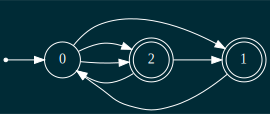

('green', 'blue', 'yellow') 0.011875592548692302
('green', 'yellow') 0.9995411861595687
('blue', 'green', 'yellow') 0.9801114070109891
('blue', 'yellow') 0.011771052740880868
{'conjecture': +: {('blue', 'green', 'red')}
--------------
-: set(),
 'data': +: {('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'yellow'),
 ('yellow',),
 ('yellow', 'red')}
--------------
-: {(), ('blue', 'green', 'red'), ('blue', 'red', 'green', 'yellow')},
 'energy': 32.81159871672247,
 'grad': array([ 1.47979021,  0.        ,  0.69252041, -0.02308637,  0.2011861 ,
       -0.02865199,  0.09197807, -0.03063093,  0.03613515, -0.03080293,
        0.03298979, -0.03087127,  0.03575071, -0.03102376,  0.03266087,
       -0.03107492,  0.03194964, -0.03110225,  0.01688029, -0.03065781,
        0.0311971 , -0.03067467,  0.03681399, -0.03086652,  0.03235339,
       -0.03091299,  0.03127309, -0.03092424, -0.9586514 , -0.32654647,
       -0.03459376, -0.0626817 , -0.0315539 ,  0.01860021, -0.0311491

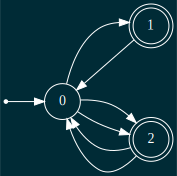

('green', 'blue', 'yellow') 0.011884414437886846
('green', 'yellow') 0.9995322623423617
('blue', 'green', 'yellow') 0.980111584574626
('blue', 'yellow') 0.011779875563397768
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {('blue',), ('blue', 'yellow'), (), ('blue', 'green')},
 'energy': 21.27317761237219,
 'grad': array([ 0.9736484 ,  0.        ,  0.86545359, -0.02799625,  0.10476305,
       -0.03039522,  0.04586513, -0.03087865,  0.03158205, -0.03090063,
        0.03191182, -0.03093223,  0.03563173, -0.03107909,  0.03015704,
       -0.03105028,  0.02272588, -0.03079014,  0.00769943, -0.03006855,
        0.00775124, -0.02937114,  0.00916656, -0.02873975,  0.01157861,
       -0.02820346,  0.01459453, -0.02777818, -0.8611236 ,  0.00566138,
       -0.0296526 ,  0.00271727, -0.02881087,  0.0710665 , -0.03013136,
        0.05477764, -0.03090156,  0.01135779, -0.03029082,  0.01604135,
       -0

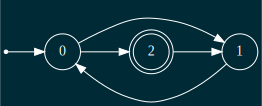

('green', 'blue', 'yellow') 0.011884414437886846
('green', 'yellow') 0.9995322623423617
('blue', 'green', 'yellow') 0.980111584574626
('blue', 'yellow') 0.011779875563397768
{'conjecture': +: set()
--------------
-: {('yellow',)},
 'data': +: {('yellow',)}
--------------
-: {(),
 ('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'yellow')},
 'energy': 30.432635498950795,
 'grad': array([ 1.87422796,  0.        ,  0.70607278, -0.02389508,  0.1944395 ,
       -0.02922459,  0.07052832, -0.03051533,  0.04051858, -0.03082793,
        0.03325059, -0.03090364,  0.03149038, -0.03092198,  0.03106408,
       -0.03092642,  0.03096083, -0.03092749,  0.03093583, -0.03092775,
        0.03092977, -0.03092781,  0.0309283 , -0.03092783,  0.03092795,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288, -0.40630239,
       -0.04404237, -0.03296317, -0.04163595, -0.19189495, -0.03433811,
       -0.05613812, -0.03151073,  0.00511789, -0.03068595,  0.0102247 ,
       -0.03004654, 

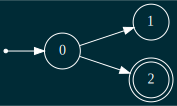

('green', 'blue', 'yellow') 0.011884414437886846
('green', 'yellow') 0.9995322623423617
('blue', 'green', 'yellow') 0.980111584574626
('blue', 'yellow') 0.011779875563397768
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {('blue',), ('blue', 'yellow'), (), ('blue', 'green')},
 'energy': 35.57531553220247,
 'grad': array([ 1.86588711,  0.        ,  0.88427278, -0.02945568,  0.06924126,
       -0.03069898,  0.04019062, -0.03099559,  0.02812286, -0.03090582,
        0.0303685 , -0.03088903,  0.03589712, -0.03104553,  0.03181583,
       -0.0310696 ,  0.03120691, -0.03107389,  0.0274604 , -0.03096097,
        0.02989404, -0.03092763,  0.03004357, -0.0309    ,  0.02874447,
       -0.03083264,  0.02511783, -0.03065406, -0.95027573, -0.65158578,
       -0.03612476, -0.08381984, -0.03237649, -0.00265919, -0.03128163,
        0.02613901, -0.03112092,  0.01103481, -0.03049323,  0.0138418 ,
       -0.02997287,  0.0531

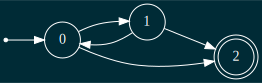

('green', 'blue', 'yellow') 0.011884407747356374
('green', 'yellow') 0.9995322626056826
('blue', 'green', 'yellow') 0.9801115957711433
('blue', 'yellow') 0.01177986893171921
{'conjecture': +: {('blue', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {('blue',), ('blue', 'yellow'), (), ('blue', 'green')},
 'energy': 35.57531553220247,
 'grad': array([ 1.86588711,  0.        ,  0.88427278, -0.02945568,  0.06924126,
       -0.03069898,  0.04019062, -0.03099559,  0.02812286, -0.03090582,
        0.0303685 , -0.03088903,  0.03589712, -0.03104553,  0.03181583,
       -0.0310696 ,  0.03120691, -0.03107389,  0.0274604 , -0.03096097,
        0.02989404, -0.03092763,  0.03004357, -0.0309    ,  0.02874447,
       -0.03083264,  0.02511783, -0.03065406, -0.95027573, -0.65158578,
       -0.03612476, -0.08381984, -0.03237649, -0.00265919, -0.03128163,
        0.02613901, -0.03112092,  0.01103481, -0.03049323,  0.0138418 ,
       -0.02997287

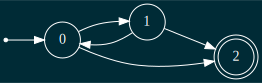

('green', 'blue', 'yellow') 0.011884407747356374
('green', 'yellow') 0.9995322626056826
('blue', 'green', 'yellow') 0.9801115957711433
('blue', 'yellow') 0.01177986893171921
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {('blue',), ('blue', 'yellow'), (), ('blue', 'green')},
 'energy': 22.263745068932433,
 'grad': array([ 1.31158056,  0.        ,  0.8650642 , -0.0283141 ,  0.09775079,
       -0.03048399,  0.04370932, -0.03089728,  0.03116421, -0.03090563,
        0.03179441, -0.0309334 ,  0.0356003 , -0.03107924,  0.03015319,
       -0.0310503 ,  0.0227254 , -0.03079015,  0.00769938, -0.03006856,
        0.00775121, -0.02937114,  0.00916654, -0.02873975,  0.0115786 ,
       -0.02820346,  0.01459451, -0.02777819, -0.86112374, -0.0421904 ,
       -0.0383876 , -0.00881336, -0.03691257, -0.0966684 , -0.03273817,
       -0.01225872, -0.03133201,  0.00950833, -0.03065002,  0.01660463,
       -

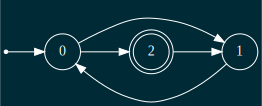

('green', 'blue', 'yellow') 0.008868207305796669
('green', 'yellow') 0.9996509719065805
('blue', 'green', 'yellow') 0.985159168598686
('blue', 'yellow') 0.008790199894044991
{'conjecture': +: {('blue', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow',)}
--------------
-: {(),
 ('blue',),
 ('blue', 'green'),
 ('blue', 'green', 'yellow'),
 ('blue', 'yellow')},
 'energy': 34.03555109447859,
 'grad': array([ 1.74632033,  0.        ,  0.64611518, -0.02189649,  0.2409066 ,
       -0.02874056,  0.08178207, -0.0303981 ,  0.04324409, -0.03079954,
        0.03391068, -0.03089676,  0.03165024, -0.03092031,  0.03110279,
       -0.03092601,  0.03097021, -0.03092739,  0.0309381 , -0.03092773,
        0.03093032, -0.03092781,  0.03092844, -0.03092783,  0.03092798,
       -0.03092783,  0.03092787, -0.03092783, -0.95876288, -0.62626432,
       -0.03329636, -0.02996881, -0.03131932,  0.02353811, -0.03107616,
        0.03178972, -0.03109846,  0.01083468, -0.03046522,  0.01356367,
       -0.0299

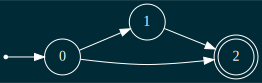

('green', 'blue', 'yellow') 0.008868189932299715
('green', 'yellow') 0.9996509725903532
('blue', 'green', 'yellow') 0.9851572385964631
('blue', 'yellow') 0.00879018267337053
{'conjecture': +: set()
--------------
-: {('yellow',)},
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {('blue',), ('blue', 'yellow'), (), ('blue', 'green')},
 'energy': 28.74437231713959,
 'grad': array([ 1.82334542,  0.        ,  0.73284839, -0.02468212,  0.17052315,
       -0.02923966,  0.07389454, -0.03063512,  0.03703695, -0.03083518,
        0.03345887, -0.03091717,  0.03634177, -0.03108669,  0.03190386,
       -0.03111222,  0.03231441, -0.03114979,  0.02298197, -0.03089455,
        0.02265475, -0.03063705,  0.01714813, -0.03021552,  0.01263422,
       -0.02966611,  0.01171048, -0.029105  , -0.90225486, -0.4246179 ,
       -0.04192962, -0.07683849, -0.03821812, -0.12373036, -0.03315723,
       -0.02425614, -0.03136306,  0.00634255, -0.03058117,  0.01105134,
       -0.02997086,  0.05

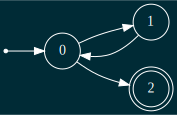

('green', 'blue', 'yellow') 0.008868189932299715
('green', 'yellow') 0.9996509725903532
('blue', 'green', 'yellow') 0.9851572385964631
('blue', 'yellow') 0.00879018267337053
{'conjecture': +: set()
--------------
-: {('blue', 'red', 'green', 'yellow')},
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {('blue',), ('blue', 'yellow'), (), ('blue', 'green')},
 'energy': 23.159651181410624,
 'grad': array([ 1.48367764,  0.        ,  0.85082063, -0.02803705,  0.10373842,
       -0.03040272,  0.04568006, -0.03088013,  0.03154809, -0.03090101,
        0.03190299, -0.03093232,  0.03562936, -0.0310791 ,  0.03015675,
       -0.03105028,  0.02272585, -0.03079014,  0.00769943, -0.03006856,
        0.00775123, -0.02937114,  0.00916656, -0.02873975,  0.01157861,
       -0.02820346,  0.01459453, -0.02777818, -0.86112361, -0.12254872,
       -0.04108637, -0.02364893, -0.0390634 , -0.1424772 , -0.03339025,
       -0.02854356, -0.03145482,  0.00962233, -0.03077256,  0.01786859,
 

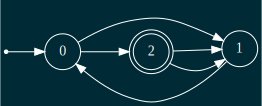

('green', 'blue', 'yellow') 0.00803563147846018
('green', 'yellow') 0.9996837397866742
('blue', 'green', 'yellow') 0.9865506984320299
('blue', 'yellow') 0.007964947653442326
{'conjecture': +: set()
--------------
-: {('red', 'green', 'yellow', 'green', 'red')},
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {('blue',), ('blue', 'yellow'), (), ('blue', 'green')},
 'energy': 23.64321960266888,
 'grad': array([ 1.25206437,  0.        ,  0.89628992, -0.02923178,  0.07451699,
       -0.03064694,  0.03960869, -0.030927  ,  0.03042691, -0.03091137,
        0.03166439, -0.0309349 ,  0.03574914, -0.03108535,  0.03119117,
       -0.03108865,  0.02775241, -0.0309844 ,  0.01077583, -0.03035288,
        0.00914362, -0.02969009,  0.00916734, -0.02904875,  0.01093132,
       -0.02848258,  0.013714  , -0.02802106, -0.868653  , -0.02407436,
       -0.03715197, -0.00487936, -0.03583849, -0.07323327, -0.03243   ,
       -0.00464015, -0.03127156,  0.00676473, -0.03050572,  0.0114

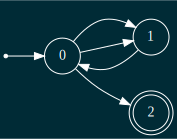

('green', 'blue', 'yellow') 0.0075959379625276805
('green', 'yellow') 0.9997010449064423
('blue', 'green', 'yellow') 0.9872866170352049
('blue', 'yellow') 0.007529121813575482
{'conjecture': +: {('blue', 'red')}
--------------
-: set(),
 'data': +: {('yellow',), ('blue', 'green', 'yellow')}
--------------
-: {('blue',), ('blue', 'yellow'), (), ('blue', 'green')},
 'energy': 34.25880754987996,
 'grad': array([ 1.746329  ,  0.        ,  0.64612134, -0.02189669,  0.24090193,
       -0.0287406 ,  0.08178094, -0.03039812,  0.04324382, -0.03079954,
        0.03391061, -0.03089676,  0.03165023, -0.03092031,  0.03110279,
       -0.03092601,  0.03097021, -0.03092739,  0.0309381 , -0.03092773,
        0.03093032, -0.03092781,  0.03092844, -0.03092783,  0.03092798,
       -0.03092783,  0.03092787, -0.03092783, -0.95876288, -0.6262625 ,
       -0.03329668, -0.02997794, -0.03131935,  0.02353847, -0.03107619,
        0.03178896, -0.03109847,  0.01083458, -0.03046522,  0.01356362,
       -0.02993705,

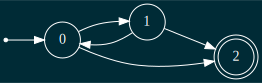

('green', 'blue', 'yellow') 0.007595927766767577
('green', 'yellow') 0.9997010453077191
('blue', 'green', 'yellow') 0.9872866340999312
('blue', 'yellow') 0.007529111707500343
energy 21.27317761237219


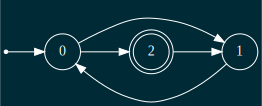

energy 22.263745068932433


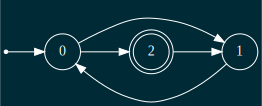

energy 23.159651181410624


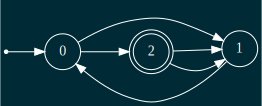

energy 23.64321960266888


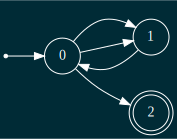

energy 24.38051341743705


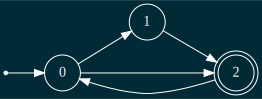

energy 25.129074982928234


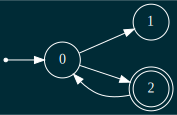

energy 25.767157772126655


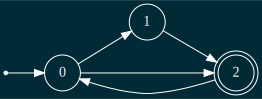

energy 26.46895754936582


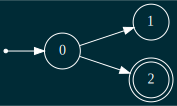

energy 26.732687564290625


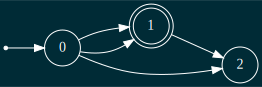

energy 27.97345974276202


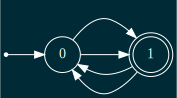

energy 28.41910017772558


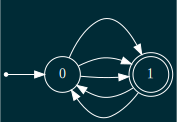

energy 28.74437231713959


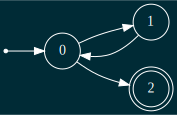

energy 28.74495565133852


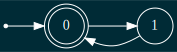

energy 29.221737239522476


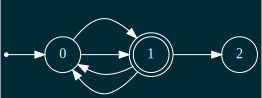

energy 29.89759972251682


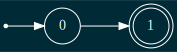

energy 30.33533598468941


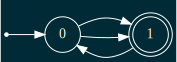

energy 30.432635498950795


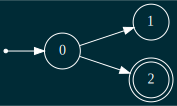

energy 30.498475944637594


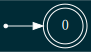

energy 30.498475944637594


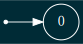

energy 30.686802022499005


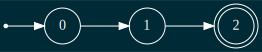

energy 30.696619626218403


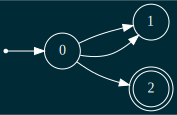

energy 30.763264691153605


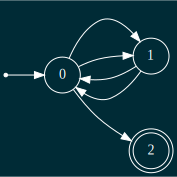

energy 30.91354852656712


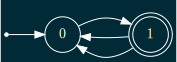

energy 30.92606742851059


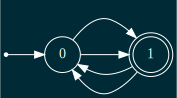

energy 31.0114975341684


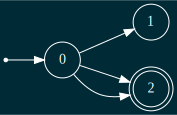

energy 31.03762665876833


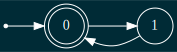

energy 31.300168553312403


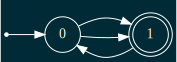

energy 31.513804662849402


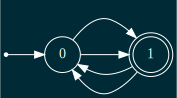

energy 31.767765651815672


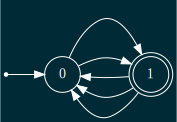

energy 31.791882985304813


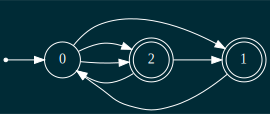

energy 31.846184686014535


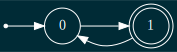

energy 32.04214143705801


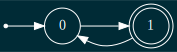

energy 32.09108694844526


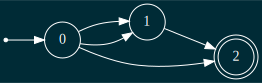

energy 32.09944286581337


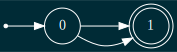

energy 32.10091469888473


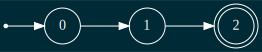

energy 32.10490815113448


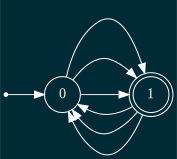

energy 32.132462950801354


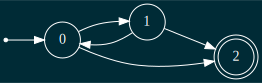

energy 32.1655169702827


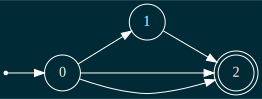

energy 32.32064475793423


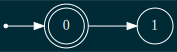

energy 32.38094023784961


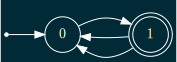

energy 32.49352234725109


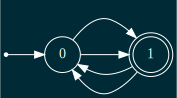

energy 32.5738385466441


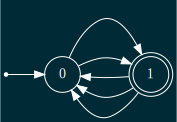

energy 32.61503849681035


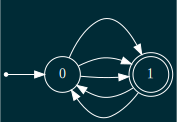

energy 32.67513024287634


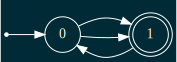

energy 32.81159871672247


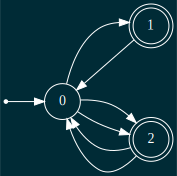

energy 32.86071414072368


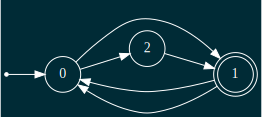

energy 32.90778132511766


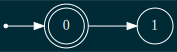

energy 32.93882536544495


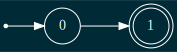

energy 33.01347600862804


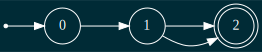

energy 33.04478705458818


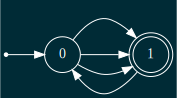

energy 33.43634519630995


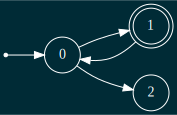

energy 33.757929615066594


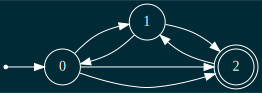

energy 33.93329558762623


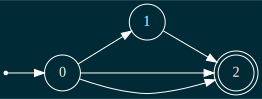

energy 34.03555109447859


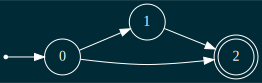

energy 34.25880754987996


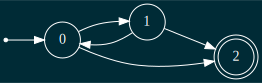

energy 34.4658501693308


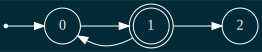

energy 35.17265744079533


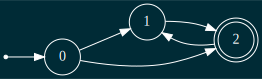

energy 35.20351260923749


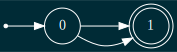

energy 35.20422294246551


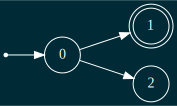

energy 35.57531553220247


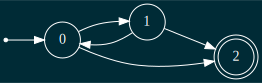

energy 35.645947846449


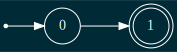

energy 36.293621128504675


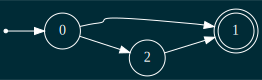

energy 36.581491599688185


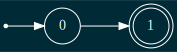

energy 36.78700048286283


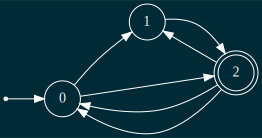

energy 37.850701482032555


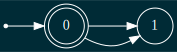

In [136]:
identifer = PartialDFAIdentifier(
    #partial = PARTIAL_DFA,
    #base_examples = BASE_EXAMPLES,
    base_examples = LabeledExamples(negative=[], positive=[]),
    partial = universal,
)

dfa_search = diss(
    demos=[to_demo(TRC4), to_demo(TRC5)],
    to_concept=identifer,
    to_chain=to_chain,
    competency=lambda *_: 0.8,
    lift_path=lambda x: lift_path(x),
    n_iters=n_iters,
    reset_period=10,
    surprise_weight=1,  # Rescale surprise to make comparable to size.
    size_weight=1,
    sgs_temp=float('inf'),
)

df_greed0 = analyze(dfa_search, n_iters)

In [137]:
df_greed0['treatment'] = r'$\beta = \infty$'
df_greed0['iteration'] = df_greed0.index

In [66]:
#df_greed0.to_csv('greed0.csv')
#df_greed4.to_csv('greed4.csv')

In [67]:
#df_greed0 = pd.read_csv('greed0.csv')
#df_greed4 = pd.read_csv('greed4.csv')

In [142]:
from diss.experiment import concept_class

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

{'energy': 30.498475944637594}


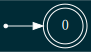

('green', 'blue', 'yellow') 1.0
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
{'energy': 29.89759972251682}


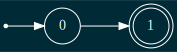

('green', 'blue', 'yellow') 1.0
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
{'energy': 29.969353622889084}


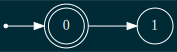

('green', 'blue', 'yellow') 1.0
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
{'energy': 28.661684628765705}


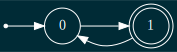

('green', 'blue', 'yellow') 1.0
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
{'energy': 35.20351260923749}


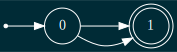

('green', 'blue', 'yellow') 1.0
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
{'energy': 27.479283452411302}


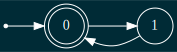

('green', 'blue', 'yellow') 1.0
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
{'energy': 31.105309473511706}


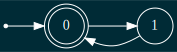

('green', 'blue', 'yellow') 1.0
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
{'energy': 32.09944286581337}


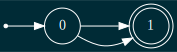

('green', 'blue', 'yellow') 1.0
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
{'energy': 26.09901480832629}


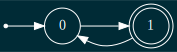

('green', 'blue', 'yellow') 1.0
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
{'energy': 26.387005073385215}


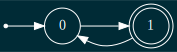

('green', 'blue', 'yellow') 1.0
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
{'energy': 27.376373271873515}


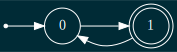

('green', 'blue', 'yellow') 1.0
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
{'energy': 35.77134474794835}


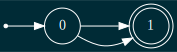

('green', 'blue', 'yellow') 1.0
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
{'energy': 30.140651201214954}


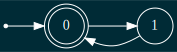

('green', 'blue', 'yellow') 1.0
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
{'energy': 30.184371840901353}


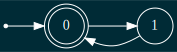

('green', 'blue', 'yellow') 0.9999999999999999
('green', 'yellow') 0.9999999999999999
('blue', 'green', 'yellow') 0.9999999999999999
('blue', 'yellow') 0.9999999999999999
{'energy': 28.74495565133852}


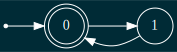

('green', 'blue', 'yellow') 0.971931756438569
('green', 'yellow') 1.0000000000000002
('blue', 'green', 'yellow') 1.0000000000000002
('blue', 'yellow') 0.971931756438569
{'energy': 30.15315918354624}


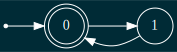

('green', 'blue', 'yellow') 0.9721231309994773
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.9721231309994773
{'energy': 30.16544461331035}


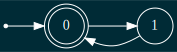

('green', 'blue', 'yellow') 0.9723096239116819
('green', 'yellow') 0.9999999999999999
('blue', 'green', 'yellow') 0.9999999999999999
('blue', 'yellow') 0.9723096239116819
{'energy': 32.67513024287634}


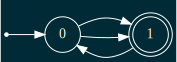

('green', 'blue', 'yellow') 0.9723246750187666
('green', 'yellow') 0.9999999999999998
('blue', 'green', 'yellow') 0.9999999999999998
('blue', 'yellow') 0.9723246750187666
{'energy': 27.40222673052705}


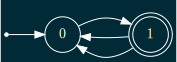

('green', 'blue', 'yellow') 0.97497669703118
('green', 'yellow') 0.9999999999999999
('blue', 'green', 'yellow') 0.9999999999999999
('blue', 'yellow') 0.97497669703118
{'energy': 28.16963117154631}


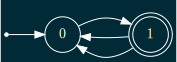

('green', 'blue', 'yellow') 0.9760424282279492
('green', 'yellow') 0.9999999999999998
('blue', 'green', 'yellow') 0.9999999999999998
('blue', 'yellow') 0.9760424282279492
{'energy': 28.6137800435233}


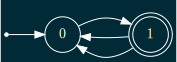

('green', 'blue', 'yellow') 0.9766794445079001
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.9766794445079001
{'energy': 30.352795461484742}


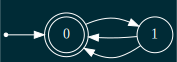

('green', 'blue', 'yellow') 0.9767878815622315
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.9767878815622315
{'energy': 30.323375636493438}


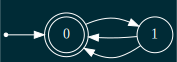

('green', 'blue', 'yellow') 0.9768985071861235
('green', 'yellow') 0.9999999999999998
('blue', 'green', 'yellow') 0.9999999999999998
('blue', 'yellow') 0.9768985071861235
{'energy': 26.49098622093907}


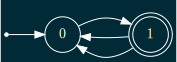

('green', 'blue', 'yellow') 0.9810651667320269
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.9810651667320269
{'energy': 29.736868944336432}


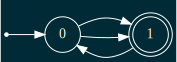

('green', 'blue', 'yellow') 0.9811972054854459
('green', 'yellow') 1.0000000000000002
('blue', 'green', 'yellow') 1.0000000000000002
('blue', 'yellow') 0.9811972054854459
{'energy': 27.7799861349916}


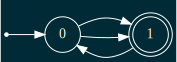

('green', 'blue', 'yellow') 0.9820815156321637
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.9820815156321637
{'energy': 29.883350159938402}


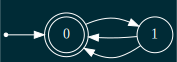

('green', 'blue', 'yellow') 0.9764766567241412
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.9764766567241412
{'energy': 31.284585538485434}


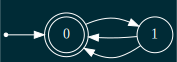

('green', 'blue', 'yellow') 0.9765096752269
('green', 'yellow') 1.0000000000000002
('blue', 'green', 'yellow') 1.0000000000000002
('blue', 'yellow') 0.9765096752269
{'energy': 27.425748450959794}


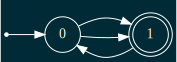

('green', 'blue', 'yellow') 0.9779753543862413
('green', 'yellow') 1.0000000000000002
('blue', 'green', 'yellow') 1.0000000000000002
('blue', 'yellow') 0.9779753543862413
{'energy': 36.1325354207877}


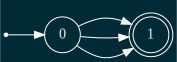

('green', 'blue', 'yellow') 0.9779755817623348
('green', 'yellow') 1.0000000000000002
('blue', 'green', 'yellow') 1.0000000000000002
('blue', 'yellow') 0.9779755817623348
{'energy': 30.77388108442886}


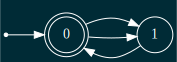

('green', 'blue', 'yellow') 0.9780237790826121
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.9780237790826121
{'energy': 30.432990240562976}


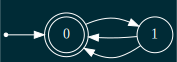

('green', 'blue', 'yellow') 0.9780911983583527
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.9780911983583527
{'energy': 26.500334607666648}


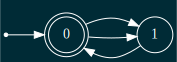

('green', 'blue', 'yellow') 0.9810574037133624
('green', 'yellow') 1.0000000000000002
('blue', 'green', 'yellow') 1.0000000000000002
('blue', 'yellow') 0.9810574037133624
{'energy': 35.566500434000716}


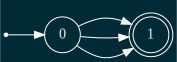

('green', 'blue', 'yellow') 0.9810576999436857
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.9810576999436857
{'energy': 29.10663465877887}


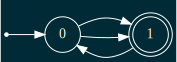

('green', 'blue', 'yellow') 0.9812451081625094
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.9812451081625094
{'energy': 30.405990513487655}


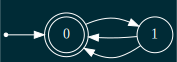

('green', 'blue', 'yellow') 0.9812955739703103
('green', 'yellow') 1.0000000000000002
('blue', 'green', 'yellow') 1.0000000000000002
('blue', 'yellow') 0.9812955739703103
{'energy': 27.442681543023234}


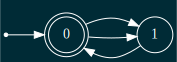

('green', 'blue', 'yellow') 0.9327024822146258
('green', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.9327024822146258
{'energy': 26.728425805455455}


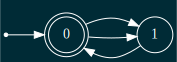

('green', 'blue', 'yellow') 0.8470247221530581
('green', 'yellow') 0.9081403108758402
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8470247221530581
{'energy': 30.650299543498885}


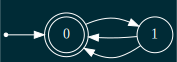

('green', 'blue', 'yellow') 0.8454866256305861
('green', 'yellow') 0.9083071171858593
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8454866256305861
{'energy': 27.712981696897117}


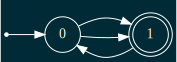

('green', 'blue', 'yellow') 0.8506044582021886
('green', 'yellow') 0.9113441929352272
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8506044582021886
{'energy': 26.385804480546952}


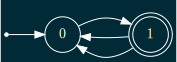

('green', 'blue', 'yellow') 0.8671902326278785
('green', 'yellow') 0.9211866902400921
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8671902326278785
{'energy': 30.348006683174557}


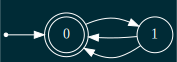

('green', 'blue', 'yellow') 0.8674700981765615
('green', 'yellow') 0.9213527708726835
('blue', 'green', 'yellow') 0.9999999999999999
('blue', 'yellow') 0.8674700981765615
{'energy': 31.248246688824995}


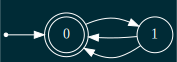

('green', 'blue', 'yellow') 0.8675835188444133
('green', 'yellow') 0.9214200781077269
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8675835188444133
{'energy': 26.398871732750706}


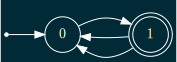

('green', 'blue', 'yellow') 0.880625584067235
('green', 'yellow') 0.9291596318066286
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.880625584067235
{'energy': 29.459095037229336}


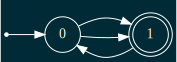

('green', 'blue', 'yellow') 0.8811742107653001
('green', 'yellow') 0.9294852033873393
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8811742107653001
{'energy': 31.30972644257953}


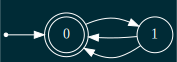

('green', 'blue', 'yellow') 0.8812599626851574
('green', 'yellow') 0.9295360911552795
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8812599626851574
{'energy': 30.319240939534996}


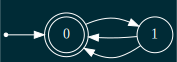

('green', 'blue', 'yellow') 0.8814902392034292
('green', 'yellow') 0.9296727441660038
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8814902392034292
{'energy': 29.471449213638852}


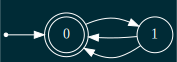

('green', 'blue', 'yellow') 0.8820243558320406
('green', 'yellow') 0.9299897050351595
('blue', 'green', 'yellow') 0.9999999999999999
('blue', 'yellow') 0.8820243558320406
{'energy': 31.300168553312403}


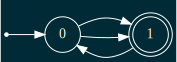

('green', 'blue', 'yellow') 0.8821096967567132
('green', 'yellow') 0.9300403489061979
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8821096967567132
{'energy': 30.565872782061728}


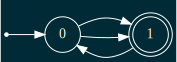

('green', 'blue', 'yellow') 0.8822871522528248
('green', 'yellow') 0.9301456563339601
('blue', 'green', 'yellow') 0.9999999999999999
('blue', 'yellow') 0.8822871522528248
{'energy': 30.107359005854587}


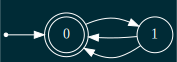

('green', 'blue', 'yellow') 0.8825667492198348
('green', 'yellow') 0.9303115775821099
('blue', 'green', 'yellow') 0.9999999999999998
('blue', 'yellow') 0.8825667492198348
{'energy': 26.427892571895523}


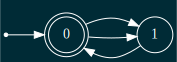

('green', 'blue', 'yellow') 0.8926687361330681
('green', 'yellow') 0.936306400399263
('blue', 'green', 'yellow') 0.9999999999999998
('blue', 'yellow') 0.8926687361330681
{'energy': 35.49390083125732}


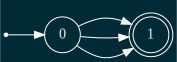

('green', 'blue', 'yellow') 0.8926698027790112
('green', 'yellow') 0.9363070333790414
('blue', 'green', 'yellow') 0.9999999999999998
('blue', 'yellow') 0.8926698027790112
{'energy': 29.74488006065722}


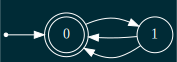

('green', 'blue', 'yellow') 0.8930035605338967
('green', 'yellow') 0.9365050952674179
('blue', 'green', 'yellow') 0.9999999999999996
('blue', 'yellow') 0.8930035605338967
{'energy': 30.33533598468941}


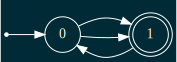

('green', 'blue', 'yellow') 0.8931875950916079
('green', 'yellow') 0.936614306908176
('blue', 'green', 'yellow') 0.9999999999999998
('blue', 'yellow') 0.8931875950916079
{'energy': 31.23994665090918}


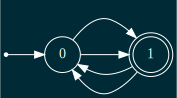

('green', 'blue', 'yellow') 0.8932618939477668
('green', 'yellow') 0.9366583980837058
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8932618939477668
{'energy': 32.051170134270386}


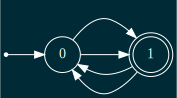

('green', 'blue', 'yellow') 0.8932948728230036
('green', 'yellow') 0.9366779687399986
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8932948728230036
{'energy': 31.887288681289625}


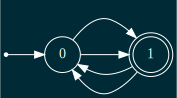

('green', 'blue', 'yellow') 0.8933336982638564
('green', 'yellow') 0.9367010089241435
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8933336982638564
{'energy': 27.686737327862684}


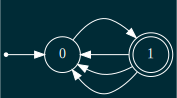

('green', 'blue', 'yellow') 0.895861930157529
('green', 'yellow') 0.9382013377578098
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.895861930157529
{'energy': 27.69429300423539}


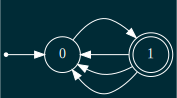

('green', 'blue', 'yellow') 0.8982553552459291
('green', 'yellow') 0.939621668179372
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8982553552459291
{'energy': 29.81106856263664}


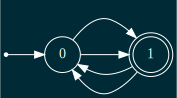

('green', 'blue', 'yellow') 0.8985361685172601
('green', 'yellow') 0.9397883112190824
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8985361685172601
{'energy': 30.908889180369382}


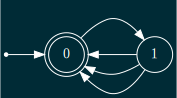

('green', 'blue', 'yellow') 0.898629502588501
('green', 'yellow') 0.9398436984636608
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.898629502588501
{'energy': 30.90367894445021}


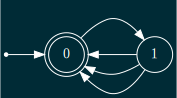

('green', 'blue', 'yellow') 0.8977993250031592
('green', 'yellow') 0.9398992724382619
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8977993250031592
{'energy': 29.81829944099889}


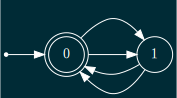

('green', 'blue', 'yellow') 0.8953505000597122
('green', 'yellow') 0.9400632023462867
('blue', 'green', 'yellow') 1.0000000000000002
('blue', 'yellow') 0.8953505000597122
{'energy': 31.48186226172396}


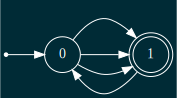

('green', 'blue', 'yellow') 0.8954045524737597
('green', 'yellow') 0.9400941602448462
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8954045524737597
{'energy': 28.87714589207917}


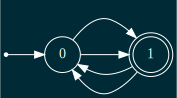

('green', 'blue', 'yellow') 0.8961302920290798
('green', 'yellow') 0.9405098192293739
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8961302920290798
{'energy': 30.905815411730163}


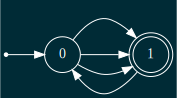

('green', 'blue', 'yellow') 0.8962249856744857
('green', 'yellow') 0.9405640539258324
('blue', 'green', 'yellow') 0.9999999999999999
('blue', 'yellow') 0.8962249856744857
{'energy': 30.49409987614367}


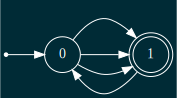

('green', 'blue', 'yellow') 0.8963675901998607
('green', 'yellow') 0.9406457290278327
('blue', 'green', 'yellow') 0.9999999999999999
('blue', 'yellow') 0.8963675901998607
{'energy': 28.83211776385486}


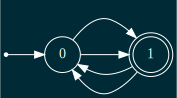

('green', 'blue', 'yellow') 0.897112651730259
('green', 'yellow') 0.9410724544513898
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.897112651730259
{'energy': 28.682964596173807}


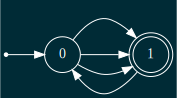

('green', 'blue', 'yellow') 0.8979642315871647
('green', 'yellow') 0.9415601870215258
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8979642315871647
{'energy': 28.31069379513739}


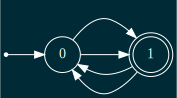

('green', 'blue', 'yellow') 0.8991751259262252
('green', 'yellow') 0.94225371282931
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8991751259262252
{'energy': 26.971848952601103}


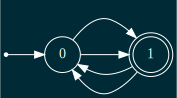

('green', 'blue', 'yellow') 0.9035417529854073
('green', 'yellow') 0.9447546482625871
('blue', 'green', 'yellow') 0.9999999999999998
('blue', 'yellow') 0.9035417529854073
{'energy': 30.992959497080296}


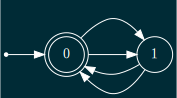

('green', 'blue', 'yellow') 0.9036166103422686
('green', 'yellow') 0.9447975219528929
('blue', 'green', 'yellow') 0.9999999999999997
('blue', 'yellow') 0.9036166103422686
{'energy': 30.932273887615512}


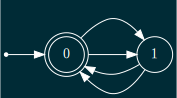

('green', 'blue', 'yellow') 0.9036960239208645
('green', 'yellow') 0.944843005166802
('blue', 'green', 'yellow') 0.9999999999999998
('blue', 'yellow') 0.9036960239208645
{'energy': 30.374926087294355}


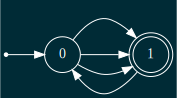

('green', 'blue', 'yellow') 0.9038343695773214
('green', 'yellow') 0.9449222410506051
('blue', 'green', 'yellow') 0.9999999999999998
('blue', 'yellow') 0.9038343695773214
{'energy': 30.511627237466485}


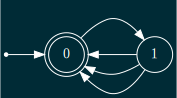

('green', 'blue', 'yellow') 0.9039547147863815
('green', 'yellow') 0.9449911673851614
('blue', 'green', 'yellow') 0.9999999999999998
('blue', 'yellow') 0.9039547147863815
{'energy': 31.489668172348924}


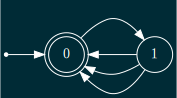

('green', 'blue', 'yellow') 0.9039998923557704
('green', 'yellow') 0.9450170423185007
('blue', 'green', 'yellow') 0.9999999999999998
('blue', 'yellow') 0.9039998923557704
{'energy': 29.79853010155251}


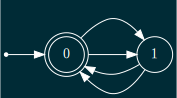

('green', 'blue', 'yellow') 0.9042442711454921
('green', 'yellow') 0.9451570074600328
('blue', 'green', 'yellow') 0.9999999999999998
('blue', 'yellow') 0.9042442711454921
{'energy': 30.90886661755326}


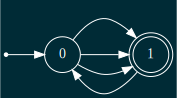

('green', 'blue', 'yellow') 0.904324509029508
('green', 'yellow') 0.945202962785392
('blue', 'green', 'yellow') 0.9999999999999998
('blue', 'yellow') 0.904324509029508
{'energy': 31.452650503939797}


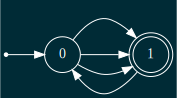

('green', 'blue', 'yellow') 0.9043710292582157
('green', 'yellow') 0.9452296067114161
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.9043710292582157
{'energy': 27.97345974276202}


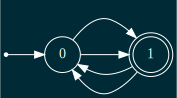

('green', 'blue', 'yellow') 0.9058556945186783
('green', 'yellow') 0.9460799316661518
('blue', 'green', 'yellow') 0.9999999999999999
('blue', 'yellow') 0.9058556945186783
{'energy': 29.601761917295686}


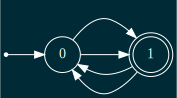

('green', 'blue', 'yellow') 0.9061416834181046
('green', 'yellow') 0.9462437285195139
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.9061416834181046
{'energy': 30.875167781893193}


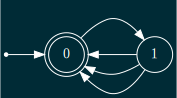

('green', 'blue', 'yellow') 0.9062214141333051
('green', 'yellow') 0.9462893933697663
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.9062214141333051
{'energy': 30.92606742851059}


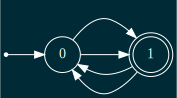

('green', 'blue', 'yellow') 0.9062970626938394
('green', 'yellow') 0.9463327202128768
('blue', 'green', 'yellow') 0.9999999999999999
('blue', 'yellow') 0.9062970626938394
{'energy': 30.380965201513625}


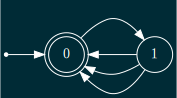

('green', 'blue', 'yellow') 0.9064272537810731
('green', 'yellow') 0.9464072856609327
('blue', 'green', 'yellow') 0.9999999999999998
('blue', 'yellow') 0.9064272537810731
{'energy': 27.28159006515633}


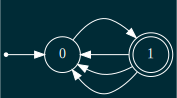

('green', 'blue', 'yellow') 0.9092251719151421
('green', 'yellow') 0.948009761097022
('blue', 'green', 'yellow') 0.9999999999999999
('blue', 'yellow') 0.9092251719151421
{'energy': 26.3436844664107}


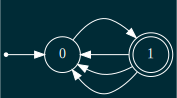

('green', 'blue', 'yellow') 0.9156670175420834
('green', 'yellow') 0.9516992541006077
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.9156670175420834
{'energy': 28.839872727479055}


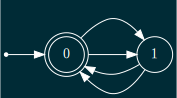

('green', 'blue', 'yellow') 0.9103438570966005
('green', 'yellow') 0.9461666229930434
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.9103438570966005
{'energy': 25.59604402027816}


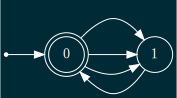

('green', 'blue', 'yellow') 0.7922869513044397
('green', 'yellow') 0.8234640826248016
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.7922869513044397
{'energy': 29.881714474124838}


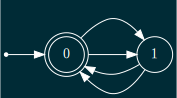

('green', 'blue', 'yellow') 0.7926570624368485
('green', 'yellow') 0.8219968025187504
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.7908752238150908
{'energy': 31.46242882587772}


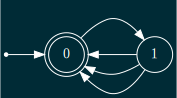

('green', 'blue', 'yellow') 0.7927330780574655
('green', 'yellow') 0.8220620616671321
('blue', 'green', 'yellow') 1.0000000000000002
('blue', 'yellow') 0.7909518926895405
{'energy': 27.989603239179484}


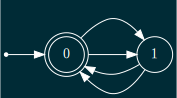

('green', 'blue', 'yellow') 0.7951533901365684
('green', 'yellow') 0.8241398912476627
('blue', 'green', 'yellow') 1.0000000000000002
('blue', 'yellow') 0.7933930041534207
{'energy': 28.315950966450533}


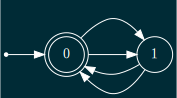

('green', 'blue', 'yellow') 0.7968649622127364
('green', 'yellow') 0.825609269977694
('blue', 'green', 'yellow') 1.0000000000000002
('blue', 'yellow') 0.7951192849303773
{'energy': 29.548811025606344}


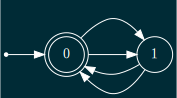

('green', 'blue', 'yellow') 0.797358443403182
('green', 'yellow') 0.8260329218793625
('blue', 'green', 'yellow') 1.0000000000000004
('blue', 'yellow') 0.7956170069397028
{'energy': 30.694205463371677}


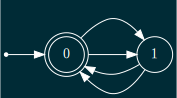

('green', 'blue', 'yellow') 0.7975149167297346
('green', 'yellow') 0.8261672536910667
('blue', 'green', 'yellow') 1.0000000000000004
('blue', 'yellow') 0.795774824947776
{'energy': 29.451646034544492}


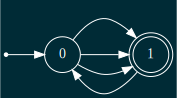

('green', 'blue', 'yellow') 0.798055149952444
('green', 'yellow') 0.8266310420513457
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.7963197007613172
{'energy': 26.35188145762006}


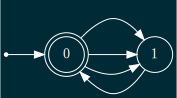

('green', 'blue', 'yellow') 0.8093439920829169
('green', 'yellow') 0.836322474123746
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.807705555575894
{'energy': 35.79104944350449}


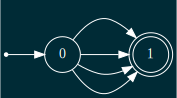

('green', 'blue', 'yellow') 0.8093448398696408
('green', 'yellow') 0.8363232019457273
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8077064106482248
{'energy': 28.88242215331147}


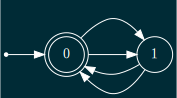

('green', 'blue', 'yellow') 0.81018960275298
('green', 'yellow') 0.8370484279703758
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.8085584331525063
{'energy': 30.529982025902218}


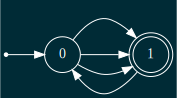

('green', 'blue', 'yellow') 0.8103513771507992
('green', 'yellow') 0.8371873107334971
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 0.80872159778755
energy 25.59604402027816


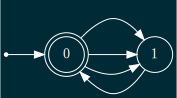

energy 26.09901480832629


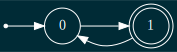

energy 26.3436844664107


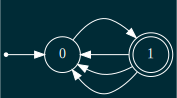

energy 26.35188145762006


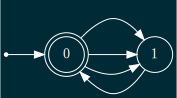

energy 26.385804480546952


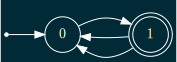

energy 26.387005073385215


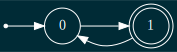

energy 26.398871732750706


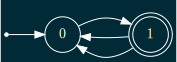

energy 26.427892571895523


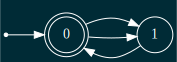

energy 26.49098622093907


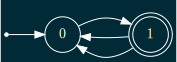

energy 26.500334607666648


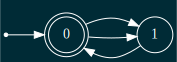

energy 26.728425805455455


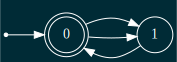

energy 26.971848952601103


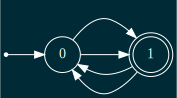

energy 27.28159006515633


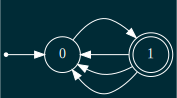

energy 27.376373271873515


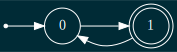

energy 27.40222673052705


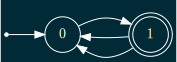

energy 27.425748450959794


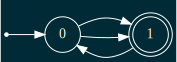

energy 27.442681543023234


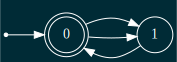

energy 27.479283452411302


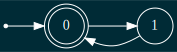

energy 27.686737327862684


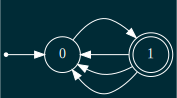

energy 27.69429300423539


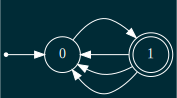

energy 27.712981696897117


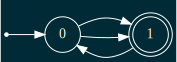

energy 27.7799861349916


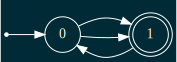

energy 27.97345974276202


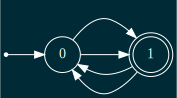

energy 27.989603239179484


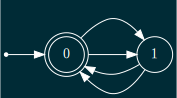

energy 28.16963117154631


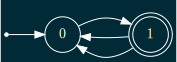

energy 28.31069379513739


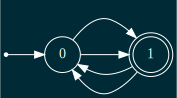

energy 28.315950966450533


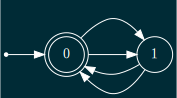

energy 28.6137800435233


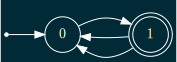

energy 28.661684628765705


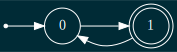

energy 28.682964596173807


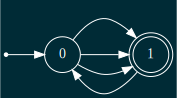

energy 28.74495565133852


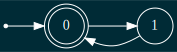

energy 28.83211776385486


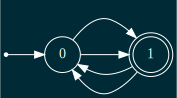

energy 28.839872727479055


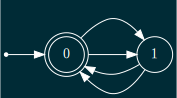

energy 28.87714589207917


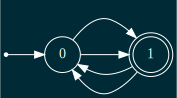

energy 28.88242215331147


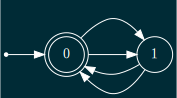

energy 29.10663465877887


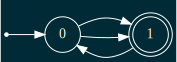

energy 29.451646034544492


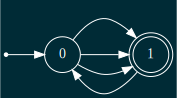

energy 29.459095037229336


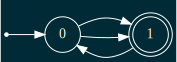

energy 29.471449213638852


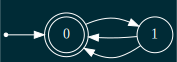

energy 29.548811025606344


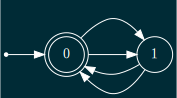

energy 29.601761917295686


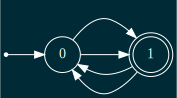

energy 29.736868944336432


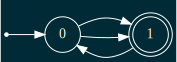

energy 29.74488006065722


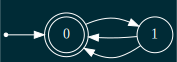

energy 29.79853010155251


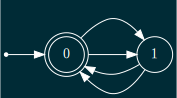

energy 29.81106856263664


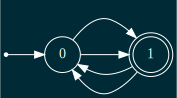

energy 29.81829944099889


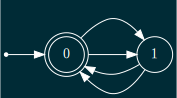

energy 29.881714474124838


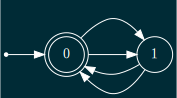

energy 29.883350159938402


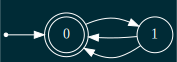

energy 29.89759972251682


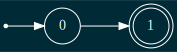

energy 29.969353622889084


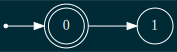

energy 30.107359005854587


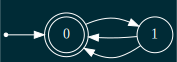

energy 30.140651201214954


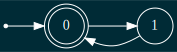

energy 30.15315918354624


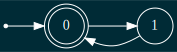

energy 30.16544461331035


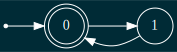

energy 30.184371840901353


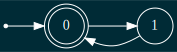

energy 30.319240939534996


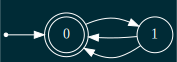

energy 30.323375636493438


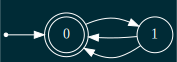

energy 30.33533598468941


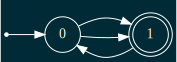

energy 30.348006683174557


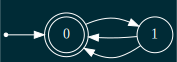

energy 30.352795461484742


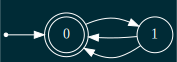

energy 30.374926087294355


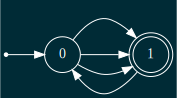

energy 30.380965201513625


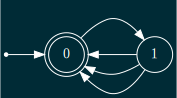

energy 30.405990513487655


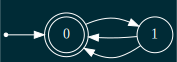

energy 30.432990240562976


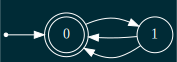

energy 30.49409987614367


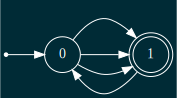

energy 30.498475944637594


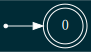

energy 30.511627237466485


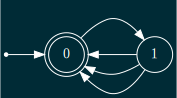

energy 30.529982025902218


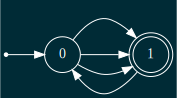

energy 30.565872782061728


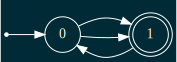

energy 30.650299543498885


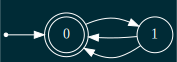

energy 30.694205463371677


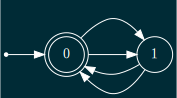

energy 30.77388108442886


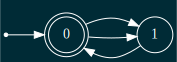

energy 30.875167781893193


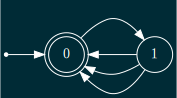

energy 30.90367894445021


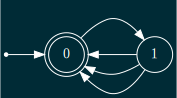

energy 30.905815411730163


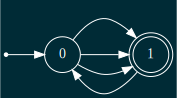

energy 30.90886661755326


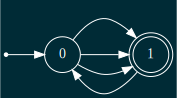

energy 30.908889180369382


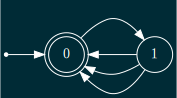

energy 30.92606742851059


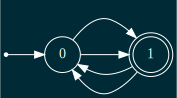

energy 30.932273887615512


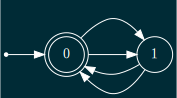

energy 30.992959497080296


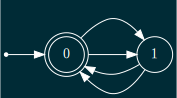

energy 31.105309473511706


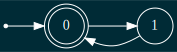

energy 31.23994665090918


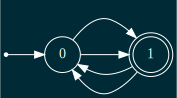

energy 31.248246688824995


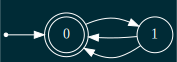

energy 31.284585538485434


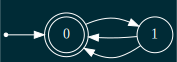

energy 31.300168553312403


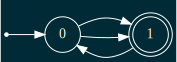

energy 31.30972644257953


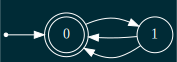

energy 31.452650503939797


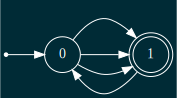

energy 31.46242882587772


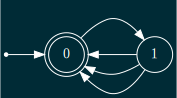

energy 31.48186226172396


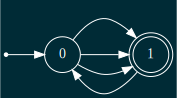

energy 31.489668172348924


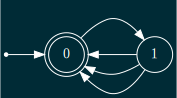

energy 31.887288681289625


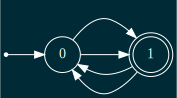

energy 32.051170134270386


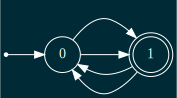

energy 32.09944286581337


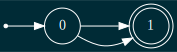

energy 32.67513024287634


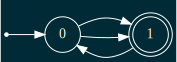

energy 35.20351260923749


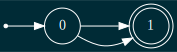

energy 35.49390083125732


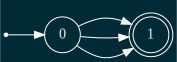

energy 35.566500434000716


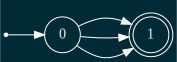

energy 35.77134474794835


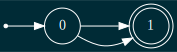

energy 35.79104944350449


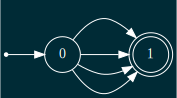

energy 36.1325354207877


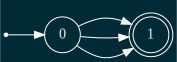

In [145]:
identifer = PartialDFAIdentifier(
    #partial = PARTIAL_DFA,
    #base_examples = BASE_EXAMPLES,
    base_examples = LabeledExamples(negative=[], positive=[('blue', 'green', 'yellow'), ('yellow',)]),
    partial = universal,
)

dfa_search = concept_class.enumerative_search(
    demos=[to_demo(TRC4), to_demo(TRC5)],
    identifer=identifer,
    to_chain=to_chain,
    competency=lambda *_: 0.8,
    n_iters=n_iters,
    surprise_weight=1,  # Rescale surprise to make comparable to size.
    size_weight=1,
)

df3 = analyze(dfa_search, n_iters)

In [146]:
df3['treatment'] = 'enumeration'
df3['iteration'] = df3.index

In [147]:
#df = pd.concat([df_greed0, df_greed4], ignore_index=True)
df = pd.concat([df_greed0, df_greed4, df3], ignore_index=True)

In [148]:
df_greed0

,probability mass explored,median energies,min energies,brier score,iteration,treatment
0,5.684342e-14,30.498476,30.498476,0.500000,0,$\beta = \infty$
1,1.136868e-13,30.498476,30.498476,0.250000,1,$\beta = \infty$
2,1.136868e-13,30.498476,30.498476,0.250000,2,$\beta = \infty$
3,1.186396e-13,30.498476,30.498476,0.239999,3,$\beta = \infty$
4,1.186396e-13,30.498476,30.498476,0.239999,4,$\beta = \infty$
...,...,...,...,...,...,...
95,8.442996e-10,32.095265,21.273178,0.000094,95,$\beta = \infty$
96,8.442996e-10,32.095265,21.273178,0.000094,96,$\beta = \infty$
97,9.317760e-10,32.091087,21.273178,0.000077,97,$\beta = \infty$
98,9.857122e-10,32.066614,21.273178,0.000069,98,$\beta = \infty$


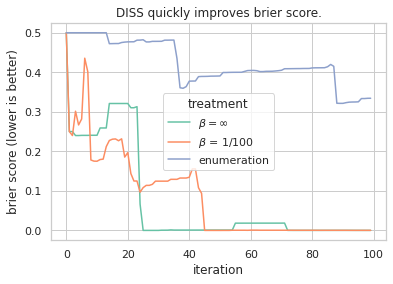

In [151]:
sns.lineplot(data=df, x='iteration', y='brier score', hue='treatment', palette='Set2')
plt.title('DISS quickly improves brier score.')
plt.ylabel('brier score (lower is better)')
#plt.legend(loc="lower right")
plt.savefig('bs_2demo.pgf')

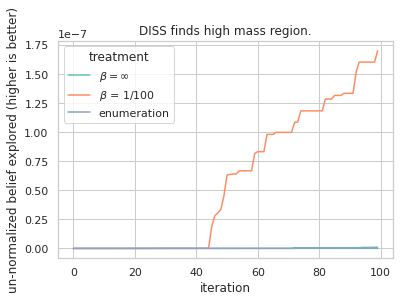

In [152]:
sns.lineplot(data=df, x='iteration', y='probability mass explored', hue='treatment', palette='Set2')
plt.title('DISS finds high mass region.')
plt.ylabel('un-normalized belief explored (higher is better)')
plt.savefig('mass_2demo.pgf')